# Projeto de Aprendizagem Computacional

## 1. Contexto
O cancro da mama é uma doença bastante comum e com grande impacto na saúde pública a nível mundial. 
A identificação antecipada é um fator determinante para o sucesso do tratamento e para o aumento da taxa de sobrevivência. Contudo, os métodos de diagnóstico tradicionais, como a mamografia, são muitas vezes invasivos, dispendiosos e dependem de equipamentos especializados.

Nos últimos anos, a análise de amostras de sangue tem surgido como uma alternativa promissora para a deteção precoce do cancro, oferecendo uma abordagem menos invasiva e mais acessível. Através da medição de parâmetros clínicos e bioquímicos, é possível identificar padrões associados à presença da doença.

## 2. Objetivo
O projeto tem como objetivo o desenvolvimento de pipelines de Machine Learning capazes de identificar, com base em dados clínicos recolhidos de amostras de sangue, se um indivíduo tem ou não cancro da mama.

# 3. Trabalho Prático

## 3.1 Exploração dos Dados
O trabalho recorre ao Breast Cancer Coimbra Dataset — um conjunto de dados com 116 amostras (64 de pacientes com cancro e 52 de controlos saudáveis), contendo dez variáveis relacionadas com características antropométricas e parâmetros sanguíneos.

In [1]:
import pandas as pd

data = pd.read_excel('dataR2.xlsx', usecols=["Age", "BMI", "Glucose", "Insulin", "HOMA", "Leptin", "Adiponectin", "Resistin", "MCP.1", "Classification"])

### Histogramas
Um histograma permite-nos visualizar a distribuição de valores para cada variável e ajuda a ver a forma da distribuição, detetar valores discrepantes ou extremos, e comparar distribuições entre classes.

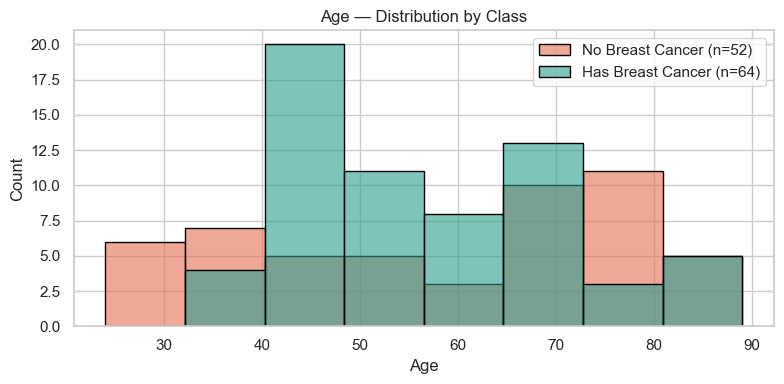

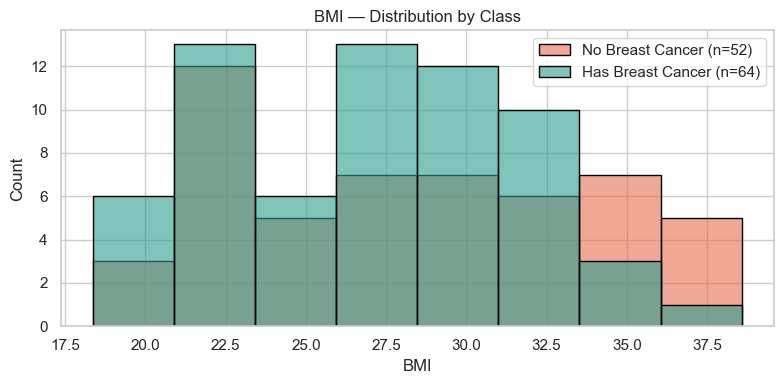

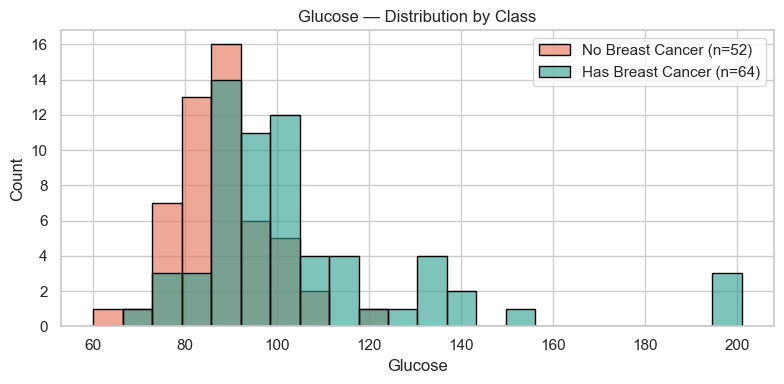

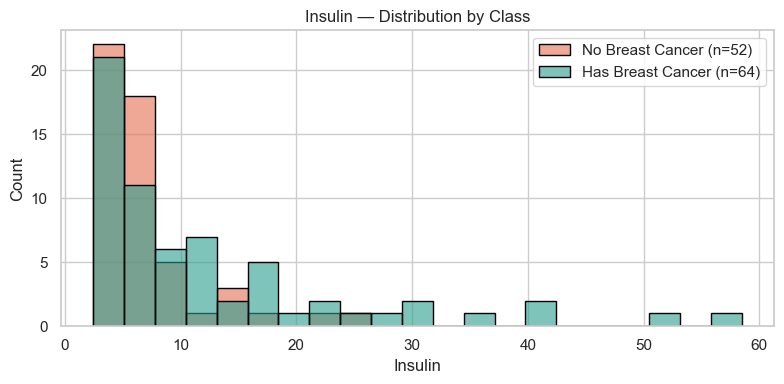

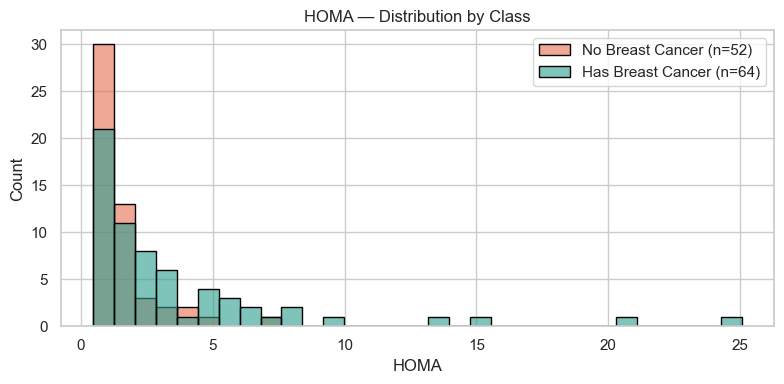

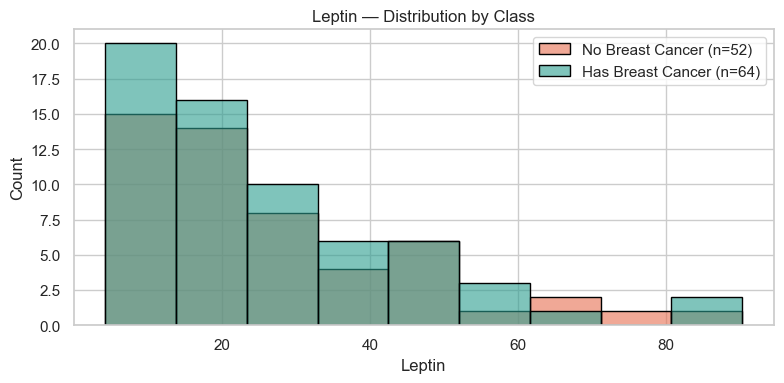

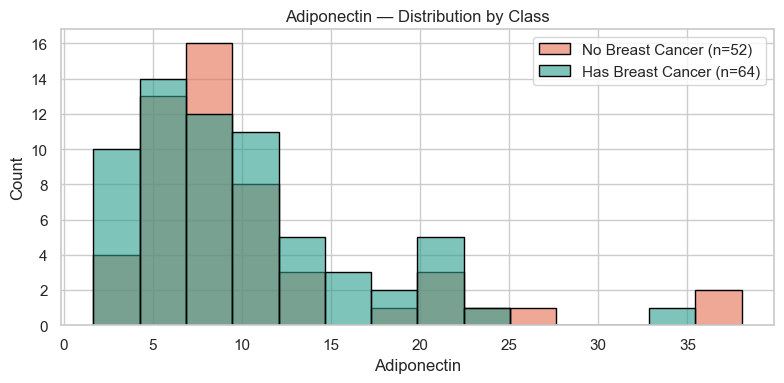

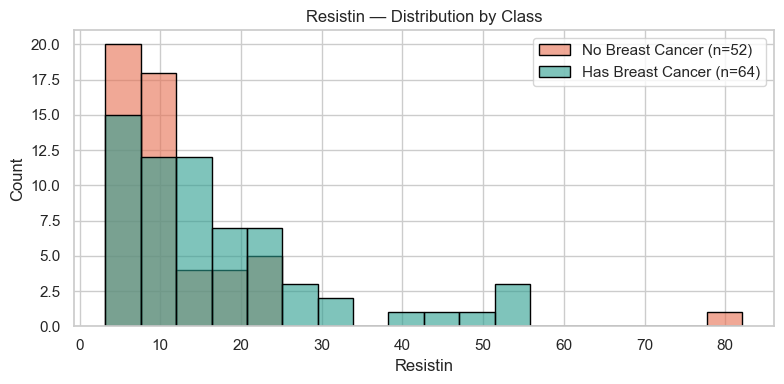

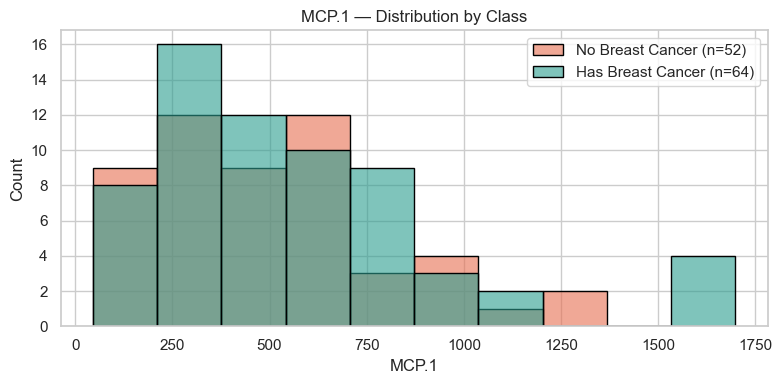

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="whitegrid", context="notebook")

columns = data.columns[:-1]  # Exclude "Classification"
palette = {1: "#e76f51", 2: "#2a9d8f"}
class_labels = {1: "No Breast Cancer", 2: "Has Breast Cancer"}

for col in columns:
    plt.figure(figsize=(8, 4))
    for cls in [1, 2]:
        # use common bins for both classes so the histograms are comparable
        bins = np.histogram_bin_edges(data[col].dropna(), bins='auto')
        sns.histplot(
            data=data[data["Classification"] == cls],
            x=col,
            bins=bins,
            label=f"{class_labels[cls]} (n={len(data[data['Classification']==cls])})",
            color=palette[cls],
            alpha=0.6,
            stat='count',
            edgecolor='black'
        )
    plt.title(f"{col} — Distribution by Class")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Box Plots

In [3]:
import plotly.graph_objects as go

class_labels = {1: "No Breast Cancer", 2: "Has Breast Cancer"}

for column in columns:
    fig = go.Figure()
    for label in class_labels:
        fig.add_trace(go.Violin(
            y=data[data['Classification'] == label][column],
            name=class_labels[label],
            box_visible=True,
            meanline_visible=True,
            points='all'
        ))
    fig.update_layout(
        title=f'{column} by Classification',
        autosize=False,
        width=1000,
        height=500,
        font=dict(size=18, color="black")
    )
    fig.show()

## 3.2 Particionamento dos Dados
O particonamento dos dados permite avaliar a capacidade de generalização dos modelos e evitar o fenómeno de overfitting.
Por isso, a separação entre conjuntos de treino, validação e teste é importante, de modo a garantir que o modelo é avaliado utilizando apenas dados que não foram vistos durante o treino.

Dessa forma, procedeu-se à divisão do conjunto de dados em subconjuntos de treino e de teste, de forma a avaliar o desempenho do modelo em dados não utilizados durante o treino. Foram testadas duas proporções de partição: 70% para treino e 30% para teste, e 60% para treino e 40% para teste.

O parâmetro "stratify=y" foi usado de modo a garantir que as proporções das classes (1 e 2) sejam mantidas tanto no treino como no teste.

In [4]:
from sklearn.model_selection import train_test_split

X = data.drop('Classification', axis=1)
y = data['Classification']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1
)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=1
)



## 3.3 Seleção de Features e Redução de Dimensionalidade

### Receiver Operator Characteristics (ROC) ###
O ROC tem como função saber que features são as mais discriminadoras entre os classificadores. Neste caso, refere quais features discriminam mais entre pacientes com cancro e pacientes saudáveis. 

Analisando os gráficos, a feature glucose apresenta ser a mais discriminadora, o que significa que é a característica que permite identificar os pacientes com uma maior precisão.

In [5]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Find the indexes where de class samples are located
ixHealthy = np.where(y_train == 1)[0]
ixCancer = np.where(y_train == 2)[0]

ixHasOrNot=np.concatenate((ixHealthy,ixCancer))
y=y_train.to_numpy()[ixHasOrNot]


roc_auc=np.zeros(columns.shape)
i=0
for f in columns: #Go along features
    fpr, tpr, _= roc_curve(y,X_train[f].to_numpy()[ixHasOrNot],pos_label=2)
    
    figR = go.Figure()
    figR.add_scatter(x=fpr, y=tpr,mode='lines+markers')
    figR.update_layout(autosize=False,width=700,height=700,title=dict(text=f))
    figR.update_xaxes(title_text="1-SP",range=[-0.01, 1.01])
    figR.update_yaxes(title_text="SS",range=[-0.01, 1.01])
    

    roc_auc[i] = auc(fpr, tpr)#Compute area under the ROC curve
    
    figR.add_annotation(x=0.5, y=0.5,
            text="AUC: "+str(roc_auc[i]),
            showarrow=False,
            yshift=10)
    figR.show()
    i=i+1

sortIx=np.flip(np.argsort(roc_auc))
print("Sorting accourding to ROC-AUC:")
for i in sortIx:
    print(columns[i]+"-->"+str(roc_auc[i]))

Sorting accourding to ROC-AUC:
Glucose-->0.7762345679012346
HOMA-->0.6635802469135802
Resistin-->0.6160493827160494
Insulin-->0.6108024691358025
Adiponectin-->0.5820987654320987
Age-->0.47777777777777775
MCP.1-->0.47530864197530864
Leptin-->0.4709876543209877
BMI-->0.3725308641975309


### Kruskal-Wallis

In [6]:
from scipy import stats
import numpy as np

X = X_train.to_numpy(dtype=float)

ixHealthy = (y_train == 1).to_numpy()
ixCancer = (y_train == 2).to_numpy()

fnames = X_train.columns

Hs = []

for i in range(X.shape[1]):
    st = stats.kruskal(X[ixHealthy, i].flatten(), X[ixCancer, i].flatten())
    Hs.append((fnames[i], st.statistic, st.pvalue))

Hs = sorted(Hs, key=lambda x: x[1], reverse=True)

print("Ranked features (Kruskal-Wallis):")
for f in Hs:
    print(f"{f[0]:15} --> H = {f[1]:.4f}, p = {f[2]:.4f}")


Ranked features (Kruskal-Wallis):
Glucose         --> H = 18.1080, p = 0.0000
HOMA            --> H = 6.3437, p = 0.0118
BMI             --> H = 3.8522, p = 0.0497
Resistin        --> H = 3.1928, p = 0.0740
Insulin         --> H = 2.9106, p = 0.0880
Adiponectin     --> H = 1.5979, p = 0.2062
Leptin          --> H = 0.1995, p = 0.6551
MCP.1           --> H = 0.1445, p = 0.7038
Age             --> H = 0.1172, p = 0.7321


### Matriz de Correlação

O Kruskal–Wallis H test é um método estatístico não paramétrico utilizado para verificar se existem diferenças estatisticamente significativas entre as medianas de três ou mais grupos independentes. Embora o problema em análise seja binário, optou-se por aplicar este teste, uma vez que permite identificar variáveis com potencial discriminativo entre classes, contribuindo assim para a seleção das features mais relevantes para os classificadores.

Com base nos resultados obtidos, verificou-se que as variáveis Glucose e HOMA apresentam valores elevados de H e p-values<0.05, indicando diferenças significativas entre os grupos. Estas variáveis foram, por isso, consideradas particularmente relevantes para as etapas seguintes de seleção de features e redução de dimensionalidade.

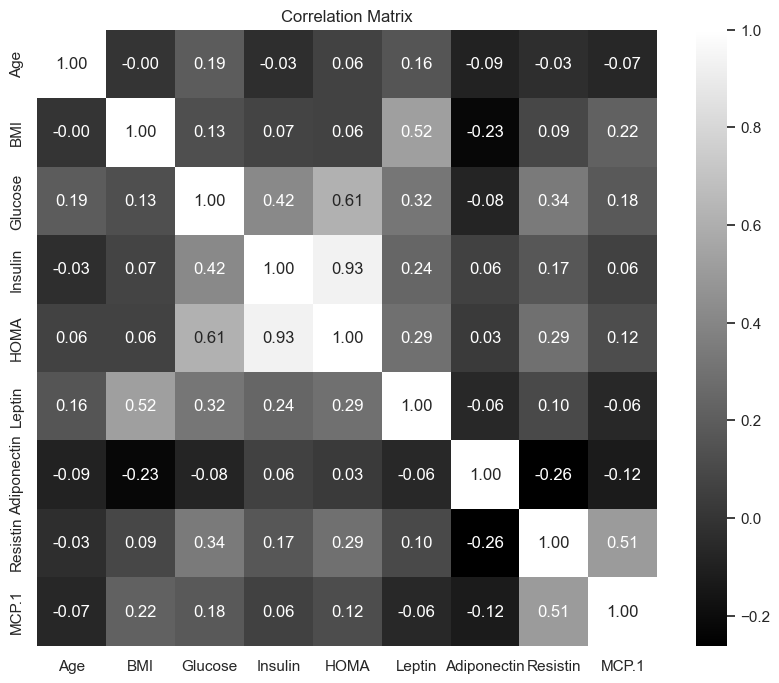

In [7]:
## Correlation matrix to see how the variables are correlated with each other.

plt.figure(figsize=(10, 8))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='gray', cbar=True)
plt.title('Correlation Matrix')
plt.show()

A matriz de correlação foi analisada com o objetivo de identificar relações lineares fortes entre as variáveis e possíveis redundâncias de informação.
Verificou-se que as features HOMA e Insulin apresentam correlação elevada (|r| > 0.9), o que indica que fornecem informação semelhante.
Neste caso, optou-se por manter apenas a feature com maior relevância discriminativa, isto é, menor p-value do Kruskal-Wallis H test: HOMA.

### Normalização dos Dados

In [8]:
# Data Normalization

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_2 = scaler.fit_transform(X_train_2)
X_test_scaled_2 = scaler.transform(X_test_2)

### Principal Component Analysis (PCA) ### 
Devido à matriz original conter uma grande variedade de variáveis, pode gerar redundâncias, só que, se eliminarmos demasiados componentes pode correr o risco de apagar informações importantes. Por essa razão é usado o PCA, que descobre quantos componentes devem ser mantidos para que não haja uma perca significativa de informação. Após a implementação, são devolvidas as percentagem de informação mantida de acordo com o Critério de Kaiser e o Teste de Scree. 

Verificou-se que, de acordo com o Critério de Kaiser, 91.14% da informação original é mantida e analisando o gráfico, 4 das 9 features são responsáveis por essa percentagem. Já o Teste de Scree indica que só 2.1% da informação é perdida usando 6 features. Concluindo, é possível manter a maior parte da informação só usando 4 features.

In [9]:
from sklearn.decomposition import PCA
import plotly.express as px

#PCA

X = X_train_scaled

pca = PCA()
pca.fit(X)

#PCA eigenvalues/Explained variance
print("PCA eigenvalues/Explained variance")
print(pca.explained_variance_)
print("Sum of eigenvalues="+str(np.sum(pca.explained_variance_)))
#PCA eigenvectors/Principal components
print("PCA eigenvectors/Principal components")
W=pca.components_.T
print(W)

fig = px.scatter(x=np.arange(1,10,1), y=pca.explained_variance_,
                 labels=dict(x="PC",y="Explained Variance"))
fig.add_hline(y=1,line_width=3, line_dash="dash", line_color="red")
fig.update_traces(marker_size=10)
fig.show()

#To know which indexes are > 1
kaiser_mask = pca.explained_variance_ > 1
kaiser_sum = np.sum(pca.explained_variance_[kaiser_mask] ** 2)
total_sum = np.sum(pca.explained_variance_ ** 2)

print("Variance (%) retained accourding to Kaiser: "+str((kaiser_sum/total_sum)*100))
print("Variance (%) retained accourding to Scree: "+str(np.sum(pca.explained_variance_[0:6]**2)/(np.sum(pca.explained_variance_**2))*100))

# 1-dimension PCA
pca2 = PCA(n_components=1)
X_1D = pca2.fit_transform(X)

print(np.shape(X_1D))

#Plot projected data
fig=px.scatter(x=X_1D[:, 0],y=np.zeros(np.shape(X_1D)[0]),color=y_train,labels=dict(x="PC1",y="",color="Cancer Patient"))
fig.update_traces(marker_size=8)
fig.update_xaxes
fig.show()

PCA eigenvalues/Explained variance
[2.82396544 1.59612809 1.40823034 1.0746661  0.81612775 0.59038836
 0.47211361 0.29754198 0.03333833]
Sum of eigenvalues=9.112499999999999
PCA eigenvectors/Principal components
[[ 0.07904712  0.02199785  0.34248444  0.78562066  0.30716373  0.33991077
  -0.18831711  0.1103082  -0.03538526]
 [ 0.21673187 -0.3860021   0.46455642 -0.40684084  0.0884333   0.29350032
   0.17866561  0.54346462  0.03820285]
 [ 0.45411467  0.0580891  -0.0040258   0.24953982  0.12034442 -0.4351596
   0.70183547  0.04717227 -0.17168078]
 [ 0.46298753  0.37483    -0.11376653 -0.14855212 -0.2184101   0.35206408
  -0.17967163  0.01689063 -0.63711473]
 [ 0.5240151   0.32231418 -0.12087171 -0.01102029 -0.13113104  0.16687592
  -0.05450535  0.01161833  0.7474233 ]
 [ 0.31509532 -0.06235211  0.57628871 -0.19174317  0.13400886 -0.33839291
  -0.32898794 -0.53557584 -0.02025702]
 [-0.09957407  0.47896595 -0.08888965 -0.27758069  0.78415742 -0.10229309
  -0.0898423   0.20558518 -0.00453596

Variance (%) retained accourding to Kaiser: 91.14495704261365
Variance (%) retained accourding to Scree: 97.91471412925833
(81, 1)


### Linear Discriminant Analysis (LDA)
Como o problema do dataset tem apenas duas classes, a projeção do LDA será apenas de 1 dimensão, independentemente do número de features.  

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

X = X_train_scaled_df.to_numpy()
y = y_train.to_numpy()

lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

transformed = lda.transform(X)

fig = px.scatter(
    x=transformed[:, 0], 
    y=np.zeros(transformed.shape[0]),
    color=y,
    labels=dict(x="LDA1", y="", color="Class")
)
fig.update_traces(marker_size=5)
fig.show()


## 3.4 Classificação

Nesta etapa o objetivo é avaliar a capacidade dos modelos em distinguir entre indivíduos saudáveis e indivíduos com cancro, com base nas features disponíveis, previamente analisadas.

A avaliação do desempenho baseou-se em métricas de classificação como accuracy, precision, recall, F1-score. Dado o contexto clínico do problema, demos especial importância à métrica recall, de modo a procurar reduzir o número de FN, isto é, o modelo prever que o paciente não tem cancro, mas o paciente tem. É, por isso, especialmente importante minimizar o número de falsos negativos.

### Mahalanobis MDC e Euclidean MDC

In [11]:
#Euclidean (False) and Mahalaboris (True) MDC

def mdc(matrix, feat1, feat2, y, isMahalanobis, dataset_name):
    
    mdc_type = "Mahalanobis" if isMahalanobis else "Euclidean"

    # --- garante arrays numpy e índices posicionais ---
    y_arr = np.asarray(y).flatten()
    ixHealthy = np.where(y_arr == 1)[0]
    ixCancer  = np.where(y_arr == 2)[0]

    # extrai features
    f1H = matrix[feat1].to_numpy()[ixHealthy]
    f1C = matrix[feat1].to_numpy()[ixCancer]
    f2H = matrix[feat2].to_numpy()[ixHealthy]
    f2C = matrix[feat2].to_numpy()[ixCancer]

    # médias (column vectors 2x1)
    muH = np.array([[np.mean(f1H), np.mean(f2H)]]).T
    muC = np.array([[np.mean(f1C), np.mean(f2C)]]).T

    # covariâncias (para Mahalanobis)
    if isMahalanobis:
        CHealthy = np.cov(np.array([f1H, f2H]))
        CCancer  = np.cov(np.array([f1C, f2C]))
        C = (CHealthy + CCancer) / 2.0
        Ci = np.linalg.inv(C)
    else:
        Ci = None

   
    if not isMahalanobis:
        # Euclidean MDC
        W = (muC - muH)                 
        b = -0.5 * (W.T @ (muC + muH))  
        dx = (W.T @ np.column_stack([matrix[feat1], matrix[feat2]]).T + b).flatten()
    else:
        # Mahalanobis MDC
        W = Ci @ (muC - muH)
        b = -0.5 * (muC.T @ Ci @ muC - muH.T @ Ci @ muH)
        dx = (W.T @ np.column_stack([matrix[feat1], matrix[feat2]]).T + b).flatten()


    X1 = np.column_stack([f1H, f2H])
    X2 = np.column_stack([f1C, f2C])
    X = np.vstack([X1, X2])
    y_true = np.concatenate([y_arr[ixHealthy], y_arr[ixCancer]])

   
    y_pred = np.where(dx[ixHealthy.tolist() + ixCancer.tolist()] > 0, 2, 1)

    
    is_true_healthy = (y_true == 1)
    is_true_cancer  = (y_true == 2)
    is_pred_healthy = (y_pred == 1)
    is_pred_cancer  = (y_pred == 2)

    TP = np.sum(is_true_cancer & is_pred_cancer)
    TN = np.sum(is_true_healthy & is_pred_healthy)
    FP = np.sum(is_true_healthy & is_pred_cancer)
    FN = np.sum(is_true_cancer & is_pred_healthy)

    SS = TP / (TP + FN) 
    SP = TN / (TN + FP) 
    PR = TP / (TP + FP)  
    F1Score = 2 * (PR * SS) / (PR + SS)
    ACC = (TP + TN) / (TP + TN + FP + FN)
    
    print(mdc_type + " " + dataset_name)
    print("Sensitivity(%)="+str(SS*100))
    print("Specificity(%)="+str(SP*100))
    print("Precision(%)="+str(PR*100))
    print("F1Score(%)="+str(F1Score*100))
    print("Accuracy(%)="+str(ACC*100), "\n")

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=f1H, y=f2H, name='Healthy Patient', mode='markers'))
    fig.add_trace(go.Scatter(x=f1C, y=f2C, name='Cancer Patient', mode='markers'))
    fig.update_traces(marker=dict(size=10))

    ixFP = np.where(is_true_healthy & is_pred_cancer)[0]
    ixFN = np.where(is_true_cancer & is_pred_healthy)[0]

    fig.add_trace(go.Scatter(x=X[ixFP, 0], y=X[ixFP, 1], name='False Cancer',
                             mode='markers', marker_symbol="circle-open",
                             marker=dict(size=15, color="red", line=dict(width=3))))
    fig.add_trace(go.Scatter(x=X[ixFN, 0], y=X[ixFN, 1], name='False Healthy',
                             mode='markers', marker_symbol="circle-open",
                             marker=dict(size=15, color="blue", line=dict(width=3))))

    
    fig.add_trace(go.Scatter(x=[muH[0,0]], y=[muH[1,0]], name='Healthy mean',
                             mode='markers', marker=dict(size=20, symbol='x', color="green")))
    fig.add_trace(go.Scatter(x=[muC[0,0]], y=[muC[1,0]], name='Cancer mean',
                             mode='markers', marker=dict(size=20, symbol='x', color="yellow")))
    fig.add_trace(go.Scatter(x=[(muH[0,0]+muC[0,0])/2], y=[(muH[1,0]+muC[1,0])/2],
                             name='Mean of means', mode='markers',
                             marker=dict(size=20, symbol="circle-dot", color="purple")))
    fig.add_trace(go.Scatter(x=[muH[0,0], muC[0,0]], y=[muH[1,0], muC[1,0]],
                             mode='lines', line=dict(color="black", width=4), name='Inter mean segment'))

    # --- Hyperplane ---
    W_vec = W.flatten()
    b_scalar = float(b)
    x1_vals = np.linspace(np.min(X[:,0]) - 0.5, np.max(X[:,0]) + 0.5, 200)
    x2_vals = -(W_vec[0]/W_vec[1]) * x1_vals - (b_scalar / W_vec[1])

    fig.add_trace(go.Scatter(x=x1_vals, y=x2_vals, mode='lines',
                             line=dict(dash='dash', color="gray", width=4),
                             name='Hyperplane'))

    fig.update_xaxes(title_text=feat1)
    fig.update_yaxes(title_text=feat2)
    fig.update_layout(width=900, height=800)
    
    
        
    fig.update_layout(title=f"MDC - {mdc_type} | {dataset_name}")
    fig.show()

print("Glucose and Insulin: \n")
mdc(X_train, 'Glucose', 'Insulin', y_train, False, "Train 1 (70/30)")
mdc(X_train, 'Glucose', 'Insulin', y_train, True, "Train 1 (70/30)")
mdc(X_test, 'Glucose', 'Insulin', y_test, False, "Test 1 (70/30)")
mdc(X_test, 'Glucose', 'Insulin', y_test, True, "Test 1 (70/30)")
mdc(X_train_2, 'Glucose', 'Insulin', y_train_2, False, "Train 2 (60/40)")
mdc(X_train_2, 'Glucose', 'Insulin', y_train_2, True, "Train 2 (60/40)")
mdc(X_test_2, 'Glucose', 'Insulin', y_test_2, False, "Test 2 (60/40)")
mdc(X_test_2, 'Glucose', 'Insulin', y_test_2, True, "Test 2 (60/40)")

Glucose and Insulin: 

Euclidean Train 1 (70/30)
Sensitivity(%)=55.55555555555556
Specificity(%)=83.33333333333334
Precision(%)=80.64516129032258
F1Score(%)=65.78947368421053
Accuracy(%)=67.90123456790124 



C:\Users\jpsrl\AppData\Local\Temp\ipykernel_35276\1457839610.py:104: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Mahalanobis Train 1 (70/30)
Sensitivity(%)=62.22222222222222
Specificity(%)=83.33333333333334
Precision(%)=82.35294117647058
F1Score(%)=70.88607594936708
Accuracy(%)=71.60493827160494 



Euclidean Test 1 (70/30)
Sensitivity(%)=57.89473684210527
Specificity(%)=81.25
Precision(%)=78.57142857142857
F1Score(%)=66.66666666666667
Accuracy(%)=68.57142857142857 



Mahalanobis Test 1 (70/30)
Sensitivity(%)=42.10526315789473
Specificity(%)=93.75
Precision(%)=88.88888888888889
F1Score(%)=57.14285714285714
Accuracy(%)=65.71428571428571 



Euclidean Train 2 (60/40)
Sensitivity(%)=57.89473684210527
Specificity(%)=80.64516129032258
Precision(%)=78.57142857142857
F1Score(%)=66.66666666666667
Accuracy(%)=68.11594202898551 



Mahalanobis Train 2 (60/40)
Sensitivity(%)=55.26315789473685
Specificity(%)=80.64516129032258
Precision(%)=77.77777777777779
F1Score(%)=64.61538461538461
Accuracy(%)=66.66666666666666 



Euclidean Test 2 (60/40)
Sensitivity(%)=69.23076923076923
Specificity(%)=90.47619047619048
Precision(%)=90.0
F1Score(%)=78.26086956521738
Accuracy(%)=78.72340425531915 



Mahalanobis Test 2 (60/40)
Sensitivity(%)=53.84615384615385
Specificity(%)=95.23809523809523
Precision(%)=93.33333333333333
F1Score(%)=68.29268292682926
Accuracy(%)=72.3404255319149 



Efetuou-se vários experimentos entre as 6 melhores features para saber qual par de features consegue distinguir os pacientes com as distância dos seus vetores e concluiu-se que o melhor par de features é a Glucose e o Insulin. 

Analisando os gráficos com estas características, conseguiu-se ver que gerou melhores resultados quando 60% dos dados são usados para treino e os restantes, 40%, para teste. Para além disso, os testes mostraram melhores resultados quando é usado Euclidean MDC. 

### FISHER LDA

In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


N_RUNS = 20
target_labels = [1, 2]
insulin_idx = list(X_train_scaled_df.columns).index('Insulin')

X_full = data.drop('Classification', axis=1)
y_full = data['Classification'].to_numpy()


scaler_full = StandardScaler().fit(X_full)
X_scaled = scaler_full.transform(X_full)

accs, precs, recs, f1s = [], [], [], []
cms = []

for seed in range(N_RUNS):
    # SPLIT 60/40
    X_train_full, X_test_full, y_train, y_test = train_test_split(
        X_scaled, y_full, test_size=0.40, stratify=y_full, random_state=seed
    )

    # Remover INSULIN
    X_train = np.delete(X_train_full, insulin_idx, axis=1)
    X_test = np.delete(X_test_full, insulin_idx, axis=1)

    y_train_arr = np.asarray(y_train).flatten()
    y_test_arr = np.asarray(y_test).flatten()


    c1, c2 = 1, 2


    m1 = X_train[y_train_arr == c1].mean(axis=0)
    m2 = X_train[y_train_arr == c2].mean(axis=0)

    Sw = np.zeros((X_train.shape[1], X_train.shape[1]))
    for c, m in ((c1, m1), (c2, m2)):
        Xc = X_train[y_train_arr == c] - m
        Sw += Xc.T @ Xc

    w = np.linalg.pinv(Sw) @ (m2 - m1)
    w = w / np.linalg.norm(w)

    b = -0.5 * (w.T @ (m1 + m2))

    pred_test = np.where((X_test @ w + b) > 0, c2, c1)

    
    acc = accuracy_score(y_test_arr, pred_test)
    prec = precision_score(y_test_arr, pred_test, pos_label=2, zero_division=0)
    rec = recall_score(y_test_arr, pred_test, pos_label=2, zero_division=0)
    f1 = f1_score(y_test_arr, pred_test, pos_label=2, zero_division=0)
    cm = confusion_matrix(y_test_arr, pred_test, labels=[c1, c2])

    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)
    cms.append(cm)


print("\nFISHER LDA:")
print(f"Accuracy  : {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"Precision : {np.mean(precs):.3f} ± {np.std(precs):.3f}")
print(f"Recall    : {np.mean(recs):.3f} ± {np.std(recs):.3f}")
print(f"F1-score  : {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")

mean_cm = np.mean(cms, axis=0).round(2)
cm_df = pd.DataFrame(mean_cm,
    index=[f"True: {class_labels[1]}", f"True: {class_labels[2]}"],
    columns=[f"Pred: {class_labels[1]}", f"Pred: {class_labels[2]}"]
)

print("\nMatriz de Confusão Média:")
print(cm_df)



FISHER LDA:
Accuracy  : 0.662 ± 0.067
Precision : 0.718 ± 0.070
Recall    : 0.648 ± 0.090
F1-score  : 0.678 ± 0.068

Matriz de Confusão Média:
                         Pred: No Breast Cancer  Pred: Has Breast Cancer
True: No Breast Cancer                    14.25                     6.75
True: Has Breast Cancer                    9.15                    16.85


In [13]:
# Fisher LDA 70/30 with top 4 features

top_features = [f[0] for f in Hs[:4]]
print("Top 4 features selecionadas:", top_features)


# initial selection (may be overwritten inside the loop)
X_train_sel = X_train_scaled_df[top_features].to_numpy()

N_RUNS = 20

accs, precs, recs, f1s = [], [], [], []
cms = []

for seed in range(N_RUNS):
    X_train_full, X_test_full, y_train, y_test = train_test_split(
        X_scaled, y_full, test_size=0.30, stratify=y_full, random_state=seed
    )

    # Remover INSULIN
    X_train = np.delete(X_train_full, insulin_idx, axis=1)
    X_test = np.delete(X_test_full, insulin_idx, axis=1)

    y_train_arr = np.asarray(y_train).flatten()
    y_test_arr = np.asarray(y_test).flatten()


    c1, c2 = 1, 2


    m1 = X_train[y_train_arr == c1].mean(axis=0)
    m2 = X_train[y_train_arr == c2].mean(axis=0)

    Sw = np.zeros((X_train.shape[1], X_train.shape[1]))
    for c, m in ((c1, m1), (c2, m2)):
        Xc = X_train[y_train_arr == c] - m
        Sw += Xc.T @ Xc

    w = np.linalg.pinv(Sw) @ (m2 - m1)
    w = w / np.linalg.norm(w)

    b = -0.5 * (w.T @ (m1 + m2))

    pred_test = np.where((X_test @ w + b) > 0, c2, c1)

    
    acc = accuracy_score(y_test_arr, pred_test)
    prec = precision_score(y_test_arr, pred_test, pos_label=2, zero_division=0)
    rec = recall_score(y_test_arr, pred_test, pos_label=2, zero_division=0)
    f1 = f1_score(y_test_arr, pred_test, pos_label=2, zero_division=0)
    cm = confusion_matrix(y_test_arr, pred_test, labels=[c1, c2])

    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)
    cms.append(cm)

print("\nFISHER LDA 70/30 - Top 4 Features:")
print(f"Accuracy  : {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"Precision : {np.mean(precs):.3f} ± {np.std(precs):.3f}")
print(f"Recall    : {np.mean(recs):.3f} ± {np.std(recs):.3f}")
print(f"F1-score  : {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")

mean_cm = np.mean(cms, axis=0).round(2)
cm_df = pd.DataFrame(mean_cm,
    index=[f"True: {class_labels[1]}", f"True: {class_labels[2]}"],
    columns=[f"Pred: {class_labels[1]}", f"Pred: {class_labels[2]}"]
)

print("\nMatriz de Confusão Média:")
print(cm_df)


Top 4 features selecionadas: ['Glucose', 'HOMA', 'BMI', 'Resistin']

FISHER LDA 70/30 - Top 4 Features:
Accuracy  : 0.686 ± 0.078
Precision : 0.742 ± 0.083
Recall    : 0.653 ± 0.112
F1-score  : 0.690 ± 0.086

Matriz de Confusão Média:
                         Pred: No Breast Cancer  Pred: Has Breast Cancer
True: No Breast Cancer                     11.6                      4.4
True: Has Breast Cancer                     6.6                     12.4


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
import numpy as np
import pandas as pd


top_features = [f[0] for f in Hs[:4]]
print("Top 4 features selecionadas:", top_features)

N_RUNS = 20
c1, c2 = 1, 2

X_full = data.drop("Classification", axis=1)
y_full = data["Classification"].to_numpy()

scaler = StandardScaler().fit(X_full)
X_scaled = scaler.transform(X_full)

accs, precs, recs, f1s = [], [], [], []
cms = []

for seed in range(N_RUNS):

    # SPLIT
    X_train_full, X_test_full, y_train, y_test = train_test_split(
        X_scaled, y_full, test_size=0.40, stratify=y_full, random_state=seed
    )

    # Convert to DF to select by column name
    X_train_df = pd.DataFrame(X_train_full, columns=X_full.columns)
    X_test_df  = pd.DataFrame(X_test_full,  columns=X_full.columns)

    X_train_sel = X_train_df[top_features].to_numpy()
    X_test_sel  = X_test_df[top_features].to_numpy()

    y_train_arr = np.asarray(y_train)
    y_test_arr  = np.asarray(y_test)

    
    m1 = X_train_sel[y_train_arr == c1].mean(axis=0)
    m2 = X_train_sel[y_train_arr == c2].mean(axis=0)

    
    Sw = np.zeros((len(top_features), len(top_features)))
    for c, m in ((c1, m1), (c2, m2)):
        Xc = X_train_sel[y_train_arr == c] - m
        Sw += Xc.T @ Xc

    
    w = np.linalg.pinv(Sw) @ (m2 - m1)
    b = -0.5 * (w.T @ (m1 + m2))

    
    pred_test = np.where((X_test_sel @ w + b) > 0, c2, c1)

    
    accs.append(accuracy_score(y_test_arr, pred_test))
    precs.append(precision_score(y_test_arr, pred_test, pos_label=2, zero_division=0))
    recs.append(recall_score(y_test_arr, pred_test, pos_label=2, zero_division=0))
    f1s.append(f1_score(y_test_arr, pred_test, pos_label=2, zero_division=0))

    cms.append(confusion_matrix(y_test_arr, pred_test, labels=[c1, c2]))


print("\nFisher LDA 60/40 - Top 4 Features:")
print(f"Accuracy  : {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"Precision : {np.mean(precs):.3f} ± {np.std(precs):.3f}")
print(f"Recall    : {np.mean(recs):.3f} ± {np.std(recs):.3f}")
print(f"F1-score  : {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")

mean_cm = np.mean(cms, axis=0).round(2)
cm_test_df = pd.DataFrame(mean_cm,
                          index=[f"True: {class_labels[c1]}", f"True: {class_labels[c2]}"],
                          columns=[f"Pred: {class_labels[c1]}", f"Pred: {class_labels[c2]}"])

print("\nMatriz de Confusão Média:")
print(cm_test_df)


Top 4 features selecionadas: ['Glucose', 'HOMA', 'BMI', 'Resistin']

Fisher LDA 60/40 - Top 4 Features:
Accuracy  : 0.704 ± 0.081
Precision : 0.772 ± 0.086
Recall    : 0.667 ± 0.100
F1-score  : 0.712 ± 0.081

Matriz de Confusão Média:
                         Pred: No Breast Cancer  Pred: Has Breast Cancer
True: No Breast Cancer                    15.75                     5.25
True: Has Breast Cancer                    8.65                    17.35


In [15]:
# Fisher LDA 60/40 with top 6 features

top_features = [f[0] for f in Hs[:6]]
print("Top 6 features selecionadas:", top_features)

# Convert the scaled arrays for the 60/40 split back to DataFrames so we can select columns by name
X_train_scaled_df_2 = pd.DataFrame(X_train_scaled_2, columns=X_train_scaled_df.columns)
X_test_scaled_df_2  = pd.DataFrame(X_test_scaled_2,  columns=X_train_scaled_df.columns)

X_train_sel = X_train_scaled_df_2[top_features].to_numpy()
X_test_sel  = X_test_scaled_df_2[top_features].to_numpy()

# Use the corresponding labels for the 60/40 split
y_train_arr = np.asarray(y_train_2).flatten()
y_test_arr = np.asarray(y_test_2).flatten()

c1, c2 = 1, 2

m1 = X_train_sel[y_train_arr == c1].mean(axis=0)
m2 = X_train_sel[y_train_arr == c2].mean(axis=0)

Sw = np.zeros((X_train_sel.shape[1], X_train_sel.shape[1]))
for c, m in ((c1, m1), (c2, m2)):
    Xc = X_train_sel[y_train_arr == c] - m
    Sw += Xc.T @ Xc

w = np.linalg.pinv(Sw) @ (m2 - m1)
b = -0.5 * (w.T @ (m1 + m2))

pred_train = np.where((X_train_sel @ w + b) > 0, c2, c1)
pred_test  = np.where((X_test_sel  @ w + b) > 0, c2, c1)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("\nTrain accuracy:", accuracy_score(y_train_arr, pred_train))
print(classification_report(y_train_arr, pred_train, digits=4))
print("Test accuracy:", accuracy_score(y_test_arr, pred_test))
print(classification_report(y_test_arr, pred_test, digits=4))

cm_train = confusion_matrix(y_train_arr, pred_train, labels=[c1, c2])
cm_test  = confusion_matrix(y_test_arr,  pred_test,  labels=[c1, c2])

cm_train_df = pd.DataFrame(cm_train,
                           index=[f"True: {class_labels[c1]}", f"True: {class_labels[c2]}"],
                           columns=[f"Pred: {class_labels[c1]}", f"Pred: {class_labels[c2]}"])
cm_test_df = pd.DataFrame(cm_test,
                          index=[f"True: {class_labels[c1]}", f"True: {class_labels[c2]}"],
                          columns=[f"Pred: {class_labels[c1]}", f"Pred: {class_labels[c2]}"])

print("\nTest confusion matrix (counts):")
print(cm_test_df)

Top 6 features selecionadas: ['Glucose', 'HOMA', 'BMI', 'Resistin', 'Insulin', 'Adiponectin']

Train accuracy: 0.7536231884057971
              precision    recall  f1-score   support

           1     0.6842    0.8387    0.7536        31
           2     0.8387    0.6842    0.7536        38

    accuracy                         0.7536        69
   macro avg     0.7615    0.7615    0.7536        69
weighted avg     0.7693    0.7536    0.7536        69

Test accuracy: 0.723404255319149
              precision    recall  f1-score   support

           1     0.7000    0.6667    0.6829        21
           2     0.7407    0.7692    0.7547        26

    accuracy                         0.7234        47
   macro avg     0.7204    0.7179    0.7188        47
weighted avg     0.7225    0.7234    0.7226        47


Test confusion matrix (counts):
                         Pred: No Breast Cancer  Pred: Has Breast Cancer
True: No Breast Cancer                       14                        7
True

Embora a análise de componentes principais (PCA) tenha mostrado que é possível reter a maior parte da variabilidade dos dados utilizando apenas as quatro variáveis mais discriminativas, decidiu-se testar o classificador Fisher LDA com diferentes conjuntos de features.

Os resultados obtidos indicam uma ligeira melhoria ao aumentar o número de variáveis consideradas:

- Com 4 features (60% treino / 40% teste): Recall = 66.0%, F1-Score = 65.9%

- Com 6 features (60% treino / 40% teste): Recall = 71.8%, F1-Score = 72.3%

Estes resultados mostram que a inclusão de mais variáveis aumentou a capacidade do modelo em identificar corretamente os casos positivos (pessoas com cancro), sem comprometer a consistência global do modelo.

Dado o contexto clínico, o recall assume particular importância, uma vez que corresponde à proporção de doentes corretamente identificados. Assim, maximizar o recall é crucial para minimizar falsos negativos, isto é, situações em que o modelo classifica incorretamente uma pessoa com cancro como saudável — o tipo de erro mais grave neste cenário.


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

X_full = data.drop("Classification", axis=1)
y_full = data["Classification"].to_numpy()

# scale full data
scaler_full = StandardScaler().fit(X_full)
X_scaled_full = scaler_full.transform(X_full)

# create a training split
X_train_full, X_unused, y_train_full, y_unused = train_test_split(
    X_scaled_full, y_full, test_size=0.40, stratify=y_full, random_state=1
)

# Convert to DataFrame so we can select by column names
X_train_df = pd.DataFrame(X_train_full, columns=X_full.columns)

# Select top features from the training set (this ensures X_sel and y align)
X_sel = X_train_df[top_features].to_numpy()
y = np.asarray(y_train_full).flatten()

# For consistent labeling
classes_all = np.unique(y)
c1, c2 = classes_all[0], classes_all[1]

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

results = []
confusion_matrices = []

for fold, (train_index, test_index) in enumerate(skf.split(X_sel, y), 1):
    X_train_fold, X_test_fold = X_sel[train_index], X_sel[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # compute Fisher LDA direction on the fold
    classes = np.unique(y_train_fold)
    cc1, cc2 = classes[0], classes[1]

    m1 = X_train_fold[y_train_fold == cc1].mean(axis=0)
    m2 = X_train_fold[y_train_fold == cc2].mean(axis=0)

    Sw = np.zeros((X_train_fold.shape[1], X_train_fold.shape[1]))
    for c, m in ((cc1, m1), (cc2, m2)):
        Xc = X_train_fold[y_train_fold == c] - m
        Sw += Xc.T @ Xc

    w = np.linalg.pinv(Sw) @ (m2 - m1)
    b = -0.5 * (w.T @ (m1 + m2))

    pred_train_fold = np.where((X_train_fold @ w + b) > 0, cc2, cc1)
    pred_test_fold  = np.where((X_test_fold  @ w + b) > 0, cc2, cc1)

    acc = accuracy_score(y_test_fold, pred_test_fold)
    prec = precision_score(y_test_fold, pred_test_fold, pos_label=cc2)
    rec = recall_score(y_test_fold, pred_test_fold, pos_label=cc2)
    f1 = f1_score(y_test_fold, pred_test_fold, pos_label=cc2)

    cm = confusion_matrix(y_test_fold, pred_test_fold, labels=[c1, c2])
    tn, fp, fn, tp = cm.ravel()

    print(f"\nFold {fold}:")
    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1-Score: {f1:.3f}")
    print("Confusion Matrix:")
    print(pd.DataFrame(cm, index=[f"True {c1}", f"True {c2}"], columns=[f"Pred {c1}", f"Pred {c2}"]))
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

    results.append([fold, acc, prec, rec, f1, tn, fp, fn, tp])
    confusion_matrices.append(cm)

results_df = pd.DataFrame(results, columns=['Fold', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'TN', 'FP', 'FN', 'TP'])
print("\nFold metrics mean:")
print(results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].mean().round(3))

# --- Average confusion matrix across folds ---
cms = np.array(confusion_matrices)
avg_cm = cms.mean(axis=0)
sum_cm = cms.sum(axis=0).astype(int)

# Normalise average by true-class (rows) to get average per-class rates
row_sums = avg_cm.sum(axis=1, keepdims=True)
avg_cm_norm = np.divide(avg_cm, row_sums, out=np.zeros_like(avg_cm), where=row_sums!=0)

idx = [f"True: {class_labels[c1]}", f"True: {class_labels[c2]}"]
cols = [f"Pred: {class_labels[c1]}", f"Pred: {class_labels[c2]}"]

print("\nAverage confusion matrix (counts, averaged across folds):")
print(pd.DataFrame(np.round(avg_cm, 2), index=idx, columns=cols))

print("\nSummed confusion matrix (counts, summed across folds):")
print(pd.DataFrame(sum_cm, index=idx, columns=cols))


Fold 1:
Accuracy: 1.000 | Precision: 1.000 | Recall: 1.000 | F1-Score: 1.000
Confusion Matrix:
        Pred 1  Pred 2
True 1       4       0
True 2       0       3
TN=4, FP=0, FN=0, TP=3

Fold 2:
Accuracy: 0.429 | Precision: 0.500 | Recall: 0.250 | F1-Score: 0.333
Confusion Matrix:
        Pred 1  Pred 2
True 1       2       1
True 2       3       1
TN=2, FP=1, FN=3, TP=1

Fold 3:
Accuracy: 1.000 | Precision: 1.000 | Recall: 1.000 | F1-Score: 1.000
Confusion Matrix:
        Pred 1  Pred 2
True 1       3       0
True 2       0       4
TN=3, FP=0, FN=0, TP=4

Fold 4:
Accuracy: 0.714 | Precision: 1.000 | Recall: 0.500 | F1-Score: 0.667
Confusion Matrix:
        Pred 1  Pred 2
True 1       3       0
True 2       2       2
TN=3, FP=0, FN=2, TP=2

Fold 5:
Accuracy: 0.571 | Precision: 0.600 | Recall: 0.750 | F1-Score: 0.667
Confusion Matrix:
        Pred 1  Pred 2
True 1       1       2
True 2       1       3
TN=1, FP=2, FN=1, TP=3

Fold 6:
Accuracy: 0.857 | Precision: 0.800 | Recall: 1.000 

### k-NN


Fold 1

Fold 2

Fold 3

Fold 4

Fold 5

Fold 6

Fold 7

Fold 8

Fold 9

Fold 10

Fold 11

Fold 12

Fold 13

Fold 14

Fold 15

Melhor k médio dos folds: 7


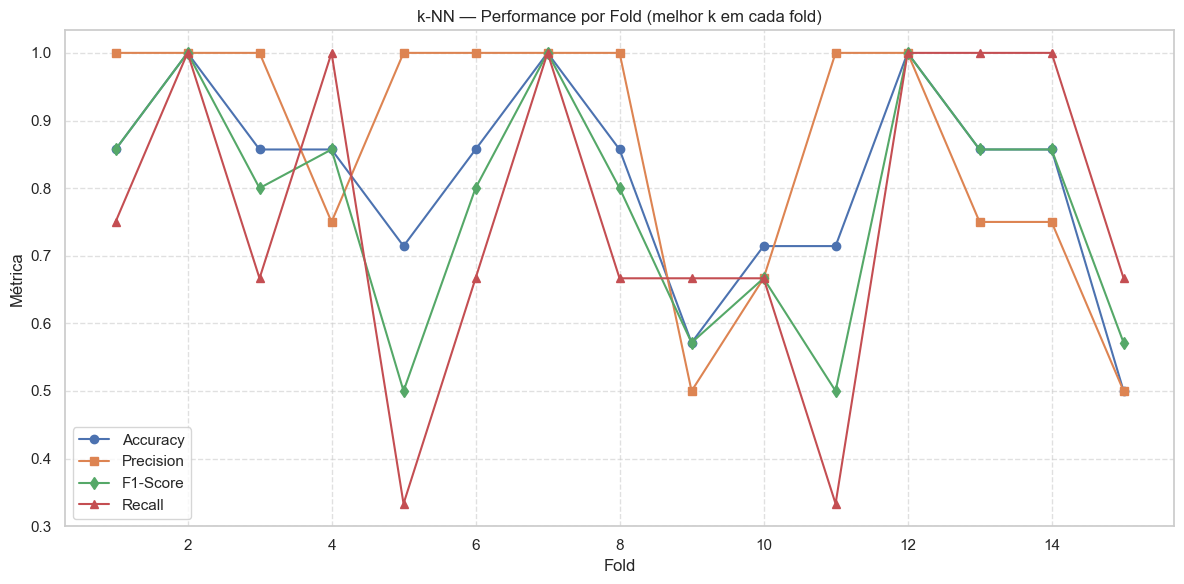

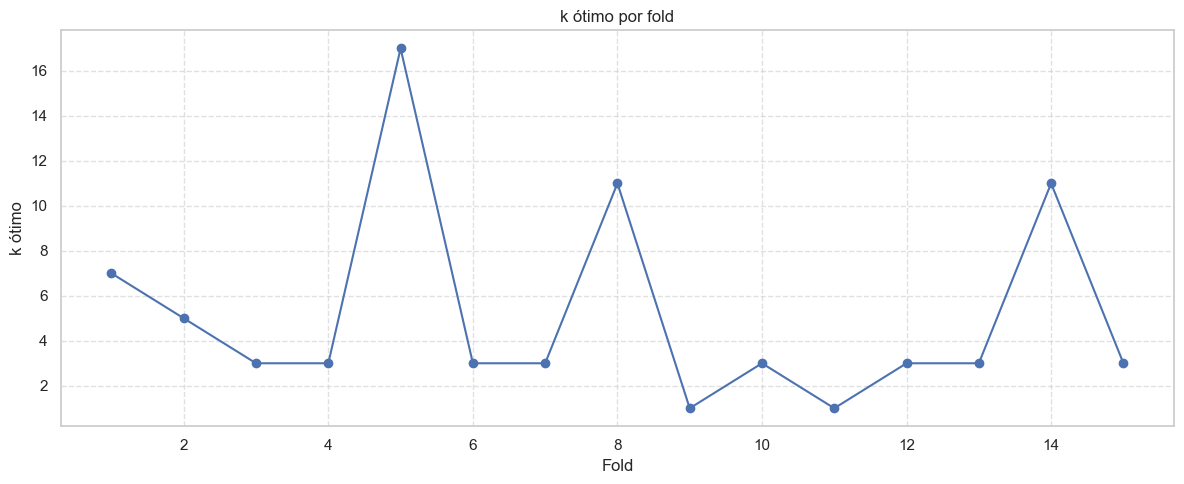

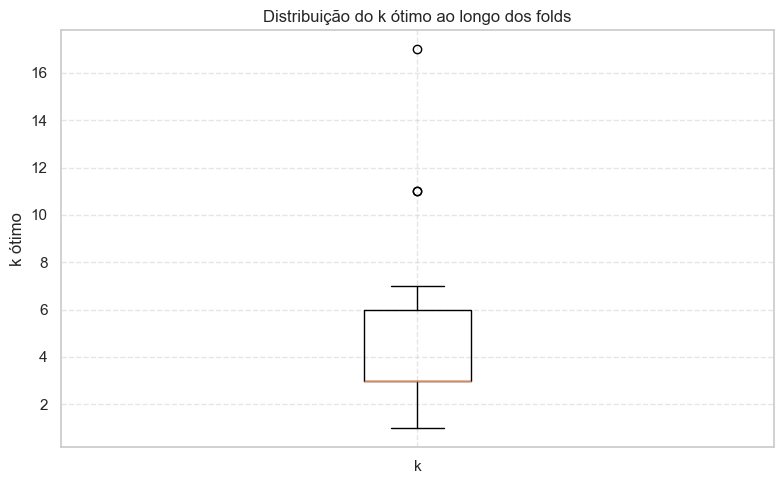

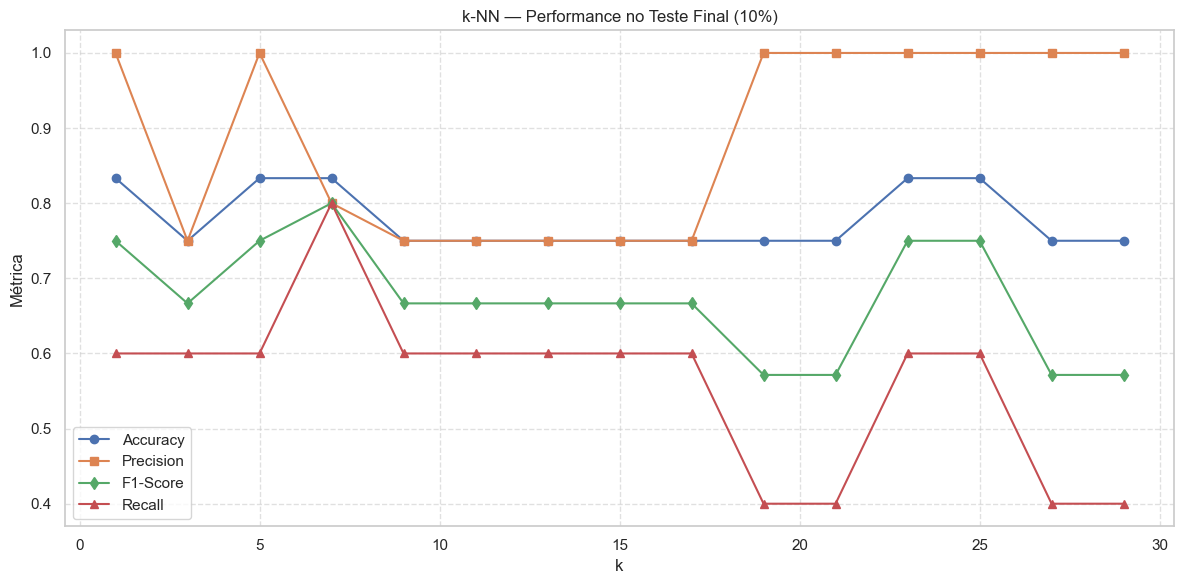


Erro final no teste (%) = 16.67%

Matriz de Confusão (teste final):
               Pred: Healthy  Pred: Cancer
True: Healthy              4             1
True: Cancer               1             6


In [17]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

X = data.drop(columns=["Classification"])
y = data["Classification"]

# Split final (10% para teste)
X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

features = ['Glucose', 'HOMA', 'Resistin', 'Insulin', 'Adiponectin', 'Age']
ks = np.arange(1, 30, 2)
n_folds = 15
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

allErrMat = np.zeros((n_folds, len(ks)))
metrics_by_fold = {"Accuracy": [], "Precision": [], "F1": [], "Recall": []}

# Lista para guardar o melhor k por fold
best_k_per_fold = []

# -------------------------
# FUNÇÃO KNN
# -------------------------
def k_NN(ks, X_train, X_val, y_train, y_val, best_features, fold, metrics_dict, isTrain=True):
    X_train = X_train[best_features].to_numpy()
    X_val = X_val[best_features].to_numpy()
    y_train = y_train.to_numpy()
    y_val = y_val.to_numpy()

    # Normalização com base no treino
    muTr = np.mean(X_train, axis=0)
    stdTr = np.std(X_train, axis=0)
    X_train_norm = (X_train - muTr) / stdTr
    X_val_norm = (X_val - muTr) / stdTr

    errMat = np.zeros(len(ks))

    for ki, k in enumerate(ks):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_norm, y_train)
        yp = knn.predict(X_val_norm)

        Acc = accuracy_score(y_val, yp)
        errMat[ki] = (1 - Acc) * 100

        if fold < 0:
            metrics_dict["Accuracy"].append(Acc)
            metrics_dict["Precision"].append(precision_score(y_val, yp, zero_division=0))
            metrics_dict["F1"].append(f1_score(y_val, yp, zero_division=0))
            metrics_dict["Recall"].append(recall_score(y_val, yp, zero_division=0))

    # Melhor k deste fold
    optK = ks[np.argmin(errMat)]

    if fold >= 0:
        allErrMat[fold, :] = errMat

        # Recalcular para métricas por fold
        knn = KNeighborsClassifier(n_neighbors=optK)
        knn.fit(X_train_norm, y_train)
        yp = knn.predict(X_val_norm)

        metrics_dict["Accuracy"].append(accuracy_score(y_val, yp))
        metrics_dict["Precision"].append(precision_score(y_val, yp, zero_division=0))
        metrics_dict["F1"].append(f1_score(y_val, yp, zero_division=0))
        metrics_dict["Recall"].append(recall_score(y_val, yp, zero_division=0))

    return optK


# -------------------------
# CROSS-VALIDATION
# -------------------------
for fold, (train_index, val_index) in enumerate(skf.split(X_train_full, y_train_full)):
    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

    print(f"\nFold {fold+1}")
    optK = k_NN(ks, X_train, X_val, y_train, y_val, features, fold, metrics_by_fold)
    best_k_per_fold.append(optK)

# -------------------------
# MELHOR K GLOBAL
# -------------------------
mean_k = np.mean(allErrMat, axis=0)
best_k = ks[np.argmin(mean_k)]
print(f"\nMelhor k médio dos folds: {best_k}")

# -------------------------
# GRÁFICO DAS MÉTRICAS POR FOLD
# -------------------------
plt.figure(figsize=(12,6))
folds = np.arange(1, n_folds+1)
plt.plot(folds, metrics_by_fold["Accuracy"], marker='o', label="Accuracy")
plt.plot(folds, metrics_by_fold["Precision"], marker='s', label="Precision")
plt.plot(folds, metrics_by_fold["F1"], marker='d', label="F1-Score")
plt.plot(folds, metrics_by_fold["Recall"], marker='^', label="Recall")
plt.title("k-NN — Performance por Fold (melhor k em cada fold)")
plt.xlabel("Fold")
plt.ylabel("Métrica")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# GRÁFICO DO k ótimo por fold
# -------------------------
plt.figure(figsize=(12,5))
plt.plot(folds, best_k_per_fold, marker='o')
plt.title("k ótimo por fold")
plt.xlabel("Fold")
plt.ylabel("k ótimo")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# -------------------------
# BOXPLOT DOS K OTIMOS
# -------------------------
plt.figure(figsize=(8,5))
plt.boxplot(best_k_per_fold, vert=True, labels=["k"])
plt.title("Distribuição do k ótimo ao longo dos folds")
plt.ylabel("k ótimo")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# -------------------------
# TESTE FINAL COM 10%
# -------------------------
metrics_for_test = {"Accuracy": [], "Precision": [], "F1": [], "Recall": []}

for k in ks:
    k_NN([k], X_train_full, X_test_final, y_train_full, y_test_final, features, fold=-1, metrics_dict=metrics_for_test, isTrain=False)

# -------------------------
# GRÁFICO DO TESTE FINAL
# -------------------------
plt.figure(figsize=(12,6))
plt.plot(ks, metrics_for_test["Accuracy"], marker='o', label="Accuracy")
plt.plot(ks, metrics_for_test["Precision"], marker='s', label="Precision")
plt.plot(ks, metrics_for_test["F1"], marker='d', label="F1-Score")
plt.plot(ks, metrics_for_test["Recall"], marker='^', label="Recall")
plt.title("k-NN — Performance no Teste Final (10%)")
plt.xlabel("k")
plt.ylabel("Métrica")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# TESTE FINAL COM MELHOR K
# -------------------------
X_train_full_np = X_train_full[features].to_numpy()
X_test_final_np = X_test_final[features].to_numpy()

muTr_full = np.mean(X_train_full_np, axis=0)
stdTr_full = np.std(X_train_full_np, axis=0)

X_train_full_norm = (X_train_full_np - muTr_full) / stdTr_full
X_test_final_norm = (X_test_final_np - muTr_full) / stdTr_full

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_full_norm, y_train_full)

yp = knn.predict(X_test_final_norm)

Acc = accuracy_score(y_test_final, yp)
Err = (1 - Acc) * 100
print(f"\nErro final no teste (%) = {Err:.2f}%")

# Matriz de confusão final
cm = confusion_matrix(y_test_final, yp)
class_labels = {1: "Healthy", 2: "Cancer"}

idx = [f"True: {class_labels[1]}", f"True: {class_labels[2]}"]
cols = [f"Pred: {class_labels[1]}", f"Pred: {class_labels[2]}"]

print("\nMatriz de Confusão (teste final):")
print(pd.DataFrame(cm, index=idx, columns=cols))


TREINO: 69
VALIDAÇÃO: 23
TESTE: 24

>>> Melhor k encontrado na validação: 1


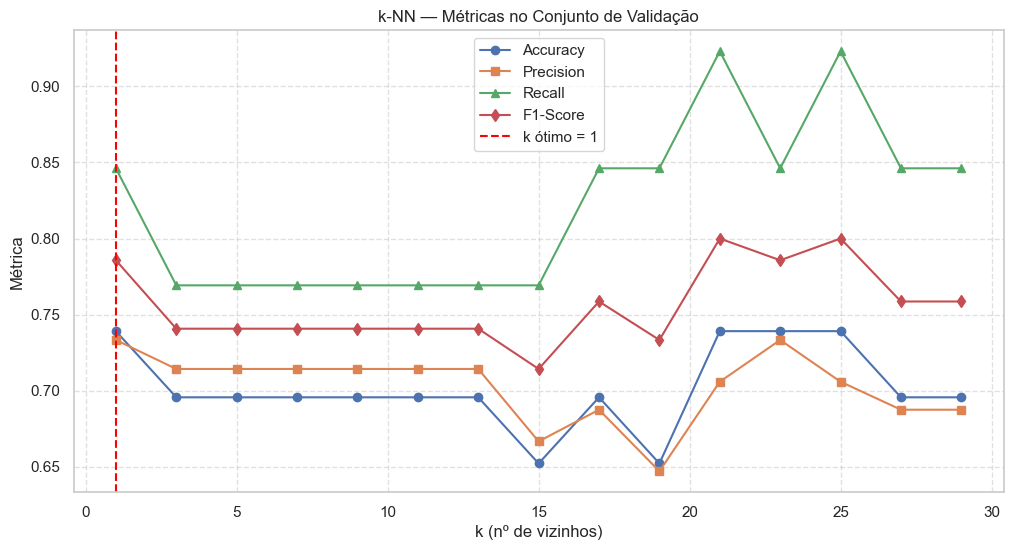


RESULTADOS FINAIS NO TESTE (20%):
Accuracy:  0.667
Precision: 0.692
Recall:    0.692
F1-Score:  0.692
AUC-ROC: 0.664


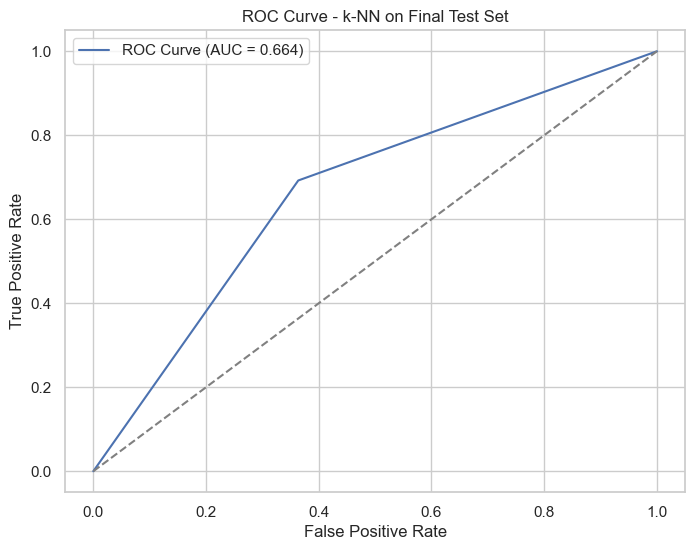


Matriz de Confusão (Teste Final):
                   Pred: Healthy (1)  Pred: Cancer (2)
True: Healthy (1)                  7                 4
True: Cancer (2)                   4                 9


In [18]:
X = data.drop(columns=["Classification"])
y = data["Classification"]

features = ['Glucose', 'HOMA', 'Resistin', 'Insulin', 'Adiponectin', 'Age']

# SEPARAÇÃO DOS DADOS: 60% TREINO, 20% VALIDAÇÃO, 20% TESTE
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Dos 80% restantes: 60% treino, 20% validação
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

print(f"TREINO: {len(X_train)}")
print(f"VALIDAÇÃO: {len(X_val)}")
print(f"TESTE: {len(X_test)}")


# NORMALIZAÇÃO
X_train_np = X_train[features].to_numpy()
X_val_np   = X_val[features].to_numpy()
X_test_np  = X_test[features].to_numpy()

mu = X_train_np.mean(axis=0)
std = X_train_np.std(axis=0)

X_train_norm = (X_train_np - mu) / std
X_val_norm   = (X_val_np   - mu) / std
X_test_norm  = (X_test_np  - mu) / std


ks = np.arange(1, 30, 2)  # valores ímpares de k

val_metrics = {"Acc": [], "Prec": [], "Rec": [], "F1": []}
val_errors = []

# TREINAR com X_train
# e VALIDAR em X_val (simulação de teste)
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_norm, y_train)

    y_pred_val = knn.predict(X_val_norm)

    acc  = accuracy_score(y_val, y_pred_val)
    prec = precision_score(y_val, y_pred_val, pos_label=2, zero_division=0)
    rec  = recall_score(y_val, y_pred_val, pos_label=2)
    f1   = f1_score(y_val, y_pred_val, pos_label=2)

    val_metrics["Acc"].append(acc)
    val_metrics["Prec"].append(prec)
    val_metrics["Rec"].append(rec)
    val_metrics["F1"].append(f1)

    # erro = 1 - accuracy
    val_errors.append(1 - acc)

# Melhor k
best_k = ks[np.argmin(val_errors)]
print(f"\n>>> Melhor k encontrado na validação: {best_k}")


# GRÁFICO DAS MÉTRICAS NA VALIDAÇÃO
plt.figure(figsize=(12,6))
plt.plot(ks, val_metrics["Acc"],  marker='o', label="Accuracy")
plt.plot(ks, val_metrics["Prec"], marker='s', label="Precision")
plt.plot(ks, val_metrics["Rec"],  marker='^', label="Recall")
plt.plot(ks, val_metrics["F1"],   marker='d', label="F1-Score")
plt.axvline(best_k, color="red", linestyle="--", label=f"k ótimo = {best_k}")
plt.title("k-NN — Métricas no Conjunto de Validação")
plt.xlabel("k (nº de vizinhos)")
plt.ylabel("Métrica")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


# Testar no TESTE FINAL (20%)
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_norm, y_train)

y_pred_test = best_knn.predict(X_test_norm)

test_acc  = accuracy_score(y_test, y_pred_test)
test_prec = precision_score(y_test, y_pred_test, pos_label=2, zero_division=0)
test_rec  = recall_score(y_test, y_pred_test, pos_label=2)
test_f1   = f1_score(y_test, y_pred_test, pos_label=2)

print("\nRESULTADOS FINAIS NO TESTE (20%):")
print(f"Accuracy:  {test_acc:.3f}")
print(f"Precision: {test_prec:.3f}")
print(f"Recall:    {test_rec:.3f}")
print(f"F1-Score:  {test_f1:.3f}")

# AUC ROC Curve
prob_scores = best_knn.predict_proba(X_test_norm)[:, 1]
from sklearn.metrics import roc_auc_score, roc_curve
auc_score = roc_auc_score(y_test, prob_scores)
fpr, tpr, thresholds = roc_curve(y_test, prob_scores, pos_label=2)
print(f"AUC-ROC: {auc_score:.3f}")
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve - k-NN on Final Test Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


# MATRIZ DE CONFUSÃO NO TESTE FINAL
cm = confusion_matrix(y_test, y_pred_test, labels=[1,2])

print("\nMatriz de Confusão (Teste Final):")
print(pd.DataFrame(
    cm,
    index=["True: Healthy (1)", "True: Cancer (2)"],
    columns=["Pred: Healthy (1)", "Pred: Cancer (2)"]
))


TREINO: 69
VALIDAÇÃO: 23
TESTE: 24

>>> Melhor k encontrado na validação: 11


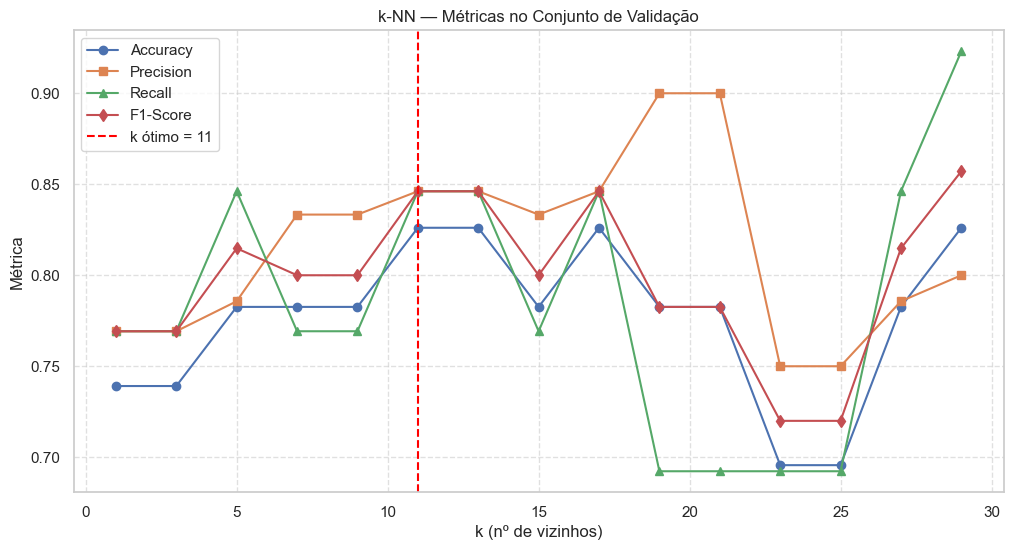


RESULTADOS FINAIS NO TESTE (20%):
Accuracy:  0.833
Precision: 0.800
Recall:    0.923
F1-Score:  0.857
AUC-ROC: 0.871


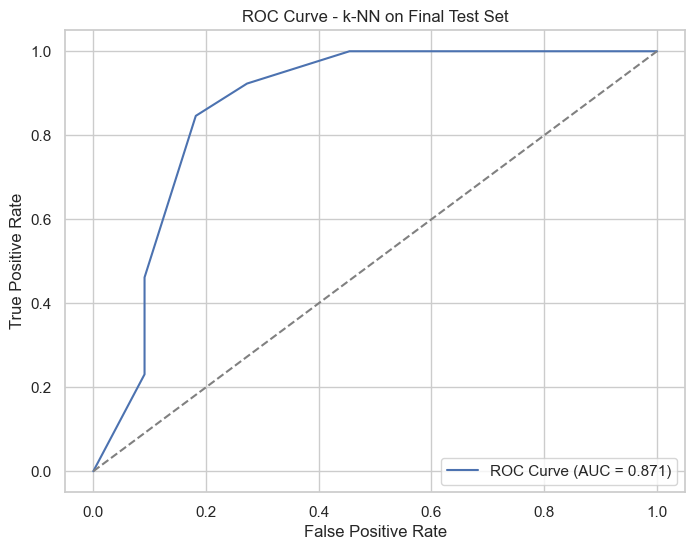


Matriz de Confusão (Teste Final):
                   Pred: Healthy (1)  Pred: Cancer (2)
True: Healthy (1)                  8                 3
True: Cancer (2)                   1                12


In [19]:
X = data.drop(columns=["Classification"])
y = data["Classification"]

features = ['Glucose','Resistin', 'BMI', 'Age']

# SEPARAÇÃO DOS DADOS: 60% TREINO, 20% VALIDAÇÃO, 20% TESTE
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Dos 80% restantes: 60% treino, 20% validação
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

print(f"TREINO: {len(X_train)}")
print(f"VALIDAÇÃO: {len(X_val)}")
print(f"TESTE: {len(X_test)}")


# NORMALIZAÇÃO — APENAS USANDO O TREINO (SEM LEAKAGE)
X_train_np = X_train[features].to_numpy()
X_val_np   = X_val[features].to_numpy()
X_test_np  = X_test[features].to_numpy()

mu = X_train_np.mean(axis=0)
std = X_train_np.std(axis=0)

X_train_norm = (X_train_np - mu) / std
X_val_norm   = (X_val_np   - mu) / std
X_test_norm  = (X_test_np  - mu) / std


# 3) FASE DE VALIDAÇÃO — TESTAR VÁRIOS k E ESCOLHER O MELHOR
ks = np.arange(1, 30, 2)  # valores ímpares de k

val_metrics = {"Acc": [], "Prec": [], "Rec": [], "F1": []}
val_errors = []

# Aqui estamos a TREINAR com X_train
# e a VALIDAR em X_val (simulação de teste)
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_norm, y_train)

    y_pred_val = knn.predict(X_val_norm)

    acc  = accuracy_score(y_val, y_pred_val)
    prec = precision_score(y_val, y_pred_val, pos_label=2, zero_division=0)
    rec  = recall_score(y_val, y_pred_val, pos_label=2)
    f1   = f1_score(y_val, y_pred_val, pos_label=2)

    val_metrics["Acc"].append(acc)
    val_metrics["Prec"].append(prec)
    val_metrics["Rec"].append(rec)
    val_metrics["F1"].append(f1)

    # erro = 1 - accuracy
    val_errors.append(1 - acc)

# Melhor k
best_k = ks[np.argmin(val_errors)]
print(f"\n>>> Melhor k encontrado na validação: {best_k}")


# GRÁFICO DAS MÉTRICAS NA VALIDAÇÃO
plt.figure(figsize=(12,6))
plt.plot(ks, val_metrics["Acc"],  marker='o', label="Accuracy")
plt.plot(ks, val_metrics["Prec"], marker='s', label="Precision")
plt.plot(ks, val_metrics["Rec"],  marker='^', label="Recall")
plt.plot(ks, val_metrics["F1"],   marker='d', label="F1-Score")
plt.axvline(best_k, color="red", linestyle="--", label=f"k ótimo = {best_k}")
plt.title("k-NN — Métricas no Conjunto de Validação")
plt.xlabel("k (nº de vizinhos)")
plt.ylabel("Métrica")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


# Testar no TESTE FINAL (20%)
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_norm, y_train)

y_pred_test = best_knn.predict(X_test_norm)

test_acc  = accuracy_score(y_test, y_pred_test)
test_prec = precision_score(y_test, y_pred_test, pos_label=2, zero_division=0)
test_rec  = recall_score(y_test, y_pred_test, pos_label=2)
test_f1   = f1_score(y_test, y_pred_test, pos_label=2)

print("\nRESULTADOS FINAIS NO TESTE (20%):")
print(f"Accuracy:  {test_acc:.3f}")
print(f"Precision: {test_prec:.3f}")
print(f"Recall:    {test_rec:.3f}")
print(f"F1-Score:  {test_f1:.3f}")

prob_scores = best_knn.predict_proba(X_test_norm)[:, 1]
from sklearn.metrics import roc_auc_score, roc_curve
auc_score = roc_auc_score(y_test, prob_scores)
fpr, tpr, thresholds = roc_curve(y_test, prob_scores, pos_label=2)
print(f"AUC-ROC: {auc_score:.3f}")
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve - k-NN on Final Test Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# MATRIZ DE CONFUSÃO NO TESTE FINAL
cm = confusion_matrix(y_test, y_pred_test, labels=[1,2])

print("\nMatriz de Confusão (Teste Final):")
print(pd.DataFrame(
    cm,
    index=["True: Healthy (1)", "True: Cancer (2)"],
    columns=["Pred: Healthy (1)", "Pred: Cancer (2)"]
))


Shapes -> Train: (69, 4), Val: (23, 4), Test: (24, 4)

Best k by CV (on training set): 9
CV mean (best): 0.7428571428571429 std: 0.13767382333854558

Validation metrics (head):
   accuracy  precision    recall        f1
k                                         
1  0.695652   0.750000  0.692308  0.720000
3  0.739130   0.818182  0.692308  0.750000
5  0.826087   1.000000  0.692308  0.818182
7  0.739130   1.000000  0.538462  0.700000
9  0.782609   1.000000  0.615385  0.761905

Best k by independent validation: 17
Validation score (best): 0.7692307692307693

FINAL chosen k = 17


Final Test Results (Train -> Test):
k = 17
Accuracy : 0.750
Precision: 0.769
Recall   : 0.769
F1-score : 0.769

Confusion matrix (rows=true, cols=pred):
 [[ 8  3]
 [ 3 10]]

Classification report:
               precision    recall  f1-score   support

           1     0.7273    0.7273    0.7273        11
           2     0.7692    0.7692    0.7692        13

    accuracy                         0.7500        24
 

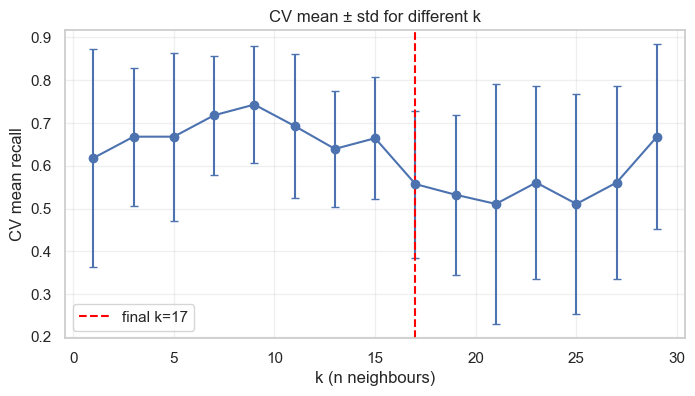

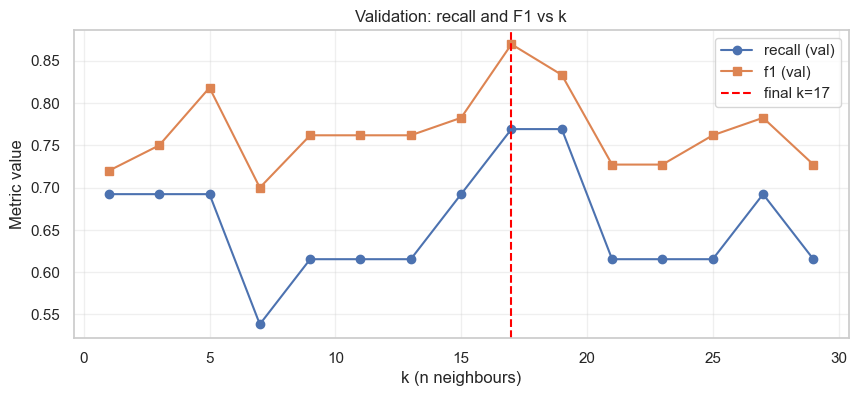

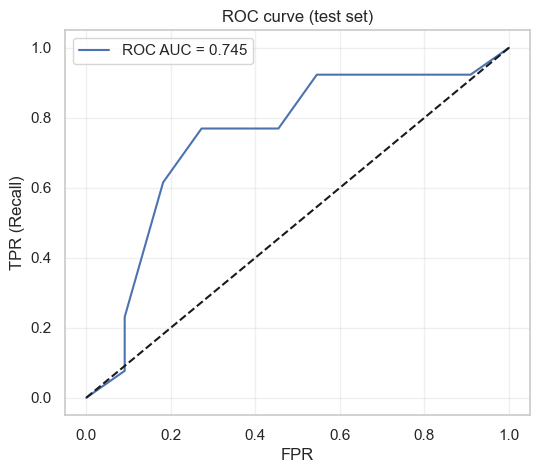


Summary:
              step      value
0       best_k_cv   9.000000
1      best_k_val  17.000000
2        chosen_k  17.000000
3   test_accuracy   0.750000
4  test_precision   0.769231
5     test_recall   0.769231
6         test_f1   0.769231


In [20]:
# k-NN robusto para o teu projeto — 60/20/20, seleção de k e avaliação final
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)


random_state = 42

sel_features = ['Glucose', 'HOMA', 'BMI', 'Resistin']
# Métrica que vamos priorizar na seleção de k: 'recall' ou 'f1'
selection_metric = 'recall'   
# Valores de k a testar (ímpar para evitar empates)
ks = list(range(1, 30, 2))

n_cv_folds = 5

# Preparar dados e split 60/20/20
X = data[sel_features].to_numpy()
y = data['Classification'].to_numpy()

# 60% treino, 40% temporário
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, stratify=y, random_state=random_state
)
# dividir os 40% restantes em 20% val + 20% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=random_state
)

print(f"Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Normalização (fit apenas com treino)
scaler = StandardScaler()
X_train_n = scaler.fit_transform(X_train)
X_val_n   = scaler.transform(X_val)
X_test_n  = scaler.transform(X_test)

# Seleção de k: 2 passos robustos
#    avaliar via CV dentro do treino para estabilidade
#    confirmar / escolher com base na validação independente
# avaliação por CV nos dados de treino
skf = StratifiedKFold(n_splits=n_cv_folds, shuffle=True, random_state=random_state)

cv_scores = {k: [] for k in ks}

for k in ks:
    for train_idx, test_idx in skf.split(X_train_n, y_train):
        Xt = X_train_n[train_idx]
        Xv = X_train_n[test_idx]
        yt = y_train[train_idx]
        yv = y_train[test_idx]

        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(Xt, yt)
        yp = model.predict(Xv)

        if selection_metric == 'recall':
            score = recall_score(yv, yp, pos_label=2, zero_division=0)
        else:
            score = f1_score(yv, yp, pos_label=2, zero_division=0)

        cv_scores[k].append(score)

# média e desvio-padrão CV
cv_mean = {k: np.mean(cv_scores[k]) for k in ks}
cv_std  = {k: np.std(cv_scores[k])  for k in ks}

# escolher melhor k por CV
best_k_cv = max(cv_mean.items(), key=lambda x: (x[1], -x[0]))[0]
print("\nBest k by CV (on training set):", best_k_cv)
print("CV mean (best):", cv_mean[best_k_cv], "std:", cv_std[best_k_cv])

# avaliar todos os ks no conjunto de validação (independente)
val_metrics = []
for k in ks:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_n, y_train)
    yp_val = model.predict(X_val_n)

    acc = accuracy_score(y_val, yp_val)
    prec = precision_score(y_val, yp_val, pos_label=2, zero_division=0)
    rec = recall_score(y_val, yp_val, pos_label=2, zero_division=0)
    f1 = f1_score(y_val, yp_val, pos_label=2, zero_division=0)

    val_metrics.append({'k': k, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1})

val_df = pd.DataFrame(val_metrics).set_index('k')
print("\nValidation metrics (head):")
print(val_df.head())

# escolher melhor k segundo validação (priorizando selection_metric)
if selection_metric == 'recall':
    best_k_val = val_df['recall'].idxmax()
else:
    best_k_val = val_df['f1'].idxmax()

print("\nBest k by independent validation:", best_k_val)
print("Validation score (best):", val_df.loc[best_k_val, selection_metric])


best_k = best_k_val
print("\nFINAL chosen k =", best_k)

# Treinar modelo final em Train com best_k e avaliar no Teste
final_model = KNeighborsClassifier(n_neighbors=best_k)
final_model.fit(X_train_n, y_train)

# Avaliar no teste
y_test_pred = final_model.predict(X_test_n)

test_acc  = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred, pos_label=2, zero_division=0)
test_rec  = recall_score(y_test, y_test_pred, pos_label=2, zero_division=0)
test_f1   = f1_score(y_test, y_test_pred, pos_label=2, zero_division=0)
test_cm   = confusion_matrix(y_test, y_test_pred, labels=[1,2])

print("\n\nFinal Test Results (Train -> Test):")
print(f"k = {best_k}")
print(f"Accuracy : {test_acc:.3f}")
print(f"Precision: {test_prec:.3f}")
print(f"Recall   : {test_rec:.3f}")
print(f"F1-score : {test_f1:.3f}")
print("\nConfusion matrix (rows=true, cols=pred):\n", test_cm)
print("\nClassification report:\n", classification_report(y_test, y_test_pred, digits=4))

# Gráficos para relatório
#    CV mean ± std vs k
#    Validation metrics vs k (recall/f1)
#    ROC curve on test (probabilities from kNN -> use predict_proba)
# CV plot
ks_list = sorted(ks)
cv_means = [cv_mean[k] for k in ks_list]
cv_stds  = [cv_std[k]  for k in ks_list]

plt.figure(figsize=(8,4))
plt.errorbar(ks_list, cv_means, yerr=cv_stds, marker='o', capsize=3)
plt.axvline(best_k, color='red', linestyle='--', label=f'final k={best_k}')
plt.xlabel('k (n neighbours)')
plt.ylabel(f'CV mean {selection_metric}')
plt.title('CV mean ± std for different k')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Validation metrics plot (Recall and F1)
plt.figure(figsize=(10,4))
plt.plot(val_df.index, val_df['recall'], marker='o', label='recall (val)')
plt.plot(val_df.index, val_df['f1'], marker='s', label='f1 (val)')
plt.axvline(best_k, color='red', linestyle='--', label=f'final k={best_k}')
plt.xlabel('k (n neighbours)')
plt.ylabel('Metric value')
plt.title('Validation: recall and F1 vs k')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ROC curve on test (if predict_proba available)
if hasattr(final_model, "predict_proba"):
    y_score = final_model.predict_proba(X_test_n)[:, 1]  # prob for class 2
    try:
        auc = roc_auc_score((y_test == 2).astype(int), y_score)
        fpr, tpr, _ = roc_curve((y_test == 2).astype(int), y_score)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f'ROC AUC = {auc:.3f}')
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel('FPR')
        plt.ylabel('TPR (Recall)')
        plt.title('ROC curve (test set)')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()
    except Exception as e:
        print("ROC/AUC error:", e)
else:
    print("\nFinal model does not support predict_proba (k-NN normally supports it).")

# Guardar resultados resumidos (DataFrame)
summary = {
    'step': ['best_k_cv', 'best_k_val', 'chosen_k', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1'],
    'value': [best_k_cv, best_k_val, best_k, test_acc, test_prec, test_rec, test_f1]
}
summary_df = pd.DataFrame(summary)
print("\nSummary:\n", summary_df)


Shapes -> Train: (69, 4), Val: (23, 4), Test: (24, 4)

Best k by CV (on training set): 29
CV mean (best): 0.95 std: 0.06123724356957946

Validation metrics (head):
   accuracy  precision    recall        f1
k                                         
1  0.826087   0.800000  0.923077  0.857143
3  0.739130   0.733333  0.846154  0.785714
5  0.739130   0.769231  0.769231  0.769231
7  0.782609   0.833333  0.769231  0.800000
9  0.782609   0.833333  0.769231  0.800000

Best k by independent validation: 1
Validation score (best): 0.9230769230769231

FINAL chosen k = 1


Final Test Results (Train -> Test):
k = 1
Accuracy : 0.792
Precision: 0.786
Recall   : 0.846
F1-score : 0.815

Confusion matrix (rows=true, cols=pred):
 [[ 8  3]
 [ 2 11]]

Classification report:
               precision    recall  f1-score   support

           1     0.8000    0.7273    0.7619        11
           2     0.7857    0.8462    0.8148        13

    accuracy                         0.7917        24
   macro avg     

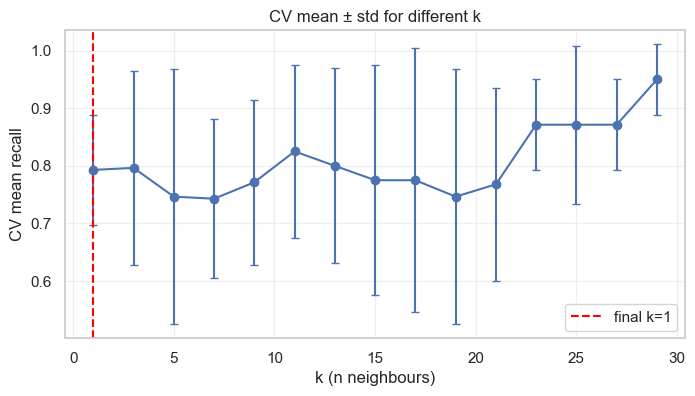

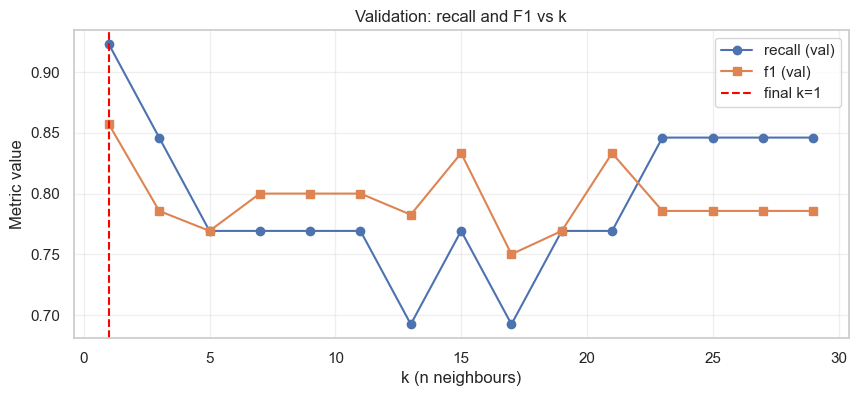

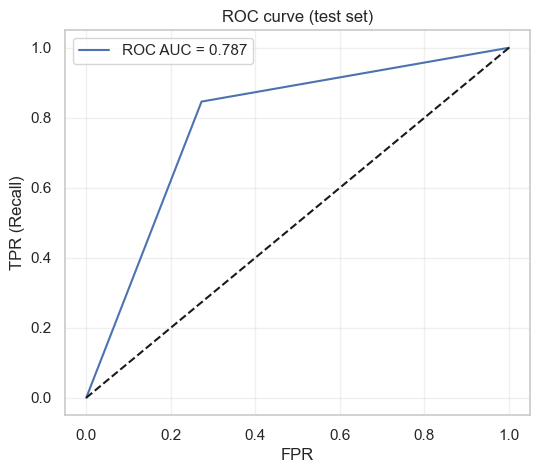


Summary:
              step      value
0       best_k_cv  29.000000
1      best_k_val   1.000000
2        chosen_k   1.000000
3   test_accuracy   0.791667
4  test_precision   0.785714
5     test_recall   0.846154
6         test_f1   0.814815


In [21]:
# k-NN robusto para o teu projeto — 60/20/20, seleção de k e avaliação final
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)


random_state = 42
sel_features = ['Glucose', 'BMI','Resistin', 'Age']

# Métrica que vamos priorizar na seleção de k: 'recall' ou 'f1'
selection_metric = 'recall'

ks = list(range(1, 30, 2))

n_cv_folds = 5

# Preparar dados e split 60/20/20
X = data[sel_features].to_numpy()
y = data['Classification'].to_numpy()

# 60% treino, 40% temporário
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, stratify=y, random_state=random_state
)
# dividir os 40% restantes em 20% val + 20% test (i.e., metade do temporary)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=random_state
)

print(f"Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Normalização (fit apenas com treino)
scaler = StandardScaler()
X_train_n = scaler.fit_transform(X_train)
X_val_n   = scaler.transform(X_val)
X_test_n  = scaler.transform(X_test)

# Seleção de k: 2 passos robustos
#    avaliar via CV dentro do treino para estabilidade
#    confirmar / escolher com base na validação independente
# avaliação por CV nos dados de treino
skf = StratifiedKFold(n_splits=n_cv_folds, shuffle=True, random_state=random_state)

cv_scores = {k: [] for k in ks}

for k in ks:
    for train_idx, test_idx in skf.split(X_train_n, y_train):
        Xt = X_train_n[train_idx]
        Xv = X_train_n[test_idx]
        yt = y_train[train_idx]
        yv = y_train[test_idx]

        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(Xt, yt)
        yp = model.predict(Xv)

        if selection_metric == 'recall':
            score = recall_score(yv, yp, pos_label=2, zero_division=0)
        else:
            score = f1_score(yv, yp, pos_label=2, zero_division=0)

        cv_scores[k].append(score)

# média e desvio-padrão CV
cv_mean = {k: np.mean(cv_scores[k]) for k in ks}
cv_std  = {k: np.std(cv_scores[k])  for k in ks}

# escolher melhor k por CV
best_k_cv = max(cv_mean.items(), key=lambda x: (x[1], -x[0]))[0]
print("\nBest k by CV (on training set):", best_k_cv)
print("CV mean (best):", cv_mean[best_k_cv], "std:", cv_std[best_k_cv])

# avaliar todos os ks no conjunto de validação (independente)
val_metrics = []
for k in ks:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_n, y_train)
    yp_val = model.predict(X_val_n)

    acc = accuracy_score(y_val, yp_val)
    prec = precision_score(y_val, yp_val, pos_label=2, zero_division=0)
    rec = recall_score(y_val, yp_val, pos_label=2, zero_division=0)
    f1 = f1_score(y_val, yp_val, pos_label=2, zero_division=0)

    val_metrics.append({'k': k, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1})

val_df = pd.DataFrame(val_metrics).set_index('k')
print("\nValidation metrics (head):")
print(val_df.head())

# escolher melhor k segundo validação (priorizando selection_metric)
if selection_metric == 'recall':
    best_k_val = val_df['recall'].idxmax()
else:
    best_k_val = val_df['f1'].idxmax()

print("\nBest k by independent validation:", best_k_val)
print("Validation score (best):", val_df.loc[best_k_val, selection_metric])


best_k = best_k_val
print("\nFINAL chosen k =", best_k)

# Treinar modelo final em Train com best_k e avaliar no Teste
final_model = KNeighborsClassifier(n_neighbors=best_k)
final_model.fit(X_train_n, y_train)

# Avaliar no teste
y_test_pred = final_model.predict(X_test_n)

test_acc  = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred, pos_label=2, zero_division=0)
test_rec  = recall_score(y_test, y_test_pred, pos_label=2, zero_division=0)
test_f1   = f1_score(y_test, y_test_pred, pos_label=2, zero_division=0)
test_cm   = confusion_matrix(y_test, y_test_pred, labels=[1,2])

print("\n\nFinal Test Results (Train -> Test):")
print(f"k = {best_k}")
print(f"Accuracy : {test_acc:.3f}")
print(f"Precision: {test_prec:.3f}")
print(f"Recall   : {test_rec:.3f}")
print(f"F1-score : {test_f1:.3f}")
print("\nConfusion matrix (rows=true, cols=pred):\n", test_cm)
print("\nClassification report:\n", classification_report(y_test, y_test_pred, digits=4))

# Gráficos para relatório
#    CV mean ± std vs k
#    Validation metrics vs k (recall/f1)
#    ROC curve on test (probabilities from kNN -> use predict_proba)
# CV plot
ks_list = sorted(ks)
cv_means = [cv_mean[k] for k in ks_list]
cv_stds  = [cv_std[k]  for k in ks_list]

plt.figure(figsize=(8,4))
plt.errorbar(ks_list, cv_means, yerr=cv_stds, marker='o', capsize=3)
plt.axvline(best_k, color='red', linestyle='--', label=f'final k={best_k}')
plt.xlabel('k (n neighbours)')
plt.ylabel(f'CV mean {selection_metric}')
plt.title('CV mean ± std for different k')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Validation metrics plot (Recall and F1)
plt.figure(figsize=(10,4))
plt.plot(val_df.index, val_df['recall'], marker='o', label='recall (val)')
plt.plot(val_df.index, val_df['f1'], marker='s', label='f1 (val)')
plt.axvline(best_k, color='red', linestyle='--', label=f'final k={best_k}')
plt.xlabel('k (n neighbours)')
plt.ylabel('Metric value')
plt.title('Validation: recall and F1 vs k')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ROC curve on test (if predict_proba available)
if hasattr(final_model, "predict_proba"):
    y_score = final_model.predict_proba(X_test_n)[:, 1]  # prob for class 2
    try:
        auc = roc_auc_score((y_test == 2).astype(int), y_score)
        fpr, tpr, _ = roc_curve((y_test == 2).astype(int), y_score)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f'ROC AUC = {auc:.3f}')
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel('FPR')
        plt.ylabel('TPR (Recall)')
        plt.title('ROC curve (test set)')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()
    except Exception as e:
        print("ROC/AUC error:", e)
else:
    print("\nFinal model does not support predict_proba (k-NN normally supports it).")

# Guardar resultados resumidos (DataFrame)
summary = {
    'step': ['best_k_cv', 'best_k_val', 'chosen_k', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1'],
    'value': [best_k_cv, best_k_val, best_k, test_acc, test_prec, test_rec, test_f1]
}
summary_df = pd.DataFrame(summary)
print("\nSummary:\n", summary_df)


Foram realizados vários testes usando o classificador k-NN, explorando diferentes conjuntos de features:
<br>• ['Glucose', 'BMI', 'Resistin', 'Age']
<br>• ['Glucose', 'BMI', 'Resistin', 'HOMA']
<br>• ['Glucose', 'HOMA', 'Resistin', 'Insulin', 'Adiponectin', 'Age']

A divisão dos dados em treino, validação e teste revelou-se fundamental, dado que o k-NN depende do hiperparâmetro k, cuja escolha influencia diretamente o desempenho do modelo. A utilização de validação independente permitiu selecionar o valor de k de forma robusta, enquanto a avaliação final no conjunto de teste assegurou que esta escolha não foi afetada por sobreajuste ao treino.

A normalização mostrou-se igualmente essencial, uma vez que o k-NN é um classificador baseado em distâncias. Variáveis com escalas muito distintas — como Glucose, Insulin, Resistin ou HOMA, que podem variar em ordens de grandeza diferentes — tenderiam a dominar o cálculo das distâncias caso não fossem padronizadas. A normalização colocou todas as features na mesma ordem de magnitude, garantindo que nenhuma variável influenciasse de forma desproporcional o resultado do classificador.

De um modo geral, o k-NN apresentou um desempenho sólido no problema de deteção de cancro da mama, com boa sensibilidade e equilíbrio entre as restantes métricas. A seleção adequada de k através da validação foi determinante para a eficácia do modelo. Embora não seja o algoritmo mais sofisticado testado, o seu desempenho foi consistente e alinhado com o esperado para um dataset de dimensão reduzida como o utilizado.


### Classificador de Bayes


CLASSIFICADOR DE BAYES: 
Accuracy: 0.686
Precision: 0.609
Recall: 0.875
F1-Score: 0.718

Confusion Matrix:
 [[14  2]
 [ 9 10]]
              precision    recall  f1-score   support

           1     0.6087    0.8750    0.7179        16
           2     0.8333    0.5263    0.6452        19

    accuracy                         0.6857        35
   macro avg     0.7210    0.7007    0.6816        35
weighted avg     0.7306    0.6857    0.6784        35


Bayes Error (%): 31.43%
AUC: 0.8289


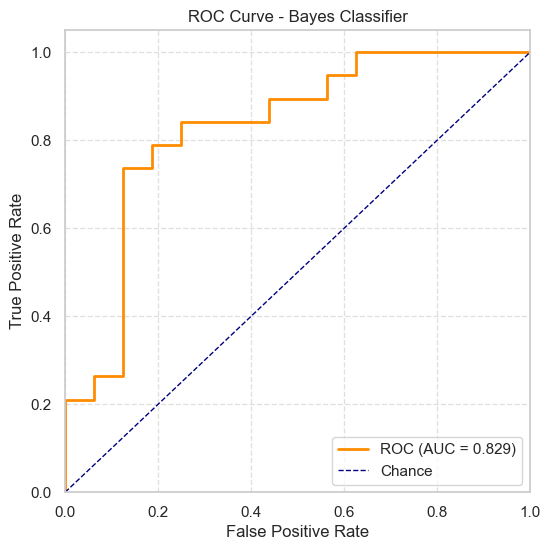

In [22]:
from sklearn import mixture
from sklearn.metrics import roc_curve, auc

def pdfGauss(X,mean,cov):
    covInv=np.linalg.inv(cov)
    dim=cov.shape[0]
    val=np.array([])
    for i in range(X.shape[0]):
        dist=((np.array([X[i,:]-mean]))@covInv@(np.array([X[i,:]-mean])).T).squeeze()
        val=np.append(val,np.exp(-0.5*dist)/((2*np.pi)**(dim/2)*np.linalg.det(cov)**0.5))
    return np.array([val]).T


def fitBayes(Xtr, ytr):
    ix1 = np.where(ytr == 1)[0]
    ix2 = np.where(ytr == 2)[0]

    Pw1=ix1.shape[0]/(ix1.shape[0]+ix2.shape[0])
    Pw2=ix2.shape[0]/(ix1.shape[0]+ix2.shape[0])

    g1 = mixture.GaussianMixture(n_components=1).fit(Xtr[ix1, :])
    g2 = mixture.GaussianMixture(n_components=1).fit(Xtr[ix2, :])

    return {
        "mean1": g1.means_.squeeze(),
        "mean2": g2.means_.squeeze(),
        "cov1": g1.covariances_[0],
        "cov2": g2.covariances_[0],
        "Pw1": Pw1,
        "Pw2": Pw2
    }


def useBayes(Xte, model):
    Pw1X = pdfGauss(Xte, model["mean1"], model["cov1"]) * model["Pw1"]
    Pw2X = pdfGauss(Xte, model["mean2"], model["cov2"]) * model["Pw2"]

    post = np.concatenate([Pw1X, Pw2X], axis=1)
    preds = np.argmax(post, axis=1) + 1
    return preds

# Selecionar features
top_4 = ['Glucose', 'HOMA', 'BMI', 'Resistin']

X = data[top_4].to_numpy()
y = data["Classification"].to_numpy()

N_RUNS = 20
results = []

accs, precs, recs, f1s = [], [], [], []


for seed in range(N_RUNS):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=seed
    )

    # Normalização
    mu = X_train.mean(axis=0)
    std = X_train.std(axis=0)

    X_train_n = (X_train - mu) / std
    X_test_n = (X_test - mu) / std

    model = fitBayes(X_train_n, y_train)

    # Teste
    yp = useBayes(X_test_n, model)

    acc = accuracy_score(y_test, yp)
    prec = precision_score(y_test, yp)
    rec = recall_score(y_test, yp)
    f1 = f1_score(y_test, yp)

    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)

cm = confusion_matrix(y_test, yp)
print("\nCLASSIFICADOR DE BAYES: ")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-Score: {f1:.3f}")
print("\nConfusion Matrix:\n", cm)
print(classification_report(y_test, yp, digits=4))

# AUC / ROC curve for the Bayes model
Pw1X = pdfGauss(X_test_n, model["mean1"], model["cov1"]) * model["Pw1"]
Pw2X = pdfGauss(X_test_n, model["mean2"], model["cov2"]) * model["Pw2"]
probs = (Pw2X / (Pw1X + Pw2X)).ravel()  # posterior prob for class 2

fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=2)
roc_auc = auc(fpr, tpr)

print(f"\nBayes Error (%): {(1-acc)*100:.2f}%")
print(f"AUC: {roc_auc:.4f}")

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Bayes Classifier')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



CLASSIFICADOR DE BAYES: 
Accuracy: 0.714
Precision: 0.688
Recall: 0.688
F1-Score: 0.688

Confusion Matrix:
 [[11  5]
 [ 5 14]]

Bayes Error (%): 28.57%
AUC: 0.7796


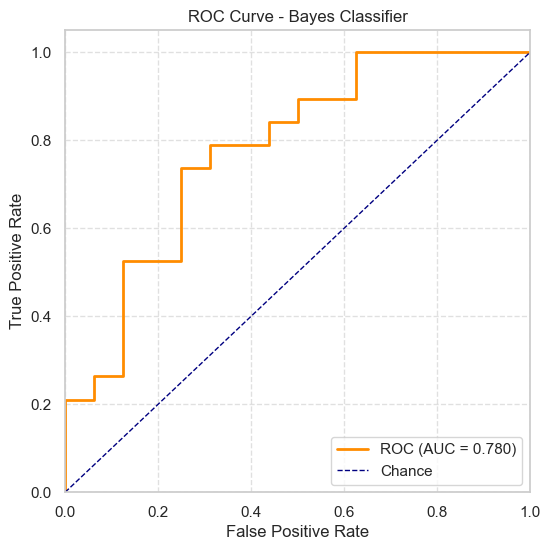

In [23]:
from sklearn import mixture
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def pdfGauss(X,mean,cov):
    covInv=np.linalg.inv(cov)
    dim=cov.shape[0]
    val=np.array([])
    for i in range(X.shape[0]):
        dist=((np.array([X[i,:]-mean]))@covInv@(np.array([X[i,:]-mean])).T).squeeze()
        val=np.append(val,np.exp(-0.5*dist)/((2*np.pi)**(dim/2)*np.linalg.det(cov)**0.5))
    return np.array([val]).T


def fitBayes(Xtr, ytr):
    ix1 = np.where(ytr == 1)[0]
    ix2 = np.where(ytr == 2)[0]

    Pw1=ix1.shape[0]/(ix1.shape[0]+ix2.shape[0])
    Pw2=ix2.shape[0]/(ix1.shape[0]+ix2.shape[0])

    g1 = mixture.GaussianMixture(n_components=1).fit(Xtr[ix1, :])
    g2 = mixture.GaussianMixture(n_components=1).fit(Xtr[ix2, :])

    return {
        "mean1": g1.means_.squeeze(),
        "mean2": g2.means_.squeeze(),
        "cov1": g1.covariances_[0],
        "cov2": g2.covariances_[0],
        "Pw1": Pw1,
        "Pw2": Pw2
    }


def useBayes(Xte, model):
    Pw1X = pdfGauss(Xte, model["mean1"], model["cov1"]) * model["Pw1"]
    Pw2X = pdfGauss(Xte, model["mean2"], model["cov2"]) * model["Pw2"]

    post = np.concatenate([Pw1X, Pw2X], axis=1)
    preds = np.argmax(post, axis=1) + 1
    return preds

# Selecionar features
features = ['Glucose', 'HOMA', 'BMI', 'Resistin', 'Adiponectin', 'Age']

X = data[features].to_numpy()
y = data["Classification"].to_numpy()


N_RUNS = 20
results = []

accs, precs, recs, f1s = [], [], [], []

for seed in range(N_RUNS):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=seed
    )
    
    # Normalização só com treino
    mu = X_train.mean(axis=0)
    std = X_train.std(axis=0)

    X_train_n = (X_train - mu) / std
    X_test_n = (X_test - mu) / std

    model = fitBayes(X_train_n, y_train)

    # Teste
    yp = useBayes(X_test_n, model)

    acc = accuracy_score(y_test, yp)
    prec = precision_score(y_test, yp)
    rec = recall_score(y_test, yp)
    f1 = f1_score(y_test, yp)

    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)

cm = confusion_matrix(y_test, yp)
print("\nCLASSIFICADOR DE BAYES: ")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-Score: {f1:.3f}")
print("\nConfusion Matrix:\n", cm)

# AUC / ROC curve for the Bayes model
Pw1X = pdfGauss(X_test_n, model["mean1"], model["cov1"]) * model["Pw1"]
Pw2X = pdfGauss(X_test_n, model["mean2"], model["cov2"]) * model["Pw2"]
probs = (Pw2X / (Pw1X + Pw2X)).ravel()  # posterior prob for class 2

fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=2)
roc_auc = auc(fpr, tpr)

print(f"\nBayes Error (%): {(1-acc)*100:.2f}%")
print(f"AUC: {roc_auc:.4f}")

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Bayes Classifier')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



CLASSIFICADOR DE BAYES: 
Accuracy: 0.723
Precision: 0.682
Recall: 0.714
F1-Score: 0.698

Confusion Matrix:
 [[15  6]
 [ 7 19]]
              precision    recall  f1-score   support

           1     0.6818    0.7143    0.6977        21
           2     0.7600    0.7308    0.7451        26

    accuracy                         0.7234        47
   macro avg     0.7209    0.7225    0.7214        47
weighted avg     0.7251    0.7234    0.7239        47


Bayes Error (%): 27.66%
AUC: 0.7582


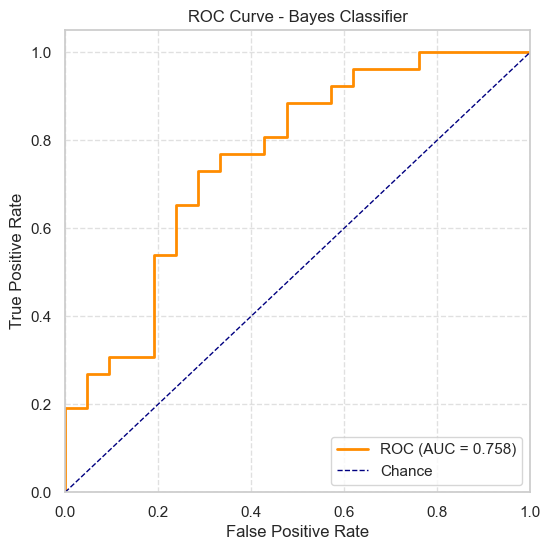

In [24]:
from sklearn import mixture
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

def pdfGauss(X,mean,cov):
    covInv=np.linalg.inv(cov)
    dim=cov.shape[0]
    val=np.array([])
    for i in range(X.shape[0]):
        dist=((np.array([X[i,:]-mean]))@covInv@(np.array([X[i,:]-mean])).T).squeeze()
        val=np.append(val,np.exp(-0.5*dist)/((2*np.pi)**(dim/2)*np.linalg.det(cov)**0.5))
    return np.array([val]).T


def fitBayes(Xtr, ytr):
    ix1 = np.where(ytr == 1)[0]
    ix2 = np.where(ytr == 2)[0]

    Pw1=ix1.shape[0]/(ix1.shape[0]+ix2.shape[0])
    Pw2=ix2.shape[0]/(ix1.shape[0]+ix2.shape[0])

    g1 = mixture.GaussianMixture(n_components=1).fit(Xtr[ix1, :])
    g2 = mixture.GaussianMixture(n_components=1).fit(Xtr[ix2, :])

    return {
        "mean1": g1.means_.squeeze(),
        "mean2": g2.means_.squeeze(),
        "cov1": g1.covariances_[0],
        "cov2": g2.covariances_[0],
        "Pw1": Pw1,
        "Pw2": Pw2
    }


def useBayes(Xte, model):
    Pw1X = pdfGauss(Xte, model["mean1"], model["cov1"]) * model["Pw1"]
    Pw2X = pdfGauss(Xte, model["mean2"], model["cov2"]) * model["Pw2"]

    post = np.concatenate([Pw1X, Pw2X], axis=1)
    preds = np.argmax(post, axis=1) + 1
    return preds

# Selecionar features
features = ['Glucose', 'HOMA', 'BMI', 'Resistin', 'Adiponectin', 'Age']

X = data[features].to_numpy()
y = data["Classification"].to_numpy()


N_RUNS = 20
results = []

accs, precs, recs, f1s = [], [], [], []

for seed in range(N_RUNS):
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=seed
    )

    # Normalização só com treino
    mu = X_train.mean(axis=0)
    std = X_train.std(axis=0)

    X_train_n = (X_train - mu) / std
    X_test_n = (X_test - mu) / std
    model = fitBayes(X_train_n, y_train)

    # Teste
    yp = useBayes(X_test_n, model)
    acc = accuracy_score(y_test, yp)
    prec = precision_score(y_test, yp)
    rec = recall_score(y_test, yp)
    f1 = f1_score(y_test, yp)

    accs.append(accuracy_score(y_test, yp))
    precs.append(precision_score(y_test, yp))
    recs.append(recall_score(y_test, yp))
    f1s.append(f1_score(y_test, yp))

cm = confusion_matrix(y_test, yp)
print("\nCLASSIFICADOR DE BAYES: ")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-Score: {f1:.3f}")
print("\nConfusion Matrix:\n", cm)
print(classification_report(y_test, yp, digits=4))


# AUC / ROC curve for the Bayes model
Pw1X = pdfGauss(X_test_n, model["mean1"], model["cov1"]) * model["Pw1"]
Pw2X = pdfGauss(X_test_n, model["mean2"], model["cov2"]) * model["Pw2"]
probs = (Pw2X / (Pw1X + Pw2X)).ravel()  # posterior prob for class 2

fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=2)
roc_auc = auc(fpr, tpr)

print(f"\nBayes Error (%): {(1-acc)*100:.2f}%")
print(f"AUC: {roc_auc:.4f}")

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Bayes Classifier')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



CLASSIFICADOR DE BAYES: 
Accuracy: 0.681
Precision: 0.600
Recall: 0.857
F1-Score: 0.706

Confusion Matrix:
 [[18  3]
 [12 14]]
              precision    recall  f1-score   support

           1     0.6000    0.8571    0.7059        21
           2     0.8235    0.5385    0.6512        26

    accuracy                         0.6809        47
   macro avg     0.7118    0.6978    0.6785        47
weighted avg     0.7237    0.6809    0.6756        47


Bayes Error (%): 31.91%
AUC: 0.7656


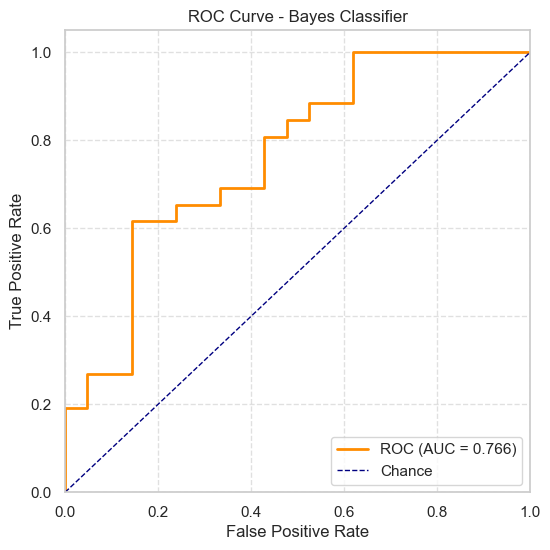

In [25]:
from sklearn import mixture
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def pdfGauss(X,mean,cov):
    covInv=np.linalg.inv(cov)
    dim=cov.shape[0]
    val=np.array([])
    for i in range(X.shape[0]):
        dist=((np.array([X[i,:]-mean]))@covInv@(np.array([X[i,:]-mean])).T).squeeze()
        val=np.append(val,np.exp(-0.5*dist)/((2*np.pi)**(dim/2)*np.linalg.det(cov)**0.5))
    return np.array([val]).T


def fitBayes(Xtr, ytr):
    ix1 = np.where(ytr == 1)[0]
    ix2 = np.where(ytr == 2)[0]

    Pw1=ix1.shape[0]/(ix1.shape[0]+ix2.shape[0])
    Pw2=ix2.shape[0]/(ix1.shape[0]+ix2.shape[0])

    g1 = mixture.GaussianMixture(n_components=1).fit(Xtr[ix1, :])
    g2 = mixture.GaussianMixture(n_components=1).fit(Xtr[ix2, :])

    return {
        "mean1": g1.means_.squeeze(),
        "mean2": g2.means_.squeeze(),
        "cov1": g1.covariances_[0],
        "cov2": g2.covariances_[0],
        "Pw1": Pw1,
        "Pw2": Pw2
    }


def useBayes(Xte, model):
    Pw1X = pdfGauss(Xte, model["mean1"], model["cov1"]) * model["Pw1"]
    Pw2X = pdfGauss(Xte, model["mean2"], model["cov2"]) * model["Pw2"]

    post = np.concatenate([Pw1X, Pw2X], axis=1)
    preds = np.argmax(post, axis=1) + 1
    return preds

# Selecionar features
top_3 = ['Glucose', 'HOMA', 'BMI']

X = data[top_3].to_numpy()
y = data["Classification"].to_numpy()

N_RUNS = 20
results = []

accs, precs, recs, f1s = [], [], [], []

for seed in range(N_RUNS):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, stratify=y, random_state=seed
    )

    # Normalização só com treino
    mu = X_train.mean(axis=0)
    std = X_train.std(axis=0)

    X_train_n = (X_train - mu) / std
    X_test_n = (X_test - mu) / std
    model = fitBayes(X_train_n, y_train)

    # Teste
    yp = useBayes(X_test_n, model)

    acc = accuracy_score(y_test, yp)
    prec = precision_score(y_test, yp)
    rec = recall_score(y_test, yp)
    f1 = f1_score(y_test, yp)

    accs.append(accuracy_score(y_test, yp))
    precs.append(precision_score(y_test, yp))
    recs.append(recall_score(y_test, yp))
    f1s.append(f1_score(y_test, yp))

cm = confusion_matrix(y_test, yp)
print("\nCLASSIFICADOR DE BAYES: ")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-Score: {f1:.3f}")
print("\nConfusion Matrix:\n", cm)
print(classification_report(y_test, yp, digits=4))


# AUC / ROC curve for the Bayes model
Pw1X = pdfGauss(X_test_n, model["mean1"], model["cov1"]) * model["Pw1"]
Pw2X = pdfGauss(X_test_n, model["mean2"], model["cov2"]) * model["Pw2"]
probs = (Pw2X / (Pw1X + Pw2X)).ravel()  # posterior prob for class 2

fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=2)
roc_auc = auc(fpr, tpr)

print(f"\nBayes Error (%): {(1-acc)*100:.2f}%")
print(f"AUC: {roc_auc:.4f}")

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Bayes Classifier')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


Como se pode observar nas várias avaliações do Classificador de Bayes, diferentes valores de random_state originaram variações significativas nas métricas (accuracy, F1, AUC). Estas diferenças devem-se, neste caso, ao facto de o dataset ser pequeno, o que torna o desempenho sensível à divisão treino/teste. Foram testados vários valores de random_state de forma a avaliar a robustez e a estabilidade do modelo. 

Foram também testadas várias combinações de features (['Glucose', 'HOMA', 'BMI', 'Resistin', 'Adiponectin', 'Age']; ['Glucose', 'HOMA', 'BMI', 'Resistin'] e ['Glucose', 'HOMA', 'BMI']). Os melhores valores foram obtidos ao usar ['Glucose', 'HOMA', 'BMI', 'Resistin', 'Adiponectin', 'Age'], o que sugere que as features adicionais, mesmo que não estatisticamente significativas isoladamente, podem melhorar a classificação quando combinadas.

Os melhores valores do modelo foram obtidos com uma divisão 70% treino/30% teste e features = ['Glucose', 'HOMA', 'BMI', 'Resistin', 'Adiponectin', 'Age']:<br>
Accuracy: 0.766<br>
Precision: 0.692<br>
Recall: 0.857<br>
F1-Score: 0.766<br>
AUC = 0.914

### SVM Linear

In [26]:
## SVM Linear 70/30 com ['Glucose', 'HOMA', 'Age', 'MCP.1']

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import numpy as np
import pandas as pd


sel_features = ['Glucose', 'HOMA', 'Age', 'MCP.1']

X = data[sel_features].to_numpy()
y = data["Classification"].to_numpy()

N_RUNS = 20

accs, precs, recs, f1s = [], [], [], []
cms = []  # guardar matrizes de confusão

for seed in range(N_RUNS):

    # Split estratificado 70/30
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=seed
    )

    # Normalização (fit só no treino!)
    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_test_n  = scaler.transform(X_test)

    # SVM Linear
    svm_linear = SVC(
        kernel='linear',
        C=1.0,
        class_weight='balanced',
        probability=True,
        random_state=seed
    )

    svm_linear.fit(X_train_n, y_train)
    y_pred = svm_linear.predict(X_test_n)

    # Guardar métricas
    accs.append(accuracy_score(y_test, y_pred))
    precs.append(precision_score(y_test, y_pred, pos_label=2))
    recs.append(recall_score(y_test, y_pred, pos_label=2))
    f1s.append(f1_score(y_test, y_pred, pos_label=2))
    cms.append(confusion_matrix(y_test, y_pred, labels=[1,2]))



print("Features usadas:", sel_features)

print(f"\nAccuracy : {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"Precision: {np.mean(precs):.3f} ± {np.std(precs):.3f}")
print(f"Recall   : {np.mean(recs):.3f} ± {np.std(recs):.3f}")
print(f"F1-score : {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")




Features usadas: ['Glucose', 'HOMA', 'Age', 'MCP.1']

Accuracy : 0.669 ± 0.065
Precision: 0.765 ± 0.103
Recall   : 0.592 ± 0.122
F1-score : 0.654 ± 0.082


Features usadas: ['Glucose', 'HOMA', 'Age', 'MCP.1']
Nº de componentes PCA: 2

MÉTRICAS DE TREINO:
Accuracy : 0.636 ± 0.035
Precision: 0.756 ± 0.042
Recall   : 0.509 ± 0.065
F1-score : 0.606 ± 0.053

MÉTRICAS DE TESTE:
Accuracy : 0.641 ± 0.059
Precision: 0.765 ± 0.088
Recall   : 0.508 ± 0.121
F1-score : 0.599 ± 0.090


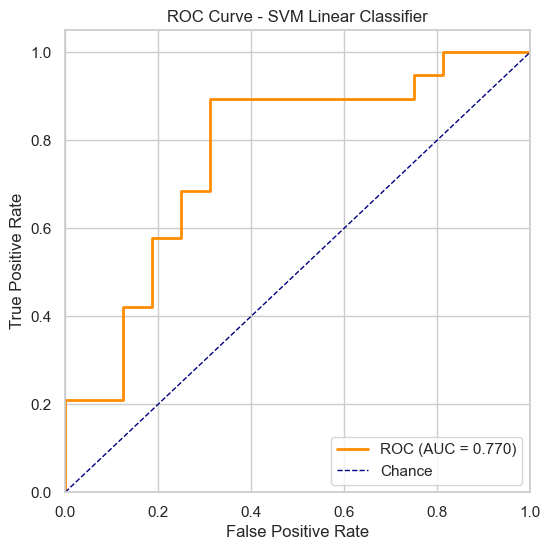

In [27]:
## SVM Linear 70/30 com ['Glucose', 'HOMA', 'Age', 'MCP.1']

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd


sel_features = ['Glucose', 'HOMA', 'Age', 'MCP.1']

X = data[sel_features].to_numpy()
y = data["Classification"].to_numpy()


N_RUNS = 20
N_COMPONENTS = 2

# Arrays para acumular métricas
train_accs, train_precs, train_recs, train_f1s = [], [], [], []
test_accs,  test_precs,  test_recs,  test_f1s  = [], [], [], []



for seed in range(N_RUNS):

    # HOLDOUT 70/30 estratificado
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=seed
    )

    # Normalização
    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_test_n  = scaler.transform(X_test)

    # PCA (fit só no treino!)
    pca = PCA(n_components=N_COMPONENTS)
    X_train_pca = pca.fit_transform(X_train_n)
    X_test_pca  = pca.transform(X_test_n)

    # SVM Linear
    svm = SVC(
        kernel='linear',
        C=1.0,
        class_weight='balanced',
        probability=True,
        random_state=seed
    )

    svm.fit(X_train_pca, y_train)


    y_train_pred = svm.predict(X_train_pca)

    train_accs.append(accuracy_score(y_train, y_train_pred))
    train_precs.append(precision_score(y_train, y_train_pred, pos_label=2))
    train_recs.append(recall_score(y_train, y_train_pred, pos_label=2))
    train_f1s.append(f1_score(y_train, y_train_pred, pos_label=2))


    y_test_pred = svm.predict(X_test_pca)

    test_accs.append(accuracy_score(y_test, y_test_pred))
    test_precs.append(precision_score(y_test, y_test_pred, pos_label=2))
    test_recs.append(recall_score(y_test, y_test_pred, pos_label=2))
    test_f1s.append(f1_score(y_test, y_test_pred, pos_label=2))

    cms.append(confusion_matrix(y_test, y_test_pred, labels=[1,2]))


print("Features usadas:", sel_features)
print(f"Nº de componentes PCA: {N_COMPONENTS}")

print("\nMÉTRICAS DE TREINO:")
print(f"Accuracy : {np.mean(train_accs):.3f} ± {np.std(train_accs):.3f}")
print(f"Precision: {np.mean(train_precs):.3f} ± {np.std(train_precs):.3f}")
print(f"Recall   : {np.mean(train_recs):.3f} ± {np.std(train_recs):.3f}")
print(f"F1-score : {np.mean(train_f1s):.3f} ± {np.std(train_f1s):.3f}")

print("\nMÉTRICAS DE TESTE:")
print(f"Accuracy : {np.mean(test_accs):.3f} ± {np.std(test_accs):.3f}")
print(f"Precision: {np.mean(test_precs):.3f} ± {np.std(test_precs):.3f}")
print(f"Recall   : {np.mean(test_recs):.3f} ± {np.std(test_recs):.3f}")
print(f"F1-score : {np.mean(test_f1s):.3f} ± {np.std(test_f1s):.3f}")

probs = svm.predict_proba(X_test_pca)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Linear Classifier')
plt.legend(loc="lower right")
plt.show()


SVM LINEAR 60/20/20 — RESULTADOS
Features usadas: ['Glucose', 'HOMA', 'Age', 'MCP.1']
Valores de C testados: [0.01, 0.1, 1, 5, 10, 50]

MÉDIAS DE TREINO:
Accuracy : 0.696 ± 0.046
Precision: 0.775 ± 0.044
Recall   : 0.633 ± 0.086
F1-score : 0.693 ± 0.060

MÉDIAS DE VALIDAÇÃO:
Accuracy : 0.639 ± 0.069
Precision: 0.810 ± 0.090
Recall   : 0.517 ± 0.160
F1-score : 0.581 ± 0.111

MÉDIAS DE TESTE (FINAL):
Melhor valor de C: 1
Accuracy : 0.669 ± 0.083
Precision: 0.758 ± 0.114
Recall   : 0.588 ± 0.136
F1-score : 0.652 ± 0.104


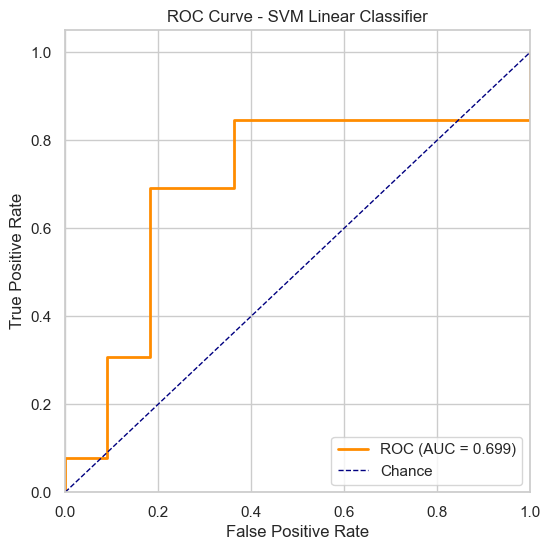

In [28]:
############## SVM linear com 60/20/20 e ['Glucose', 'HOMA', 'Age', 'MCP.1']
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)
import numpy as np

sel_features = ['Glucose', 'HOMA', 'Age', 'MCP.1']

X = data[sel_features].to_numpy()
y = data["Classification"].to_numpy()

C_values = [0.01, 0.1, 1, 5, 10, 50]

# Número de runs
N_RUNS = 20

train_accs, train_precs, train_recs, train_f1s = [], [], [], []
val_accs,   val_precs,   val_recs,   val_f1s   = [], [], [], []
test_accs,  test_precs,  test_recs,  test_f1s  = [], [], [], []



for seed in range(N_RUNS):

    # 60% treino / 40% temporário
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.40, stratify=y, random_state=seed
    )

    # 20% validação / 20% teste
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=seed
    )

    # NORMALIZAÇÃO (fit só no treino)
    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_val_n   = scaler.transform(X_val)
    X_test_n  = scaler.transform(X_test)

    # VALIDAÇÃO: procurar melhor C
    best_c = None
    best_val_f1 = -np.inf

    # Para guardar métrica da validação para análise média
    val_metrics_C = []

    for C in C_values:
        svm = SVC(kernel='linear', C=C, class_weight='balanced', random_state=seed)
        svm.fit(X_train_n, y_train)

        # Predição na validação
        y_val_pred = svm.predict(X_val_n)

        # Métricas na validação
        val_acc   = accuracy_score(y_val, y_val_pred)
        val_prec  = precision_score(y_val, y_val_pred, pos_label=2, zero_division=0)
        val_rec   = recall_score(y_val, y_val_pred, pos_label=2)
        val_f1    = f1_score(y_val, y_val_pred, pos_label=2)

        val_metrics_C.append((val_acc, val_prec, val_rec, val_f1))

        # Escolher o melhor C com base no F1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_c = C

    # Guardar métricas da validação (média sobre valores testados de C)
    val_accs.append( np.mean([m[0] for m in val_metrics_C]) )
    val_precs.append(np.mean([m[1] for m in val_metrics_C]))
    val_recs.append( np.mean([m[2] for m in val_metrics_C]) )
    val_f1s.append(  np.mean([m[3] for m in val_metrics_C]) )

    # Treinar modelo final com C escolhido
    final_svm = SVC(
        kernel='linear',
        C=best_c,
        class_weight='balanced',
        probability=True,
        random_state=seed
    )
    final_svm.fit(X_train_n, y_train)

    # Métricas de TREINO
    y_train_pred = final_svm.predict(X_train_n)

    train_accs.append(accuracy_score(y_train, y_train_pred))
    train_precs.append(precision_score(y_train, y_train_pred, pos_label=2, zero_division=0))
    train_recs.append(recall_score(y_train, y_train_pred, pos_label=2))
    train_f1s.append(f1_score(y_train, y_train_pred, pos_label=2))

    # Métricas de TESTE (final)
    y_test_pred = final_svm.predict(X_test_n)

    test_accs.append(accuracy_score(y_test, y_test_pred))
    test_precs.append(precision_score(y_test, y_test_pred, pos_label=2, zero_division=0))
    test_recs.append(recall_score(y_test, y_test_pred, pos_label=2))
    test_f1s.append(f1_score(y_test, y_test_pred, pos_label=2))


print("\nSVM LINEAR 60/20/20 — RESULTADOS")

print("Features usadas:", sel_features)
print("Valores de C testados:", C_values)

print("\nMÉDIAS DE TREINO:")
print(f"Accuracy : {np.mean(train_accs):.3f} ± {np.std(train_accs):.3f}")
print(f"Precision: {np.mean(train_precs):.3f} ± {np.std(train_precs):.3f}")
print(f"Recall   : {np.mean(train_recs):.3f} ± {np.std(train_recs):.3f}")
print(f"F1-score : {np.mean(train_f1s):.3f} ± {np.std(train_f1s):.3f}")

print("\nMÉDIAS DE VALIDAÇÃO:")
print(f"Accuracy : {np.mean(val_accs):.3f} ± {np.std(val_accs):.3f}")
print(f"Precision: {np.mean(val_precs):.3f} ± {np.std(val_precs):.3f}")
print(f"Recall   : {np.mean(val_recs):.3f} ± {np.std(val_recs):.3f}")
print(f"F1-score : {np.mean(val_f1s):.3f} ± {np.std(val_f1s):.3f}")

print("\nMÉDIAS DE TESTE (FINAL):")
print("Melhor valor de C:", best_c)
print(f"Accuracy : {np.mean(test_accs):.3f} ± {np.std(test_accs):.3f}")
print(f"Precision: {np.mean(test_precs):.3f} ± {np.std(test_precs):.3f}")
print(f"Recall   : {np.mean(test_recs):.3f} ± {np.std(test_recs):.3f}")
print(f"F1-score : {np.mean(test_f1s):.3f} ± {np.std(test_f1s):.3f}")

probs = final_svm.predict_proba(X_test_n)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Linear Classifier')
plt.legend(loc="lower right")
plt.show()



SVM LINEAR 60/20/20 — RESULTADOS
Features usadas: ['Glucose', 'HOMA']
Valores de C testados: [0.01, 0.1, 1, 5, 10, 50]

MÉDIAS DE TREINO:
Accuracy : 0.705 ± 0.041
Precision: 0.803 ± 0.043
Recall   : 0.622 ± 0.103
F1-score : 0.694 ± 0.071

MÉDIAS DE VALIDAÇÃO:
Accuracy : 0.646 ± 0.076
Precision: 0.820 ± 0.099
Recall   : 0.485 ± 0.139
F1-score : 0.568 ± 0.117

MÉDIAS DE TESTE (FINAL):
Melhor valor de C: 1
Accuracy : 0.683 ± 0.083
Precision: 0.772 ± 0.191
Recall   : 0.554 ± 0.181
F1-score : 0.634 ± 0.174


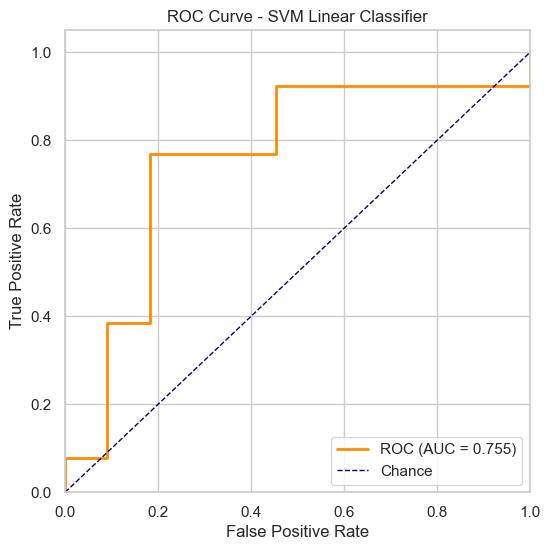

In [29]:
############## SVM linear com 60/20/20 e ['Glucose', 'HOMA']
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)
import numpy as np

sel_features = ['Glucose', 'HOMA']

X = data[sel_features].to_numpy()
y = data["Classification"].to_numpy()

C_values = [0.01, 0.1, 1, 5, 10, 50]

# Número de runs
N_RUNS = 20

train_accs, train_precs, train_recs, train_f1s = [], [], [], []
val_accs,   val_precs,   val_recs,   val_f1s   = [], [], [], []
test_accs,  test_precs,  test_recs,  test_f1s  = [], [], [], []



for seed in range(N_RUNS):

    # 60% treino / 40% temporário
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.40, stratify=y, random_state=seed
    )

    # 20% validação / 20% teste
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=seed
    )

    # NORMALIZAÇÃO (fit só no treino)
    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_val_n   = scaler.transform(X_val)
    X_test_n  = scaler.transform(X_test)

    # VALIDAÇÃO: procurar melhor C
    best_c = None
    best_val_f1 = -np.inf

    # Para guardar métrica da validação para análise média
    val_metrics_C = []

    for C in C_values:
        svm = SVC(kernel='linear', C=C, class_weight='balanced', random_state=seed)
        svm.fit(X_train_n, y_train)

        # Predição na validação
        y_val_pred = svm.predict(X_val_n)

        # Métricas na validação
        val_acc   = accuracy_score(y_val, y_val_pred)
        val_prec  = precision_score(y_val, y_val_pred, pos_label=2, zero_division=0)
        val_rec   = recall_score(y_val, y_val_pred, pos_label=2)
        val_f1    = f1_score(y_val, y_val_pred, pos_label=2)

        val_metrics_C.append((val_acc, val_prec, val_rec, val_f1))

        # Escolher o melhor C com base no F1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_c = C

    # Guardar métricas da validação (média sobre valores testados de C)
    val_accs.append( np.mean([m[0] for m in val_metrics_C]) )
    val_precs.append(np.mean([m[1] for m in val_metrics_C]))
    val_recs.append( np.mean([m[2] for m in val_metrics_C]) )
    val_f1s.append(  np.mean([m[3] for m in val_metrics_C]) )

    # Treinar modelo final com C escolhido
    final_svm = SVC(
        kernel='linear',
        C=best_c,
        class_weight='balanced',
        probability=True,
        random_state=seed
    )
    final_svm.fit(X_train_n, y_train)

    # Métricas de TREINO
    y_train_pred = final_svm.predict(X_train_n)

    train_accs.append(accuracy_score(y_train, y_train_pred))
    train_precs.append(precision_score(y_train, y_train_pred, pos_label=2, zero_division=0))
    train_recs.append(recall_score(y_train, y_train_pred, pos_label=2))
    train_f1s.append(f1_score(y_train, y_train_pred, pos_label=2))

    # Métricas de TESTE (final)
    y_test_pred = final_svm.predict(X_test_n)

    test_accs.append(accuracy_score(y_test, y_test_pred))
    test_precs.append(precision_score(y_test, y_test_pred, pos_label=2, zero_division=0))
    test_recs.append(recall_score(y_test, y_test_pred, pos_label=2))
    test_f1s.append(f1_score(y_test, y_test_pred, pos_label=2))


print("\nSVM LINEAR 60/20/20 — RESULTADOS")

print("Features usadas:", sel_features)
print("Valores de C testados:", C_values)

print("\nMÉDIAS DE TREINO:")
print(f"Accuracy : {np.mean(train_accs):.3f} ± {np.std(train_accs):.3f}")
print(f"Precision: {np.mean(train_precs):.3f} ± {np.std(train_precs):.3f}")
print(f"Recall   : {np.mean(train_recs):.3f} ± {np.std(train_recs):.3f}")
print(f"F1-score : {np.mean(train_f1s):.3f} ± {np.std(train_f1s):.3f}")

print("\nMÉDIAS DE VALIDAÇÃO:")
print(f"Accuracy : {np.mean(val_accs):.3f} ± {np.std(val_accs):.3f}")
print(f"Precision: {np.mean(val_precs):.3f} ± {np.std(val_precs):.3f}")
print(f"Recall   : {np.mean(val_recs):.3f} ± {np.std(val_recs):.3f}")
print(f"F1-score : {np.mean(val_f1s):.3f} ± {np.std(val_f1s):.3f}")

print("\nMÉDIAS DE TESTE (FINAL):")
print("Melhor valor de C:", best_c)
print(f"Accuracy : {np.mean(test_accs):.3f} ± {np.std(test_accs):.3f}")
print(f"Precision: {np.mean(test_precs):.3f} ± {np.std(test_precs):.3f}")
print(f"Recall   : {np.mean(test_recs):.3f} ± {np.std(test_recs):.3f}")
print(f"F1-score : {np.mean(test_f1s):.3f} ± {np.std(test_f1s):.3f}")

probs = final_svm.predict_proba(X_test_n)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Linear Classifier')
plt.legend(loc="lower right")
plt.show()



SVM LINEAR 60/20/20 — RESULTADOS
Features usadas: ['Glucose', 'Age', 'HOMA']
Valores de C testados: [0.01, 0.1, 1, 5, 10, 50]

MÉDIAS DE TREINO:
Accuracy : 0.710 ± 0.047
Precision: 0.794 ± 0.067
Recall   : 0.653 ± 0.100
F1-score : 0.708 ± 0.068

MÉDIAS DE VALIDAÇÃO:
Accuracy : 0.653 ± 0.084
Precision: 0.835 ± 0.102
Recall   : 0.523 ± 0.157
F1-score : 0.594 ± 0.122

MÉDIAS DE TESTE (FINAL):
Melhor valor de C: 1
Accuracy : 0.681 ± 0.064
Precision: 0.772 ± 0.083
Recall   : 0.600 ± 0.157
F1-score : 0.659 ± 0.116


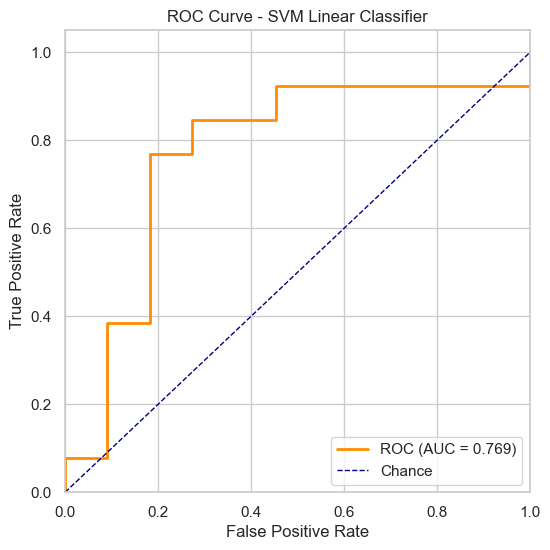

In [30]:
############## SVM linear com 60/20/20 e ['Glucose', 'HOMA', 'Age']
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)
import numpy as np

sel_features = ['Glucose','Age', 'HOMA']

X = data[sel_features].to_numpy()
y = data["Classification"].to_numpy()

C_values = [0.01, 0.1, 1, 5, 10, 50]

# Número de runs
N_RUNS = 20

train_accs, train_precs, train_recs, train_f1s = [], [], [], []
val_accs,   val_precs,   val_recs,   val_f1s   = [], [], [], []
test_accs,  test_precs,  test_recs,  test_f1s  = [], [], [], []



for seed in range(N_RUNS):

    # 60% treino / 40% temporário
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.40, stratify=y, random_state=seed
    )

    # 20% validação / 20% teste
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=seed
    )

    # NORMALIZAÇÃO (fit só no treino)
    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_val_n   = scaler.transform(X_val)
    X_test_n  = scaler.transform(X_test)

    # VALIDAÇÃO: procurar melhor C
    best_c = None
    best_val_f1 = -np.inf

    # Para guardar métrica da validação para análise média
    val_metrics_C = []

    for C in C_values:
        svm = SVC(kernel='linear', C=C, class_weight='balanced', random_state=seed)
        svm.fit(X_train_n, y_train)

        # Predição na validação
        y_val_pred = svm.predict(X_val_n)

        # Métricas na validação
        val_acc   = accuracy_score(y_val, y_val_pred)
        val_prec  = precision_score(y_val, y_val_pred, pos_label=2, zero_division=0)
        val_rec   = recall_score(y_val, y_val_pred, pos_label=2)
        val_f1    = f1_score(y_val, y_val_pred, pos_label=2)

        val_metrics_C.append((val_acc, val_prec, val_rec, val_f1))

        # Escolher o melhor C com base no F1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_c = C

    # Guardar métricas da validação (média sobre valores testados de C)
    val_accs.append( np.mean([m[0] for m in val_metrics_C]) )
    val_precs.append(np.mean([m[1] for m in val_metrics_C]))
    val_recs.append( np.mean([m[2] for m in val_metrics_C]) )
    val_f1s.append(  np.mean([m[3] for m in val_metrics_C]) )

    # Treinar modelo final com C escolhido
    final_svm = SVC(
        kernel='linear',
        C=best_c,
        class_weight='balanced',
        probability=True,
        random_state=seed
    )
    final_svm.fit(X_train_n, y_train)

    # Métricas de TREINO
    y_train_pred = final_svm.predict(X_train_n)

    train_accs.append(accuracy_score(y_train, y_train_pred))
    train_precs.append(precision_score(y_train, y_train_pred, pos_label=2, zero_division=0))
    train_recs.append(recall_score(y_train, y_train_pred, pos_label=2))
    train_f1s.append(f1_score(y_train, y_train_pred, pos_label=2))

    # Métricas de TESTE (final)
    y_test_pred = final_svm.predict(X_test_n)

    test_accs.append(accuracy_score(y_test, y_test_pred))
    test_precs.append(precision_score(y_test, y_test_pred, pos_label=2, zero_division=0))
    test_recs.append(recall_score(y_test, y_test_pred, pos_label=2))
    test_f1s.append(f1_score(y_test, y_test_pred, pos_label=2))


print("\nSVM LINEAR 60/20/20 — RESULTADOS")

print("Features usadas:", sel_features)
print("Valores de C testados:", C_values)

print("\nMÉDIAS DE TREINO:")
print(f"Accuracy : {np.mean(train_accs):.3f} ± {np.std(train_accs):.3f}")
print(f"Precision: {np.mean(train_precs):.3f} ± {np.std(train_precs):.3f}")
print(f"Recall   : {np.mean(train_recs):.3f} ± {np.std(train_recs):.3f}")
print(f"F1-score : {np.mean(train_f1s):.3f} ± {np.std(train_f1s):.3f}")

print("\nMÉDIAS DE VALIDAÇÃO:")
print(f"Accuracy : {np.mean(val_accs):.3f} ± {np.std(val_accs):.3f}")
print(f"Precision: {np.mean(val_precs):.3f} ± {np.std(val_precs):.3f}")
print(f"Recall   : {np.mean(val_recs):.3f} ± {np.std(val_recs):.3f}")
print(f"F1-score : {np.mean(val_f1s):.3f} ± {np.std(val_f1s):.3f}")

print("\nMÉDIAS DE TESTE (FINAL):")
print("Melhor valor de C:", best_c)
print(f"Accuracy : {np.mean(test_accs):.3f} ± {np.std(test_accs):.3f}")
print(f"Precision: {np.mean(test_precs):.3f} ± {np.std(test_precs):.3f}")
print(f"Recall   : {np.mean(test_recs):.3f} ± {np.std(test_recs):.3f}")
print(f"F1-score : {np.mean(test_f1s):.3f} ± {np.std(test_f1s):.3f}")

probs = final_svm.predict_proba(X_test_n)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Linear Classifier')
plt.legend(loc="lower right")
plt.show()



SVM LINEAR 70/30 + PCA
Features usadas: ['Glucose', 'HOMA', 'Age', 'MCP.1', 'BMI', 'Resistin', 'Adiponectin', 'Leptin', 'Insulin']
Nº de componentes PCA: 5

MÉTRICAS DE TREINO:
Accuracy : 0.712 ± 0.061
Precision: 0.795 ± 0.060
Recall   : 0.651 ± 0.095
F1-score : 0.713 ± 0.073

MÉTRICAS DE TESTE:

Accuracy : 0.661 ± 0.075
Precision: 0.748 ± 0.092
Recall   : 0.584 ± 0.130
F1-score : 0.646 ± 0.095


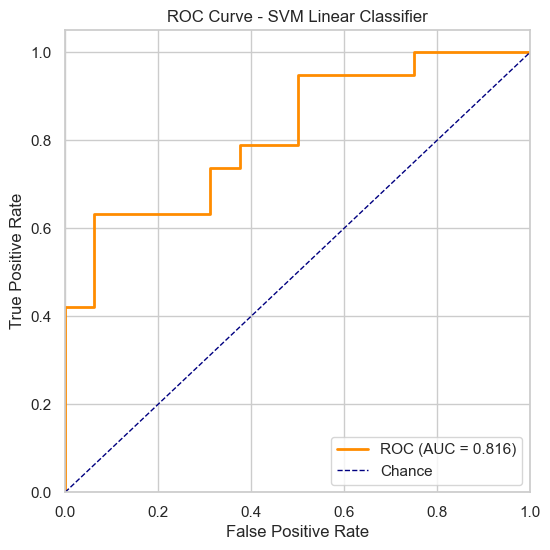

In [31]:
## SVM Linear + PCA 70/30 com ['Glucose', 'HOMA', 'Age', 'MCP.1', 'BMI', 'Resistin', 'Adiponectin', 'Leptin', 'Insulin']

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

sel_features = ['Glucose', 'HOMA', 'Age', 'MCP.1', 'BMI', 'Resistin', 'Adiponectin', 'Leptin', 'Insulin']

X = data[sel_features].to_numpy()
y = data["Classification"].to_numpy()


N_RUNS = 20               # nº de execuções
N_COMPONENTS = 5          # nº de componentes PCA a manter

train_accs, train_precs, train_recs, train_f1s = [], [], [], []
accs, precs, recs, f1s = [], [], [], []

for seed in range(N_RUNS):

    # Split 70/30 estratificado
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=seed
    )

    # NORMALIZAÇÃO (fit só no treino)
    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_test_n = scaler.transform(X_test)

    # PCA (fit só no treino!)
    pca = PCA(n_components=N_COMPONENTS)
    X_train_pca = pca.fit_transform(X_train_n)
    X_test_pca = pca.transform(X_test_n)


    svm_linear = SVC(
        kernel='linear',
        C=1.0,
        class_weight='balanced',
        probability=True,
        random_state=seed
    )

    svm_linear.fit(X_train_pca, y_train)
    y_pred = svm_linear.predict(X_test_pca)


    y_train_pred = svm_linear.predict(X_train_pca)

    train_accs.append(accuracy_score(y_train, y_train_pred))
    train_precs.append(precision_score(y_train, y_train_pred, pos_label=2))
    train_recs.append(recall_score(y_train, y_train_pred, pos_label=2))
    train_f1s.append(f1_score(y_train, y_train_pred, pos_label=2))

    accs.append(accuracy_score(y_test, y_pred))
    precs.append(precision_score(y_test, y_pred, pos_label=2))
    recs.append(recall_score(y_test, y_pred, pos_label=2))
    f1s.append(f1_score(y_test, y_pred, pos_label=2))


print("\nSVM LINEAR 70/30 + PCA")
print("Features usadas:", sel_features)
print(f"Nº de componentes PCA: {N_COMPONENTS}")

print("\nMÉTRICAS DE TREINO:")
print(f"Accuracy : {np.mean(train_accs):.3f} ± {np.std(train_accs):.3f}")
print(f"Precision: {np.mean(train_precs):.3f} ± {np.std(train_precs):.3f}")
print(f"Recall   : {np.mean(train_recs):.3f} ± {np.std(train_recs):.3f}")
print(f"F1-score : {np.mean(train_f1s):.3f} ± {np.std(train_f1s):.3f}")

print("\nMÉTRICAS DE TESTE:")
print(f"\nAccuracy : {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"Precision: {np.mean(precs):.3f} ± {np.std(precs):.3f}")
print(f"Recall   : {np.mean(recs):.3f} ± {np.std(recs):.3f}")
print(f"F1-score : {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")

probs = svm_linear.predict_proba(X_test_pca)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Linear Classifier')
plt.legend(loc="lower right")
plt.show()



SVM LINEAR + PCA (60/20/20)
Features usadas: ['Glucose', 'HOMA', 'Age', 'MCP.1']
Valores de C testados: [0.01, 0.1, 1, 5, 10, 50]
C escolhido: 0.1

MÉDIAS DE TREINO:
Accuracy : 0.637 ± 0.037
Precision: 0.752 ± 0.046
Recall   : 0.513 ± 0.094
F1-score : 0.605 ± 0.061

MÉDIAS DE VALIDAÇÃO:
Accuracy : 0.607 ± 0.081
Precision: 0.760 ± 0.101
Recall   : 0.456 ± 0.129
F1-score : 0.537 ± 0.112

MÉDIAS DE TESTE (FINAL):
Accuracy : 0.629 ± 0.082
Precision: 0.747 ± 0.122
Recall   : 0.485 ± 0.136
F1-score : 0.577 ± 0.123


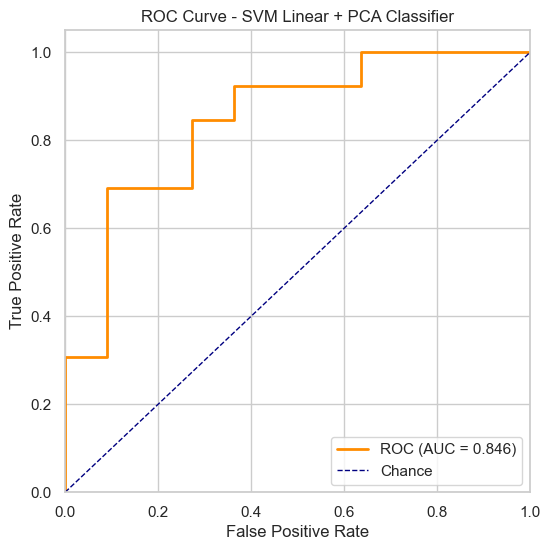

In [32]:
############## SVM linear + PCA com 60/20/20 e ['Glucose', 'HOMA', 'Age', 'MCP.1']
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
)
import numpy as np
import matplotlib.pyplot as plt

sel_features = ['Glucose', 'HOMA', 'Age', 'MCP.1']

X = data[sel_features].to_numpy()
y = data["Classification"].to_numpy()

C_values = [0.01, 0.1, 1, 5, 10, 50]
N_RUNS = 20

train_accs, train_precs, train_recs, train_f1s = [], [], [], []
val_accs,   val_precs,   val_recs,   val_f1s   = [], [], [], []
test_accs,  test_precs,  test_recs,  test_f1s  = [], [], [], []

best_cs = []


for seed in range(N_RUNS):

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.40, stratify=y, random_state=seed
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=seed
    )

    # NORMALIZAÇÃO
    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_val_n   = scaler.transform(X_val)
    X_test_n  = scaler.transform(X_test)

    # PCA
    pca = PCA(n_components=2, random_state=seed)
    X_train_pca = pca.fit_transform(X_train_n)
    X_val_pca   = pca.transform(X_val_n)
    X_test_pca  = pca.transform(X_test_n)

    # VALIDAÇÃO — escolher melhor C
    best_c = None
    best_val_f1 = -np.inf

    val_metrics_C = []

    for C in C_values:
        svm = SVC(kernel='linear', C=C, class_weight='balanced', random_state=seed)
        svm.fit(X_train_pca, y_train)

        y_val_pred = svm.predict(X_val_pca)

        val_acc = accuracy_score(y_val, y_val_pred)
        val_prec = precision_score(y_val, y_val_pred, pos_label=2, zero_division=0)
        val_rec = recall_score(y_val, y_val_pred, pos_label=2)
        val_f1 = f1_score(y_val, y_val_pred, pos_label=2)

        val_metrics_C.append((val_acc, val_prec, val_rec, val_f1))

        # escolher melhor C pelo F1 da validação
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_c = C

    best_cs.append(best_c)

    # MÉTRICAS MÉDIA DA VALIDAÇÃO (só para análise estatística)
    val_accs.append(np.mean([m[0] for m in val_metrics_C]))
    val_precs.append(np.mean([m[1] for m in val_metrics_C]))
    val_recs.append(np.mean([m[2] for m in val_metrics_C]))
    val_f1s.append(np.mean([m[3] for m in val_metrics_C]))

    final_svm = SVC(
        kernel='linear',
        C=best_c,
        class_weight='balanced',
        probability=True,
        random_state=seed
    )
    final_svm.fit(X_train_pca, y_train)

    # MÉTRICAS DE TREINO
    y_train_pred = final_svm.predict(X_train_pca)
    train_accs.append(accuracy_score(y_train, y_train_pred))
    train_precs.append(precision_score(y_train, y_train_pred, pos_label=2, zero_division=0))
    train_recs.append(recall_score(y_train, y_train_pred, pos_label=2))
    train_f1s.append(f1_score(y_train, y_train_pred, pos_label=2))

    # MÉTRICAS DE TESTE FINAL
    y_test_pred = final_svm.predict(X_test_pca)

    test_accs.append(accuracy_score(y_test, y_test_pred))
    test_precs.append(precision_score(y_test, y_test_pred, pos_label=2, zero_division=0))
    test_recs.append(recall_score(y_test, y_test_pred, pos_label=2))
    test_f1s.append(f1_score(y_test, y_test_pred, pos_label=2))


print("\nSVM LINEAR + PCA (60/20/20)")
print("Features usadas:", sel_features)
print("Valores de C testados:", C_values)
print("C escolhido:", np.mean(best_c))

print("\nMÉDIAS DE TREINO:")
print(f"Accuracy : {np.mean(train_accs):.3f} ± {np.std(train_accs):.3f}")
print(f"Precision: {np.mean(train_precs):.3f} ± {np.std(train_precs):.3f}")
print(f"Recall   : {np.mean(train_recs):.3f} ± {np.std(train_recs):.3f}")
print(f"F1-score : {np.mean(train_f1s):.3f} ± {np.std(train_f1s):.3f}")

print("\nMÉDIAS DE VALIDAÇÃO:")
print(f"Accuracy : {np.mean(val_accs):.3f} ± {np.std(val_accs):.3f}")
print(f"Precision: {np.mean(val_precs):.3f} ± {np.std(val_precs):.3f}")
print(f"Recall   : {np.mean(val_recs):.3f} ± {np.std(val_recs):.3f}")
print(f"F1-score : {np.mean(val_f1s):.3f} ± {np.std(val_f1s):.3f}")

print("\nMÉDIAS DE TESTE (FINAL):")
print(f"Accuracy : {np.mean(test_accs):.3f} ± {np.std(test_accs):.3f}")
print(f"Precision: {np.mean(test_precs):.3f} ± {np.std(test_precs):.3f}")
print(f"Recall   : {np.mean(test_recs):.3f} ± {np.std(test_recs):.3f}")
print(f"F1-score : {np.mean(test_f1s):.3f} ± {np.std(test_f1s):.3f}")

probs = final_svm.predict_proba(X_test_pca)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=2)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Linear + PCA Classifier')
plt.legend(loc="lower right")
plt.show()



SVM LINEAR + PCA (60/20/20)
Features usadas: ['Glucose', 'HOMA', 'Age', 'MCP.1', 'BMI', 'Resistin', 'Adiponectin', 'Leptin', 'Insulin']
Valores de C testados: [0.01, 0.1, 1, 5, 10, 50]
C escolhido: 1

MÉDIAS DE TREINO:
Accuracy : 0.715 ± 0.044
Precision: 0.806 ± 0.050
Recall   : 0.641 ± 0.081
F1-score : 0.710 ± 0.054

MÉDIAS DE VALIDAÇÃO:
Accuracy : 0.663 ± 0.073
Precision: 0.787 ± 0.110
Recall   : 0.574 ± 0.132
F1-score : 0.630 ± 0.102

MÉDIAS DE TESTE (FINAL):
Accuracy : 0.621 ± 0.098
Precision: 0.693 ± 0.118
Recall   : 0.554 ± 0.204
F1-score : 0.592 ± 0.156


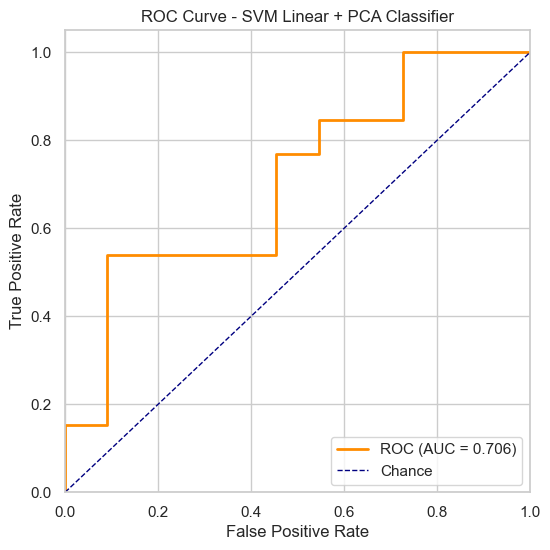

In [33]:
############## 1.1) SVM linear + PCA com 60/20/20 e ['Glucose', 'HOMA', 'Age', 'MCP.1', 'BMI', 'Resistin', 'Adiponectin', 'Leptin', 'Insulin']

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
)
import numpy as np
import matplotlib.pyplot as plt

sel_features = ['Glucose', 'HOMA', 'Age', 'MCP.1', 'BMI', 'Resistin', 'Adiponectin', 'Leptin', 'Insulin']

X = data[sel_features].to_numpy()
y = data["Classification"].to_numpy()

C_values = [0.01, 0.1, 1, 5, 10, 50]
N_RUNS = 20

train_accs, train_precs, train_recs, train_f1s = [], [], [], []
val_accs,   val_precs,   val_recs,   val_f1s   = [], [], [], []
test_accs,  test_precs,  test_recs,  test_f1s  = [], [], [], []

best_cs = []


for seed in range(N_RUNS):

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.40, stratify=y, random_state=seed
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=seed
    )

    # NORMALIZAÇÃO
    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_val_n   = scaler.transform(X_val)
    X_test_n  = scaler.transform(X_test)

    # PCA
    pca = PCA(n_components=5, random_state=seed)
    X_train_pca = pca.fit_transform(X_train_n)
    X_val_pca   = pca.transform(X_val_n)
    X_test_pca  = pca.transform(X_test_n)

    # VALIDAÇÃO — escolher melhor C
    best_c = None
    best_val_f1 = -np.inf

    val_metrics_C = []

    for C in C_values:
        svm = SVC(kernel='linear', C=C, class_weight='balanced', random_state=seed)
        svm.fit(X_train_pca, y_train)

        y_val_pred = svm.predict(X_val_pca)

        val_acc = accuracy_score(y_val, y_val_pred)
        val_prec = precision_score(y_val, y_val_pred, pos_label=2, zero_division=0)
        val_rec = recall_score(y_val, y_val_pred, pos_label=2)
        val_f1 = f1_score(y_val, y_val_pred, pos_label=2)

        val_metrics_C.append((val_acc, val_prec, val_rec, val_f1))

        # escolher melhor C pelo F1 da validação
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_c = C

    best_cs.append(best_c)

    # MÉTRICAS MÉDIA DA VALIDAÇÃO (só para análise estatística)
    val_accs.append(np.mean([m[0] for m in val_metrics_C]))
    val_precs.append(np.mean([m[1] for m in val_metrics_C]))
    val_recs.append(np.mean([m[2] for m in val_metrics_C]))
    val_f1s.append(np.mean([m[3] for m in val_metrics_C]))

    final_svm = SVC(
        kernel='linear',
        C=best_c,
        class_weight='balanced',
        probability=True,
        random_state=seed
    )
    final_svm.fit(X_train_pca, y_train)

    # MÉTRICAS DE TREINO
    y_train_pred = final_svm.predict(X_train_pca)
    train_accs.append(accuracy_score(y_train, y_train_pred))
    train_precs.append(precision_score(y_train, y_train_pred, pos_label=2, zero_division=0))
    train_recs.append(recall_score(y_train, y_train_pred, pos_label=2))
    train_f1s.append(f1_score(y_train, y_train_pred, pos_label=2))

    # MÉTRICAS DE TESTE FINAL
    y_test_pred = final_svm.predict(X_test_pca)

    test_accs.append(accuracy_score(y_test, y_test_pred))
    test_precs.append(precision_score(y_test, y_test_pred, pos_label=2, zero_division=0))
    test_recs.append(recall_score(y_test, y_test_pred, pos_label=2))
    test_f1s.append(f1_score(y_test, y_test_pred, pos_label=2))


print("\nSVM LINEAR + PCA (60/20/20)")
print("Features usadas:", sel_features)
print("Valores de C testados:", C_values)
print("C escolhido:", best_c)

print("\nMÉDIAS DE TREINO:")
print(f"Accuracy : {np.mean(train_accs):.3f} ± {np.std(train_accs):.3f}")
print(f"Precision: {np.mean(train_precs):.3f} ± {np.std(train_precs):.3f}")
print(f"Recall   : {np.mean(train_recs):.3f} ± {np.std(train_recs):.3f}")
print(f"F1-score : {np.mean(train_f1s):.3f} ± {np.std(train_f1s):.3f}")

print("\nMÉDIAS DE VALIDAÇÃO:")
print(f"Accuracy : {np.mean(val_accs):.3f} ± {np.std(val_accs):.3f}")
print(f"Precision: {np.mean(val_precs):.3f} ± {np.std(val_precs):.3f}")
print(f"Recall   : {np.mean(val_recs):.3f} ± {np.std(val_recs):.3f}")
print(f"F1-score : {np.mean(val_f1s):.3f} ± {np.std(val_f1s):.3f}")

print("\nMÉDIAS DE TESTE (FINAL):")
print(f"Accuracy : {np.mean(test_accs):.3f} ± {np.std(test_accs):.3f}")
print(f"Precision: {np.mean(test_precs):.3f} ± {np.std(test_precs):.3f}")
print(f"Recall   : {np.mean(test_recs):.3f} ± {np.std(test_recs):.3f}")
print(f"F1-score : {np.mean(test_f1s):.3f} ± {np.std(test_f1s):.3f}")

probs = final_svm.predict_proba(X_test_pca)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=2)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Linear + PCA Classifier')
plt.legend(loc="lower right")
plt.show()



SVM LINEAR + PCA (60/20/20)
Features usadas: ['Glucose', 'HOMA', 'Age', 'MCP.1', 'BMI', 'Resistin', 'Adiponectin', 'Leptin']
Valores de C testados: [0.01, 0.1, 1, 5, 10, 50]
C escolhido: 1

MÉDIAS DE TREINO:
Accuracy : 0.734 ± 0.045
Precision: 0.809 ± 0.063
Recall   : 0.683 ± 0.059
F1-score : 0.738 ± 0.046

MÉDIAS DE VALIDAÇÃO:
Accuracy : 0.684 ± 0.083
Precision: 0.777 ± 0.125
Recall   : 0.614 ± 0.138
F1-score : 0.653 ± 0.106

MÉDIAS DE TESTE (FINAL):
Accuracy : 0.681 ± 0.106
Precision: 0.733 ± 0.114
Recall   : 0.650 ± 0.151
F1-score : 0.683 ± 0.119


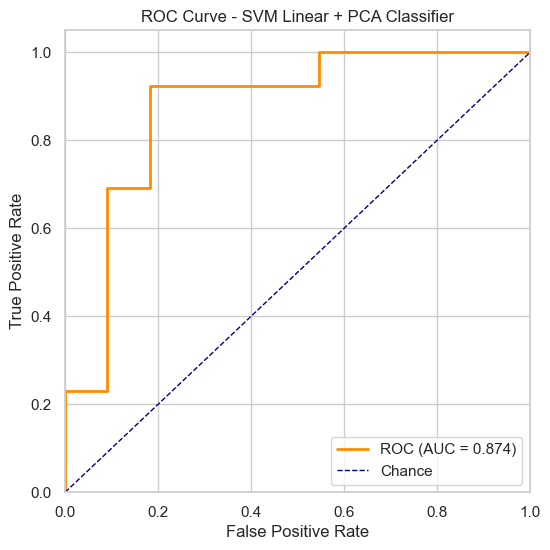

In [34]:
############## 1.2) SVM linear + PCA com 60/20/20 e ['Glucose', 'HOMA', 'Age', 'MCP.1', 'BMI', 'Resistin', 'Adiponectin', 'Leptin']

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
)
import numpy as np
import matplotlib.pyplot as plt

sel_features = ['Glucose', 'HOMA', 'Age', 'MCP.1', 'BMI', 'Resistin', 'Adiponectin', 'Leptin']

X = data[sel_features].to_numpy()
y = data["Classification"].to_numpy()

C_values = [0.01, 0.1, 1, 5, 10, 50]
N_RUNS = 20

train_accs, train_precs, train_recs, train_f1s = [], [], [], []
val_accs,   val_precs,   val_recs,   val_f1s   = [], [], [], []
test_accs,  test_precs,  test_recs,  test_f1s  = [], [], [], []

best_cs = []


for seed in range(N_RUNS):

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.40, stratify=y, random_state=seed
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=seed
    )

    # NORMALIZAÇÃO
    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_val_n   = scaler.transform(X_val)
    X_test_n  = scaler.transform(X_test)

    # PCA
    pca = PCA(n_components=5, random_state=seed)
    X_train_pca = pca.fit_transform(X_train_n)
    X_val_pca   = pca.transform(X_val_n)
    X_test_pca  = pca.transform(X_test_n)

    # VALIDAÇÃO — escolher melhor C
    best_c = None
    best_val_f1 = -np.inf

    val_metrics_C = []

    for C in C_values:
        svm = SVC(kernel='linear', C=C, class_weight='balanced', random_state=seed)
        svm.fit(X_train_pca, y_train)

        y_val_pred = svm.predict(X_val_pca)

        val_acc = accuracy_score(y_val, y_val_pred)
        val_prec = precision_score(y_val, y_val_pred, pos_label=2, zero_division=0)
        val_rec = recall_score(y_val, y_val_pred, pos_label=2)
        val_f1 = f1_score(y_val, y_val_pred, pos_label=2)

        val_metrics_C.append((val_acc, val_prec, val_rec, val_f1))

        # escolher melhor C pelo F1 da validação
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_c = C

    best_cs.append(best_c)

    # MÉTRICAS MÉDIA DA VALIDAÇÃO (só para análise estatística)
    val_accs.append(np.mean([m[0] for m in val_metrics_C]))
    val_precs.append(np.mean([m[1] for m in val_metrics_C]))
    val_recs.append(np.mean([m[2] for m in val_metrics_C]))
    val_f1s.append(np.mean([m[3] for m in val_metrics_C]))

    final_svm = SVC(
        kernel='linear',
        C=best_c,
        class_weight='balanced',
        probability=True,
        random_state=seed
    )
    final_svm.fit(X_train_pca, y_train)

    # MÉTRICAS DE TREINO
    y_train_pred = final_svm.predict(X_train_pca)
    train_accs.append(accuracy_score(y_train, y_train_pred))
    train_precs.append(precision_score(y_train, y_train_pred, pos_label=2, zero_division=0))
    train_recs.append(recall_score(y_train, y_train_pred, pos_label=2))
    train_f1s.append(f1_score(y_train, y_train_pred, pos_label=2))

    # MÉTRICAS DE TESTE FINAL
    y_test_pred = final_svm.predict(X_test_pca)

    test_accs.append(accuracy_score(y_test, y_test_pred))
    test_precs.append(precision_score(y_test, y_test_pred, pos_label=2, zero_division=0))
    test_recs.append(recall_score(y_test, y_test_pred, pos_label=2))
    test_f1s.append(f1_score(y_test, y_test_pred, pos_label=2))


print("\nSVM LINEAR + PCA (60/20/20)")
print("Features usadas:", sel_features)
print("Valores de C testados:", C_values)
print("C escolhido:", (best_c))

print("\nMÉDIAS DE TREINO:")
print(f"Accuracy : {np.mean(train_accs):.3f} ± {np.std(train_accs):.3f}")
print(f"Precision: {np.mean(train_precs):.3f} ± {np.std(train_precs):.3f}")
print(f"Recall   : {np.mean(train_recs):.3f} ± {np.std(train_recs):.3f}")
print(f"F1-score : {np.mean(train_f1s):.3f} ± {np.std(train_f1s):.3f}")

print("\nMÉDIAS DE VALIDAÇÃO:")
print(f"Accuracy : {np.mean(val_accs):.3f} ± {np.std(val_accs):.3f}")
print(f"Precision: {np.mean(val_precs):.3f} ± {np.std(val_precs):.3f}")
print(f"Recall   : {np.mean(val_recs):.3f} ± {np.std(val_recs):.3f}")
print(f"F1-score : {np.mean(val_f1s):.3f} ± {np.std(val_f1s):.3f}")

print("\nMÉDIAS DE TESTE (FINAL):")
print(f"Accuracy : {np.mean(test_accs):.3f} ± {np.std(test_accs):.3f}")
print(f"Precision: {np.mean(test_precs):.3f} ± {np.std(test_precs):.3f}")
print(f"Recall   : {np.mean(test_recs):.3f} ± {np.std(test_recs):.3f}")
print(f"F1-score : {np.mean(test_f1s):.3f} ± {np.std(test_f1s):.3f}")

probs = final_svm.predict_proba(X_test_pca)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=2)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Linear + PCA Classifier')
plt.legend(loc="lower right")
plt.show()


In [35]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Features e dados
sel_features = ['Glucose', 'HOMA']
X = data[sel_features].to_numpy()
y = data["Classification"].to_numpy()

C_values = [0.01, 0.1, 1, 5, 10, 50]
N_RUNS = 20

# Matriz para guardar erros
errMat = np.zeros((N_RUNS, len(C_values)))

for r, seed in enumerate(range(N_RUNS)):
    # Split 60/40 treino/teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.7, test_size=0.3, stratify=y, random_state=seed
    )

    # Normalização
    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_test_n  = scaler.transform(X_test)

    for k, C in enumerate(C_values):
        # Treino SVM linear
        clf = SVC(kernel="linear", C=C, class_weight='balanced', random_state=seed)
        clf.fit(X_train_n, y_train)

        # Predição e erro
        y_pred = clf.predict(X_test_n)
        acc = np.mean(y_pred == y_test)
        errMat[r, k] = (1 - acc) * 100

# Média e desvio padrão dos erros
avgError = np.mean(errMat, axis=0)
stdError = np.std(errMat, axis=0)

# Visualização do erro em função de C
xTickTexts = [str(c) for c in C_values]
fig = px.scatter(x=C_values, y=avgError, error_y=stdError)
fig.update_layout(
    xaxis=dict(
        title="C",
        tickmode='array',
        tickvals=C_values,
        ticktext=xTickTexts
    ),
    yaxis=dict(title="Average Error ± Std (%)"),
    font=dict(family="Courier New, monospace", size=16, color="RebeccaPurple")
)
fig.show()

# Melhor C
optC = C_values[np.argmin(avgError)]
print(f"Best C = {optC:.2f}")

# Treino final com melhor C
clf = SVC(kernel="linear", C=optC, class_weight='balanced')
clf.fit(X_train_n, y_train)
y_pred = clf.predict(X_test_n)
final_err = (1 - np.mean(y_pred == y_test)) * 100
print(f"Final test error (%) = {final_err:.2f}")


import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Features e dados
sel_features = ['Glucose', 'HOMA']
X = data[sel_features].to_numpy()
y = data["Classification"].to_numpy()

# Para visualização do gráfico, é necessário que y seja +1 / -1
# Aqui assumimos apenas duas classes para simplificação
ixClasses = np.where((y==1) | (y==2))[0]  # filtra Super (1) e Average (2)
X = X[ixClasses]
y = y[ixClasses]
y_vis = np.where(y==1, 1, -1)  # 1 = Super, -1 = Average

C_values = [0.01, 0.1, 1, 5, 10, 50]
N_RUNS = 20

errMat = np.zeros((N_RUNS, len(C_values)))

for r, seed in enumerate(range(N_RUNS)):
    # Split 50/50
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_vis, train_size=0.5, test_size=0.5, stratify=y_vis, random_state=seed
    )

    # Normalização
    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_test_n  = scaler.transform(X_test)

    for k, C in enumerate(C_values):
        clf = SVC(kernel="linear", C=C, class_weight='balanced', random_state=seed)
        clf.fit(X_train_n, y_train)
        y_pred = clf.predict(X_test_n)
        acc = np.mean(y_pred == y_test)
        errMat[r, k] = (1 - acc) * 100

# Média e desvio padrão
avgError = np.mean(errMat, axis=0)
stdError = np.std(errMat, axis=0)

# Plot do erro médio ± desvio
xTickTexts = [str(c) for c in C_values]
fig1 = px.scatter(x=C_values, y=avgError, error_y=stdError)
fig1.update_layout(
    xaxis=dict(
        title="C",
        tickmode='array',
        tickvals=C_values,
        ticktext=xTickTexts
    ),
    yaxis=dict(title="Average Error ± Std (%)"),
    font=dict(family="Courier New, monospace", size=16, color="RebeccaPurple")
)
fig1.show()

# Melhor C
optC = C_values[np.argmin(avgError)]
print(f"Best C = {optC:.2f}")


# Vetores de suporte
svs = clf.support_vectors_
ixPosSv = np.where(y_train[clf.support_] == 1)[0]
ixNegSv = np.where(y_train[clf.support_] == -1)[0]
posSv = svs[ixPosSv, :]
negSv = svs[ixNegSv, :]

# Hiperplano e margens
xx = np.arange(np.min(X_train_n[:,0])-0.5, np.max(X_train_n[:,0])+0.5, 0.01)
W = clf.coef_[0]
b = clf.intercept_[0]
hyp = -W[0]/W[1]*xx - b/W[1]
posLine = hyp - 1/W[1]
negLine = hyp + 1/W[1]

# Índices das classes no treino
ixPos = np.where(y_train==1)[0]
ixNeg = np.where(y_train==-1)[0]

# Gráfico interativo
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=X_train_n[ixPos,0], y=X_train_n[ixPos,1], name='Super',
                          mode='markers', marker=dict(size=10, color='blue')))
fig2.add_trace(go.Scatter(x=X_train_n[ixNeg,0], y=X_train_n[ixNeg,1], name='Average',
                          mode='markers', marker=dict(size=10, color='red')))
fig2.add_trace(go.Scatter(x=xx, y=hyp, mode='lines', line=dict(color="black", width=4), name='Hyperplane'))
fig2.add_trace(go.Scatter(x=xx, y=posLine, mode='lines', line=dict(color="blue", width=3, dash='dash'), name='Positive margin'))
fig2.add_trace(go.Scatter(x=xx, y=negLine, mode='lines', line=dict(color="red", width=3, dash='dash'), name='Negative margin'))
fig2.add_trace(go.Scatter(x=posSv[:,0], y=posSv[:,1], mode='markers', name='Pos. SV',
                          marker=dict(size=15, symbol='circle-open', color='blue', line=dict(width=3))))
fig2.add_trace(go.Scatter(x=negSv[:,0], y=negSv[:,1], mode='markers', name='Neg. SV',
                          marker=dict(size=15, symbol='circle-open', color='red', line=dict(width=3))))

fig2.update_xaxes(title_text='Glucose (normalized)')
fig2.update_yaxes(title_text='HOMA (normalized)')
fig2.update_layout(width=900, height=800)
fig2.show()



Best C = 50.00
Final test error (%) = 25.71


Best C = 5.00


### SVM Não Linear

RESULTADOS SVM Não Linear

MÉTRICAS DE TREINO (média ± std):
Accuracy : 0.754 ± 0.111
Precision: 0.794 ± 0.137
Recall   : 0.830 ± 0.114
F1-score : 0.794 ± 0.062

MÉTRICAS DE VALIDAÇÃO (média ± std):
Accuracy : 0.697 ± 0.060
Precision: 0.757 ± 0.091
Recall   : 0.728 ± 0.152
F1-score : 0.710 ± 0.094

MÉTRICAS DE TESTE (média ± std):
Accuracy : 0.706 ± 0.111
Precision: 0.738 ± 0.138
Recall   : 0.804 ± 0.151
F1-score : 0.750 ± 0.080


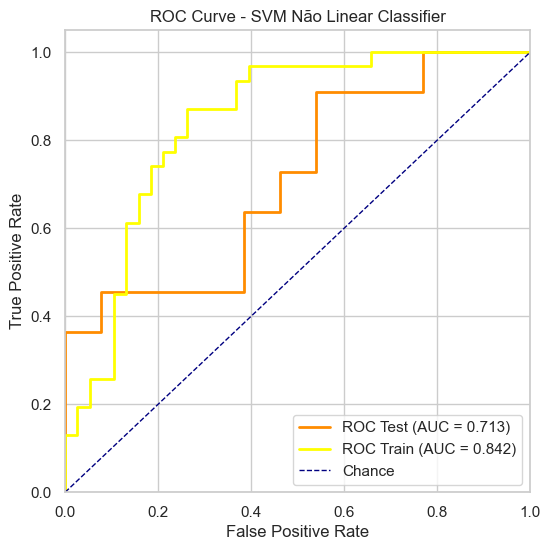

In [36]:
## SVM NÃO LINEAR (RBF)  — 60/20/20 - ['Glucose', 'HOMA', 'BMI', 'Age']
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc
)
import numpy as np
import matplotlib.pyplot as plt

sel_features = ['Glucose', 'HOMA', 'BMI', 'Age']

X = data[sel_features].to_numpy()
y = data["Classification"].to_numpy()

# Hiperparâmetros
C_values = [0.1, 1, 5, 10, 50]
gamma_values = ["scale", 0.1, 0.01, 0.001]

N_RUNS = 20

train_accs, train_precs, train_recs, train_f1s = [], [], [], []
test_accs,  test_precs,  test_recs,  test_f1s  = [], [], [], []
test_aucs = []


for seed in range(N_RUNS):

    # SPLIT 60 / 20 / 20
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.40, stratify=y, random_state=seed
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=seed
    )

    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_val_n   = scaler.transform(X_val)
    X_test_n  = scaler.transform(X_test)
    

    best_f1 = -np.inf
    best_C = None
    best_gamma = None

    for C in C_values:
        for gamma in gamma_values:

            svm = SVC(
                kernel="rbf",
                C=C,
                gamma=gamma,
                probability=True,
                class_weight="balanced",
                random_state=seed
            )
            svm.fit(X_train_n, y_train)

            y_val_pred = svm.predict(X_val_n)
            f1_val = f1_score(y_val, y_val_pred, pos_label=2)
            val_acc   = accuracy_score(y_val, y_val_pred)
            val_prec  = precision_score(y_val, y_val_pred, pos_label=2, zero_division=0)
            val_rec   = recall_score(y_val, y_val_pred, pos_label=2)

            if f1_val > best_f1:
                best_f1 = f1_val
                best_C = C
                best_gamma = gamma

                val_metrics_C.append((val_acc, val_prec, val_rec, f1_val))

    val_accs.append( np.mean([m[0] for m in val_metrics_C]) )
    val_precs.append(np.mean([m[1] for m in val_metrics_C]))
    val_recs.append( np.mean([m[2] for m in val_metrics_C]) )
    val_f1s.append(  np.mean([m[3] for m in val_metrics_C]) )
        

    final_svm = SVC(
        kernel="rbf",
        C=best_C,
        gamma=best_gamma,
        probability=True,
        class_weight="balanced",
        random_state=seed
    )
    final_svm.fit(X_train_n, y_train)


    y_train_pred = final_svm.predict(X_train_n)

    train_accs.append(accuracy_score(y_train, y_train_pred))
    train_precs.append(precision_score(y_train, y_train_pred, pos_label=2))
    train_recs.append(recall_score(y_train, y_train_pred, pos_label=2))
    train_f1s.append(f1_score(y_train, y_train_pred, pos_label=2))


    y_test_pred = final_svm.predict(X_test_n)

    test_accs.append(accuracy_score(y_test, y_test_pred))
    test_precs.append(precision_score(y_test, y_test_pred, pos_label=2))
    test_recs.append(recall_score(y_test, y_test_pred, pos_label=2))
    test_f1s.append(f1_score(y_test, y_test_pred, pos_label=2))



print("RESULTADOS SVM Não Linear")

print("\nMÉTRICAS DE TREINO (média ± std):")
print(f"Accuracy : {np.mean(train_accs):.3f} ± {np.std(train_accs):.3f}")
print(f"Precision: {np.mean(train_precs):.3f} ± {np.std(train_precs):.3f}")
print(f"Recall   : {np.mean(train_recs):.3f} ± {np.std(train_recs):.3f}")
print(f"F1-score : {np.mean(train_f1s):.3f} ± {np.std(train_f1s):.3f}")

print("\nMÉTRICAS DE VALIDAÇÃO (média ± std):")
print(f"Accuracy : {np.mean(val_accs):.3f} ± {np.std(val_accs):.3f}")
print(f"Precision: {np.mean(val_precs):.3f} ± {np.std(val_precs):.3f}")
print(f"Recall   : {np.mean(val_recs):.3f} ± {np.std(val_recs):.3f}")
print(f"F1-score : {np.mean(val_f1s):.3f} ± {np.std(val_f1s):.3f}")

print("\nMÉTRICAS DE TESTE (média ± std):")
print(f"Accuracy : {np.mean(test_accs):.3f} ± {np.std(test_accs):.3f}")
print(f"Precision: {np.mean(test_precs):.3f} ± {np.std(test_precs):.3f}")
print(f"Recall   : {np.mean(test_recs):.3f} ± {np.std(test_recs):.3f}")
print(f"F1-score : {np.mean(test_f1s):.3f} ± {np.std(test_f1s):.3f}")



probs = final_svm.predict_proba(X_test_n)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=1)
roc_auc = auc(fpr, tpr)

probs2p = final_svm.predict_proba(X_train_n)[:, 1]
fpr2p, tpr2p, thresholds2p = roc_curve(y_train, probs2p, pos_label=1)
roc_auc2p = auc(fpr2p, tpr2p)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Test (AUC = {roc_auc:.3f})')
plt.plot(fpr2p, tpr2p, color='yellow', lw=2, label=f'ROC Train (AUC = {roc_auc2p:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Não Linear Classifier')
plt.legend(loc="lower right")
plt.show()

RESULTADOS SVM Não Linear

MÉTRICAS DE TREINO (média ± std):
Accuracy : 0.746 ± 0.054
Precision: 0.755 ± 0.068
Recall   : 0.822 ± 0.085
F1-score : 0.781 ± 0.039

MÉTRICAS DE VALIDAÇÃO (média ± std):
Accuracy : 0.699 ± 0.049
Precision: 0.745 ± 0.076
Recall   : 0.779 ± 0.143
F1-score : 0.732 ± 0.083

MÉTRICAS DE TESTE (média ± std):
Accuracy : 0.688 ± 0.069
Precision: 0.712 ± 0.080
Recall   : 0.750 ± 0.144
F1-score : 0.719 ± 0.068


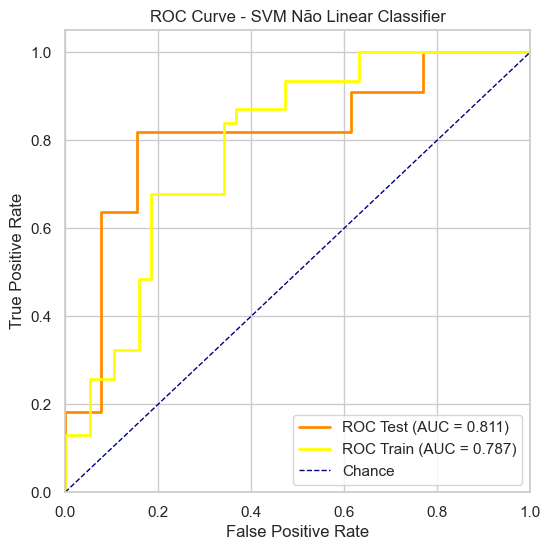

In [37]:
## SVM NÃO LINEAR (RBF)  — 60/20/20 - ['Glucose', 'HOMA', 'Age']

sel_features = ['Glucose', 'HOMA', 'Age']

X = data[sel_features].to_numpy()
y = data["Classification"].to_numpy()

# Hiperparâmetros
C_values = [0.1, 1, 5, 10, 50]
gamma_values = ["scale", 0.1, 0.01, 0.001]

N_RUNS = 20

train_accs, train_precs, train_recs, train_f1s = [], [], [], []
test_accs,  test_precs,  test_recs,  test_f1s  = [], [], [], []
test_aucs = []


for seed in range(N_RUNS):

    # SPLIT 60 / 20 / 20
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.40, stratify=y, random_state=seed
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=seed
    )

    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_val_n   = scaler.transform(X_val)
    X_test_n  = scaler.transform(X_test)

    best_f1 = -np.inf
    best_C = None
    best_gamma = None

    for C in C_values:
        for gamma in gamma_values:

            svm = SVC(
                kernel="rbf",
                C=C,
                gamma=gamma,
                probability=True,
                class_weight="balanced",
                random_state=seed
            )
            svm.fit(X_train_n, y_train)

            y_val_pred = svm.predict(X_val_n)
            f1_val = f1_score(y_val, y_val_pred, pos_label=2)
            val_acc   = accuracy_score(y_val, y_val_pred)
            val_prec  = precision_score(y_val, y_val_pred, pos_label=2, zero_division=0)
            val_rec   = recall_score(y_val, y_val_pred, pos_label=2)

            if f1_val > best_f1:
                best_f1 = f1_val
                best_C = C
                best_gamma = gamma

                val_metrics_C.append((val_acc, val_prec, val_rec, f1_val))

    val_accs.append( np.mean([m[0] for m in val_metrics_C]) )
    val_precs.append(np.mean([m[1] for m in val_metrics_C]))
    val_recs.append( np.mean([m[2] for m in val_metrics_C]) )
    val_f1s.append(  np.mean([m[3] for m in val_metrics_C]) )

    final_svm = SVC(
        kernel="rbf",
        C=best_C,
        gamma=best_gamma,
        probability=True,
        class_weight="balanced",
        random_state=seed
    )
    final_svm.fit(X_train_n, y_train)


    y_train_pred = final_svm.predict(X_train_n)

    train_accs.append(accuracy_score(y_train, y_train_pred))
    train_precs.append(precision_score(y_train, y_train_pred, pos_label=2))
    train_recs.append(recall_score(y_train, y_train_pred, pos_label=2))
    train_f1s.append(f1_score(y_train, y_train_pred, pos_label=2))


    y_test_pred = final_svm.predict(X_test_n)

    test_accs.append(accuracy_score(y_test, y_test_pred))
    test_precs.append(precision_score(y_test, y_test_pred, pos_label=2))
    test_recs.append(recall_score(y_test, y_test_pred, pos_label=2))
    test_f1s.append(f1_score(y_test, y_test_pred, pos_label=2))



print("RESULTADOS SVM Não Linear")

print("\nMÉTRICAS DE TREINO (média ± std):")
print(f"Accuracy : {np.mean(train_accs):.3f} ± {np.std(train_accs):.3f}")
print(f"Precision: {np.mean(train_precs):.3f} ± {np.std(train_precs):.3f}")
print(f"Recall   : {np.mean(train_recs):.3f} ± {np.std(train_recs):.3f}")
print(f"F1-score : {np.mean(train_f1s):.3f} ± {np.std(train_f1s):.3f}")

print("\nMÉTRICAS DE VALIDAÇÃO (média ± std):")
print(f"Accuracy : {np.mean(val_accs):.3f} ± {np.std(val_accs):.3f}")
print(f"Precision: {np.mean(val_precs):.3f} ± {np.std(val_precs):.3f}")
print(f"Recall   : {np.mean(val_recs):.3f} ± {np.std(val_recs):.3f}")
print(f"F1-score : {np.mean(val_f1s):.3f} ± {np.std(val_f1s):.3f}")

print("\nMÉTRICAS DE TESTE (média ± std):")
print(f"Accuracy : {np.mean(test_accs):.3f} ± {np.std(test_accs):.3f}")
print(f"Precision: {np.mean(test_precs):.3f} ± {np.std(test_precs):.3f}")
print(f"Recall   : {np.mean(test_recs):.3f} ± {np.std(test_recs):.3f}")
print(f"F1-score : {np.mean(test_f1s):.3f} ± {np.std(test_f1s):.3f}")



probs = final_svm.predict_proba(X_test_n)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=1)
roc_auc = auc(fpr, tpr)

probs2p = final_svm.predict_proba(X_train_n)[:, 1]
fpr2p, tpr2p, thresholds2p = roc_curve(y_train, probs2p, pos_label=1)
roc_auc2p = auc(fpr2p, tpr2p)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Test (AUC = {roc_auc:.3f})')
plt.plot(fpr2p, tpr2p, color='yellow', lw=2, label=f'ROC Train (AUC = {roc_auc2p:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Não Linear Classifier')
plt.legend(loc="lower right")
plt.show()


RESULTADOS SVM Não Linear

MÉTRICAS DE TREINO (média ± std):
Accuracy : 0.820 ± 0.120
Precision: 0.862 ± 0.116
Recall   : 0.838 ± 0.147
F1-score : 0.837 ± 0.106

MÉTRICAS DE VALIDAÇÃO (média ± std):
Accuracy : 0.699 ± 0.043
Precision: 0.739 ± 0.067
Recall   : 0.805 ± 0.132
F1-score : 0.743 ± 0.074

MÉTRICAS DE TESTE (média ± std):
Accuracy : 0.683 ± 0.087
Precision: 0.726 ± 0.091
Recall   : 0.715 ± 0.179
F1-score : 0.702 ± 0.096


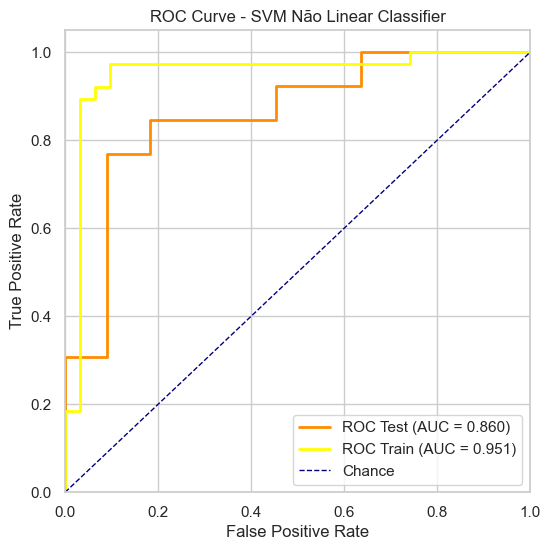

In [38]:
## SVM NÃO LINEAR (RBF) com PCA 5 comp — 60/20/20 - ['Glucose','HOMA', 'Age', 'MCP.1', 'BMI', 'Resistin', 'Adiponectin', 'Leptin', 'Insulin']

sel_features = ['Glucose','HOMA', 'Age', 'MCP.1', 'BMI', 'Resistin', 'Adiponectin', 'Leptin', 'Insulin']

X = data[sel_features].to_numpy()
y = data["Classification"].to_numpy()

# Hiperparâmetros
C_values = [0.1, 1, 5, 10, 50]
gamma_values = ["scale", 0.1, 0.01, 0.001]

N_RUNS = 20

train_accs, train_precs, train_recs, train_f1s = [], [], [], []
test_accs,  test_precs,  test_recs,  test_f1s  = [], [], [], []
test_aucs = []


for seed in range(N_RUNS):

    # SPLIT 60 / 20 / 20
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.40, stratify=y, random_state=seed
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=seed
    )

    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_val_n   = scaler.transform(X_val)
    X_test_n  = scaler.transform(X_test)

    # PCA
    pca = PCA(n_components=5, random_state=seed)
    X_train_pca = pca.fit_transform(X_train_n)
    X_val_pca   = pca.transform(X_val_n)
    X_test_pca  = pca.transform(X_test_n)

    best_f1 = -np.inf
    best_C = None
    best_gamma = None

    for C in C_values:
        for gamma in gamma_values:

            svm = SVC(
                kernel="rbf",
                C=C,
                gamma=gamma,
                probability=True,
                class_weight="balanced",
                random_state=seed
            )
            svm.fit(X_train_pca, y_train)

            y_val_pred = svm.predict(X_val_pca)
            f1_val = f1_score(y_val, y_val_pred, pos_label=2)
            val_acc   = accuracy_score(y_val, y_val_pred)
            val_prec  = precision_score(y_val, y_val_pred, pos_label=2, zero_division=0)
            val_rec   = recall_score(y_val, y_val_pred, pos_label=2)

            if f1_val > best_f1:
                best_f1 = f1_val
                best_C = C
                best_gamma = gamma

                val_metrics_C.append((val_acc, val_prec, val_rec, f1_val))

    val_accs.append( np.mean([m[0] for m in val_metrics_C]) )
    val_precs.append(np.mean([m[1] for m in val_metrics_C]))
    val_recs.append( np.mean([m[2] for m in val_metrics_C]) )
    val_f1s.append(  np.mean([m[3] for m in val_metrics_C]) )


    final_svm = SVC(
        kernel="rbf",
        C=best_C,
        gamma=best_gamma,
        probability=True,
        class_weight="balanced",
        random_state=seed
    )
    final_svm.fit(X_train_pca, y_train)


    y_train_pred = final_svm.predict(X_train_pca)

    train_accs.append(accuracy_score(y_train, y_train_pred))
    train_precs.append(precision_score(y_train, y_train_pred, pos_label=2))
    train_recs.append(recall_score(y_train, y_train_pred, pos_label=2))
    train_f1s.append(f1_score(y_train, y_train_pred, pos_label=2))


    y_test_pred = final_svm.predict(X_test_pca)

    test_accs.append(accuracy_score(y_test, y_test_pred))
    test_precs.append(precision_score(y_test, y_test_pred, pos_label=2))
    test_recs.append(recall_score(y_test, y_test_pred, pos_label=2))
    test_f1s.append(f1_score(y_test, y_test_pred, pos_label=2))



print("RESULTADOS SVM Não Linear")

print("\nMÉTRICAS DE TREINO (média ± std):")
print(f"Accuracy : {np.mean(train_accs):.3f} ± {np.std(train_accs):.3f}")
print(f"Precision: {np.mean(train_precs):.3f} ± {np.std(train_precs):.3f}")
print(f"Recall   : {np.mean(train_recs):.3f} ± {np.std(train_recs):.3f}")
print(f"F1-score : {np.mean(train_f1s):.3f} ± {np.std(train_f1s):.3f}")

print("\nMÉTRICAS DE VALIDAÇÃO (média ± std):")
print(f"Accuracy : {np.mean(val_accs):.3f} ± {np.std(val_accs):.3f}")
print(f"Precision: {np.mean(val_precs):.3f} ± {np.std(val_precs):.3f}")
print(f"Recall   : {np.mean(val_recs):.3f} ± {np.std(val_recs):.3f}")
print(f"F1-score : {np.mean(val_f1s):.3f} ± {np.std(val_f1s):.3f}")

print("\nMÉTRICAS DE TESTE (média ± std):")
print(f"Accuracy : {np.mean(test_accs):.3f} ± {np.std(test_accs):.3f}")
print(f"Precision: {np.mean(test_precs):.3f} ± {np.std(test_precs):.3f}")
print(f"Recall   : {np.mean(test_recs):.3f} ± {np.std(test_recs):.3f}")
print(f"F1-score : {np.mean(test_f1s):.3f} ± {np.std(test_f1s):.3f}")



probs = final_svm.predict_proba(X_test_pca)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=2)
roc_auc = auc(fpr, tpr)

probs2p = final_svm.predict_proba(X_train_pca)[:, 1]
fpr2p, tpr2p, thresholds2p = roc_curve(y_train, probs2p, pos_label=2)
roc_auc2p = auc(fpr2p, tpr2p)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Test (AUC = {roc_auc:.3f})')
plt.plot(fpr2p, tpr2p, color='yellow', lw=2, label=f'ROC Train (AUC = {roc_auc2p:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Não Linear Classifier')
plt.legend(loc="lower right")
plt.show()


RESULTADOS SVM Não Linear

MÉTRICAS DE TREINO (média ± std):
Accuracy : 0.866 ± 0.103
Precision: 0.900 ± 0.096
Recall   : 0.868 ± 0.111
F1-score : 0.878 ± 0.086

MÉTRICAS DE VALIDAÇÃO (média ± std):
Accuracy : 0.701 ± 0.039
Precision: 0.738 ± 0.060
Recall   : 0.819 ± 0.121
F1-score : 0.750 ± 0.068

MÉTRICAS DE TESTE (média ± std):
Accuracy : 0.756 ± 0.131
Precision: 0.816 ± 0.162
Recall   : 0.762 ± 0.159
F1-score : 0.771 ± 0.126


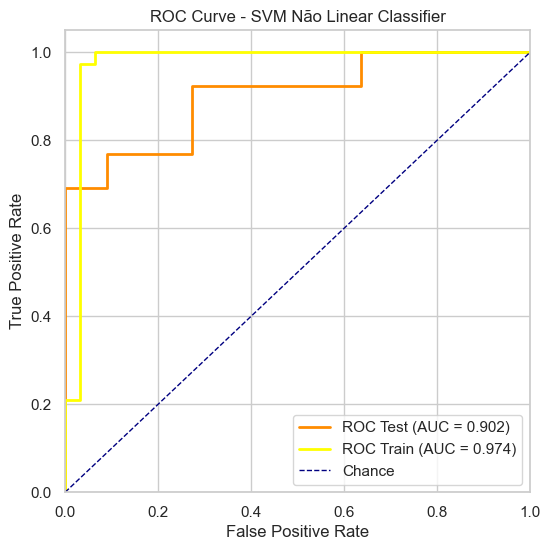

In [39]:
## SVM NÃO LINEAR (RBF)  — 60/20/20 - ['Glucose', 'HOMA', 'Age', 'MCP.1', 'BMI', 'Resistin', 'Adiponectin']

sel_features = ['Glucose','HOMA', 'Age', 'MCP.1', 'BMI', 'Resistin', 'Adiponectin']

X = data[sel_features].to_numpy()
y = data["Classification"].to_numpy()

# Hiperparâmetros
C_values = [0.1, 1, 5, 10, 50]
gamma_values = ["scale", 0.1, 0.01, 0.001]

N_RUNS = 20

train_accs, train_precs, train_recs, train_f1s = [], [], [], []
test_accs,  test_precs,  test_recs,  test_f1s  = [], [], [], []
test_aucs = []


for seed in range(N_RUNS):

    # SPLIT 60 / 20 / 20
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.40, stratify=y, random_state=seed
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=seed
    )

    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_val_n   = scaler.transform(X_val)
    X_test_n  = scaler.transform(X_test)

    # PCA
    pca = PCA(n_components=5, random_state=seed)
    X_train_pca = pca.fit_transform(X_train_n)
    X_val_pca   = pca.transform(X_val_n)
    X_test_pca  = pca.transform(X_test_n)

    best_f1 = -np.inf
    best_C = None
    best_gamma = None

    for C in C_values:
        for gamma in gamma_values:

            svm = SVC(
                kernel="rbf",
                C=C,
                gamma=gamma,
                probability=True,
                class_weight="balanced",
                random_state=seed
            )
            svm.fit(X_train_pca, y_train)

            y_val_pred = svm.predict(X_val_pca)
            f1_val = f1_score(y_val, y_val_pred, pos_label=2)
            val_acc   = accuracy_score(y_val, y_val_pred)
            val_prec  = precision_score(y_val, y_val_pred, pos_label=2, zero_division=0)
            val_rec   = recall_score(y_val, y_val_pred, pos_label=2)

            if f1_val > best_f1:
                best_f1 = f1_val
                best_C = C
                best_gamma = gamma

                val_metrics_C.append((val_acc, val_prec, val_rec, f1_val))

    val_accs.append( np.mean([m[0] for m in val_metrics_C]) )
    val_precs.append(np.mean([m[1] for m in val_metrics_C]))
    val_recs.append( np.mean([m[2] for m in val_metrics_C]) )
    val_f1s.append(  np.mean([m[3] for m in val_metrics_C]) )


    final_svm = SVC(
        kernel="rbf",
        C=best_C,
        gamma=best_gamma,
        probability=True,
        class_weight="balanced",
        random_state=seed
    )
    final_svm.fit(X_train_pca, y_train)


    y_train_pred = final_svm.predict(X_train_pca)

    train_accs.append(accuracy_score(y_train, y_train_pred))
    train_precs.append(precision_score(y_train, y_train_pred, pos_label=2))
    train_recs.append(recall_score(y_train, y_train_pred, pos_label=2))
    train_f1s.append(f1_score(y_train, y_train_pred, pos_label=2))


    y_test_pred = final_svm.predict(X_test_pca)

    test_accs.append(accuracy_score(y_test, y_test_pred))
    test_precs.append(precision_score(y_test, y_test_pred, pos_label=2))
    test_recs.append(recall_score(y_test, y_test_pred, pos_label=2))
    test_f1s.append(f1_score(y_test, y_test_pred, pos_label=2))



print("RESULTADOS SVM Não Linear")

print("\nMÉTRICAS DE TREINO (média ± std):")
print(f"Accuracy : {np.mean(train_accs):.3f} ± {np.std(train_accs):.3f}")
print(f"Precision: {np.mean(train_precs):.3f} ± {np.std(train_precs):.3f}")
print(f"Recall   : {np.mean(train_recs):.3f} ± {np.std(train_recs):.3f}")
print(f"F1-score : {np.mean(train_f1s):.3f} ± {np.std(train_f1s):.3f}")

print("\nMÉTRICAS DE VALIDAÇÃO (média ± std):")
print(f"Accuracy : {np.mean(val_accs):.3f} ± {np.std(val_accs):.3f}")
print(f"Precision: {np.mean(val_precs):.3f} ± {np.std(val_precs):.3f}")
print(f"Recall   : {np.mean(val_recs):.3f} ± {np.std(val_recs):.3f}")
print(f"F1-score : {np.mean(val_f1s):.3f} ± {np.std(val_f1s):.3f}")

print("\nMÉTRICAS DE TESTE (média ± std):")
print(f"Accuracy : {np.mean(test_accs):.3f} ± {np.std(test_accs):.3f}")
print(f"Precision: {np.mean(test_precs):.3f} ± {np.std(test_precs):.3f}")
print(f"Recall   : {np.mean(test_recs):.3f} ± {np.std(test_recs):.3f}")
print(f"F1-score : {np.mean(test_f1s):.3f} ± {np.std(test_f1s):.3f}")



probs = final_svm.predict_proba(X_test_pca)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=2)
roc_auc = auc(fpr, tpr)

probs2p = final_svm.predict_proba(X_train_pca)[:, 1]
fpr2p, tpr2p, thresholds2p = roc_curve(y_train, probs2p, pos_label=2)
roc_auc2p = auc(fpr2p, tpr2p)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Test (AUC = {roc_auc:.3f})')
plt.plot(fpr2p, tpr2p, color='yellow', lw=2, label=f'ROC Train (AUC = {roc_auc2p:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Não Linear Classifier')
plt.legend(loc="lower right")
plt.show()


RESULTADOS SVM Não Linear

MÉTRICAS DE TREINO (média ± std):
Accuracy : 0.851 ± 0.086
Precision: 0.901 ± 0.086
Recall   : 0.837 ± 0.098
F1-score : 0.862 ± 0.069

MÉTRICAS DE VALIDAÇÃO (média ± std):
Accuracy : 0.703 ± 0.035
Precision: 0.738 ± 0.055
Recall   : 0.829 ± 0.113
F1-score : 0.755 ± 0.063

MÉTRICAS DE TESTE (média ± std):
Accuracy : 0.760 ± 0.108
Precision: 0.827 ± 0.113
Recall   : 0.723 ± 0.147
F1-score : 0.762 ± 0.115


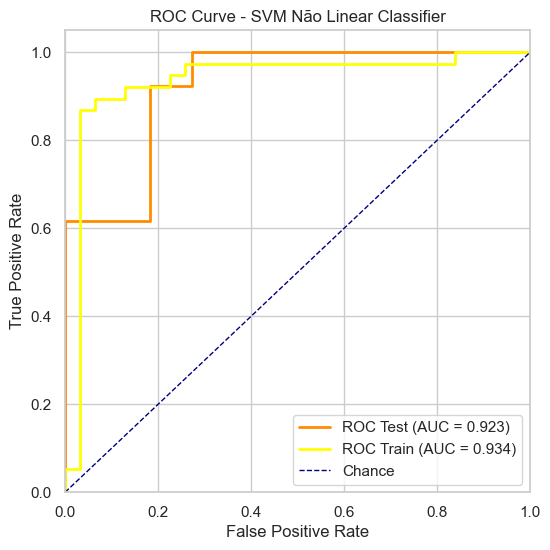

In [40]:
## SVM NÃO LINEAR (RBF)  — 60/20/20 - ['Glucose', 'HOMA', 'Age', 'MCP.1', 'BMI', 'Resistin']


sel_features = ['Glucose','HOMA', 'Age', 'MCP.1', 'BMI', 'Resistin']

X = data[sel_features].to_numpy()
y = data["Classification"].to_numpy()

# Hiperparâmetros
C_values = [0.1, 1, 5, 10]
gamma_values = ["scale", 0.1, 0.01, 0.001]

N_RUNS = 20

train_accs, train_precs, train_recs, train_f1s = [], [], [], []
test_accs,  test_precs,  test_recs,  test_f1s  = [], [], [], []
test_aucs = []


for seed in range(N_RUNS):

    # SPLIT 60 / 20 / 20
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.40, stratify=y, random_state=seed
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=seed
    )

    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_val_n   = scaler.transform(X_val)
    X_test_n  = scaler.transform(X_test)

    # PCA
    pca = PCA(n_components=5, random_state=seed)
    X_train_pca = pca.fit_transform(X_train_n)
    X_val_pca   = pca.transform(X_val_n)
    X_test_pca  = pca.transform(X_test_n)

    best_f1 = -np.inf
    best_C = None
    best_gamma = None

    for C in C_values:
        for gamma in gamma_values:

            svm = SVC(
                kernel="rbf",
                C=C,
                gamma=gamma,
                probability=True,
                class_weight="balanced",
                random_state=seed
            )
            svm.fit(X_train_pca, y_train)

            y_val_pred = svm.predict(X_val_pca)
            f1_val = f1_score(y_val, y_val_pred, pos_label=2)
            val_acc   = accuracy_score(y_val, y_val_pred)
            val_prec  = precision_score(y_val, y_val_pred, pos_label=2, zero_division=0)
            val_rec   = recall_score(y_val, y_val_pred, pos_label=2)

            if f1_val > best_f1:
                best_f1 = f1_val
                best_C = C
                best_gamma = gamma

                val_metrics_C.append((val_acc, val_prec, val_rec, f1_val))

    val_accs.append( np.mean([m[0] for m in val_metrics_C]) )
    val_precs.append(np.mean([m[1] for m in val_metrics_C]))
    val_recs.append( np.mean([m[2] for m in val_metrics_C]) )
    val_f1s.append(  np.mean([m[3] for m in val_metrics_C]) )


    final_svm = SVC(
        kernel="rbf",
        C=best_C,
        gamma=best_gamma,
        probability=True,
        class_weight="balanced",
        random_state=seed
    )
    final_svm.fit(X_train_pca, y_train)


    y_train_pred = final_svm.predict(X_train_pca)

    train_accs.append(accuracy_score(y_train, y_train_pred))
    train_precs.append(precision_score(y_train, y_train_pred, pos_label=2))
    train_recs.append(recall_score(y_train, y_train_pred, pos_label=2))
    train_f1s.append(f1_score(y_train, y_train_pred, pos_label=2))


    y_test_pred = final_svm.predict(X_test_pca)

    test_accs.append(accuracy_score(y_test, y_test_pred))
    test_precs.append(precision_score(y_test, y_test_pred, pos_label=2))
    test_recs.append(recall_score(y_test, y_test_pred, pos_label=2))
    test_f1s.append(f1_score(y_test, y_test_pred, pos_label=2))



print("RESULTADOS SVM Não Linear")

print("\nMÉTRICAS DE TREINO (média ± std):")
print(f"Accuracy : {np.mean(train_accs):.3f} ± {np.std(train_accs):.3f}")
print(f"Precision: {np.mean(train_precs):.3f} ± {np.std(train_precs):.3f}")
print(f"Recall   : {np.mean(train_recs):.3f} ± {np.std(train_recs):.3f}")
print(f"F1-score : {np.mean(train_f1s):.3f} ± {np.std(train_f1s):.3f}")

print("\nMÉTRICAS DE VALIDAÇÃO (média ± std):")
print(f"Accuracy : {np.mean(val_accs):.3f} ± {np.std(val_accs):.3f}")
print(f"Precision: {np.mean(val_precs):.3f} ± {np.std(val_precs):.3f}")
print(f"Recall   : {np.mean(val_recs):.3f} ± {np.std(val_recs):.3f}")
print(f"F1-score : {np.mean(val_f1s):.3f} ± {np.std(val_f1s):.3f}")

print("\nMÉTRICAS DE TESTE (média ± std):")
print(f"Accuracy : {np.mean(test_accs):.3f} ± {np.std(test_accs):.3f}")
print(f"Precision: {np.mean(test_precs):.3f} ± {np.std(test_precs):.3f}")
print(f"Recall   : {np.mean(test_recs):.3f} ± {np.std(test_recs):.3f}")
print(f"F1-score : {np.mean(test_f1s):.3f} ± {np.std(test_f1s):.3f}")



probs = final_svm.predict_proba(X_test_pca)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=2)
roc_auc = auc(fpr, tpr)

probs2p = final_svm.predict_proba(X_train_pca)[:, 1]
fpr2p, tpr2p, thresholds2p = roc_curve(y_train, probs2p, pos_label=2)
roc_auc2p = auc(fpr2p, tpr2p)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Test (AUC = {roc_auc:.3f})')
plt.plot(fpr2p, tpr2p, color='yellow', lw=2, label=f'ROC Train (AUC = {roc_auc2p:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Não Linear Classifier')
plt.legend(loc="lower right")
plt.show()


RESULTADOS SVM Não Linear

MÉTRICAS DE TREINO (média ± std):
Accuracy : 0.791 ± 0.077
Precision: 0.823 ± 0.096
Recall   : 0.822 ± 0.109
F1-score : 0.813 ± 0.059

MÉTRICAS DE VALIDAÇÃO (média ± std):
Accuracy : 0.705 ± 0.033
Precision: 0.738 ± 0.051
Recall   : 0.837 ± 0.106
F1-score : 0.760 ± 0.059

MÉTRICAS DE TESTE (média ± std):
Accuracy : 0.702 ± 0.120
Precision: 0.735 ± 0.161
Recall   : 0.719 ± 0.197
F1-score : 0.713 ± 0.156


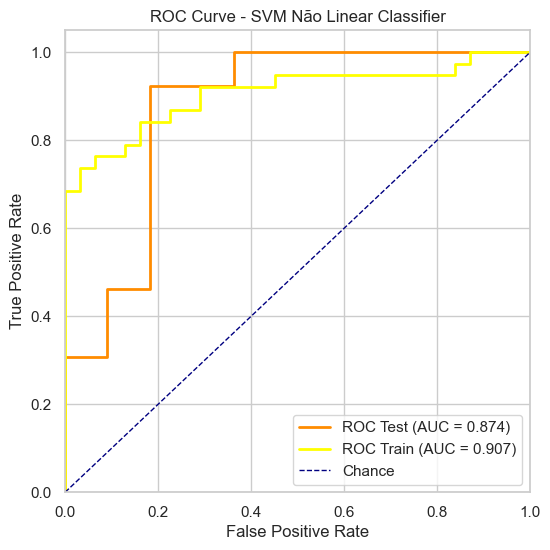

In [41]:
## SVM NÃO LINEAR (RBF)  — 60/20/20 - ['Glucose', 'HOMA', 'Age', 'BMI']

sel_features = ['Glucose','HOMA', 'Age', 'BMI']

X = data[sel_features].to_numpy()
y = data["Classification"].to_numpy()

# Hiperparâmetros
C_values = [0.1, 1, 5, 10, 50]
gamma_values = ["scale", 0.1, 0.01, 0.001]

N_RUNS = 20

train_accs, train_precs, train_recs, train_f1s = [], [], [], []
test_accs,  test_precs,  test_recs,  test_f1s  = [], [], [], []
test_aucs = []


for seed in range(N_RUNS):

    # SPLIT 60 / 20 / 20
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.40, stratify=y, random_state=seed
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=seed
    )

    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_val_n   = scaler.transform(X_val)
    X_test_n  = scaler.transform(X_test)

    # PCA
    pca = PCA(n_components=3, random_state=seed)
    X_train_pca = pca.fit_transform(X_train_n)
    X_val_pca   = pca.transform(X_val_n)
    X_test_pca  = pca.transform(X_test_n)

    best_f1 = -np.inf
    best_C = None
    best_gamma = None

    for C in C_values:
        for gamma in gamma_values:

            svm = SVC(
                kernel="rbf",
                C=C,
                gamma=gamma,
                probability=True,
                class_weight="balanced",
                random_state=seed
            )
            svm.fit(X_train_pca, y_train)

            y_val_pred = svm.predict(X_val_pca)
            f1_val = f1_score(y_val, y_val_pred, pos_label=2)
            val_acc   = accuracy_score(y_val, y_val_pred)
            val_prec  = precision_score(y_val, y_val_pred, pos_label=2, zero_division=0)
            val_rec   = recall_score(y_val, y_val_pred, pos_label=2)

            if f1_val > best_f1:
                best_f1 = f1_val
                best_C = C
                best_gamma = gamma

                val_metrics_C.append((val_acc, val_prec, val_rec, f1_val))

    val_accs.append( np.mean([m[0] for m in val_metrics_C]) )
    val_precs.append(np.mean([m[1] for m in val_metrics_C]))
    val_recs.append( np.mean([m[2] for m in val_metrics_C]) )
    val_f1s.append(  np.mean([m[3] for m in val_metrics_C]) )


    final_svm = SVC(
        kernel="rbf",
        C=best_C,
        gamma=best_gamma,
        probability=True,
        class_weight="balanced",
        random_state=seed
    )
    final_svm.fit(X_train_pca, y_train)


    y_train_pred = final_svm.predict(X_train_pca)

    train_accs.append(accuracy_score(y_train, y_train_pred))
    train_precs.append(precision_score(y_train, y_train_pred, pos_label=2))
    train_recs.append(recall_score(y_train, y_train_pred, pos_label=2))
    train_f1s.append(f1_score(y_train, y_train_pred, pos_label=2))


    y_test_pred = final_svm.predict(X_test_pca)

    test_accs.append(accuracy_score(y_test, y_test_pred))
    test_precs.append(precision_score(y_test, y_test_pred, pos_label=2))
    test_recs.append(recall_score(y_test, y_test_pred, pos_label=2))
    test_f1s.append(f1_score(y_test, y_test_pred, pos_label=2))



print("RESULTADOS SVM Não Linear")

print("\nMÉTRICAS DE TREINO (média ± std):")
print(f"Accuracy : {np.mean(train_accs):.3f} ± {np.std(train_accs):.3f}")
print(f"Precision: {np.mean(train_precs):.3f} ± {np.std(train_precs):.3f}")
print(f"Recall   : {np.mean(train_recs):.3f} ± {np.std(train_recs):.3f}")
print(f"F1-score : {np.mean(train_f1s):.3f} ± {np.std(train_f1s):.3f}")

print("\nMÉTRICAS DE VALIDAÇÃO (média ± std):")
print(f"Accuracy : {np.mean(val_accs):.3f} ± {np.std(val_accs):.3f}")
print(f"Precision: {np.mean(val_precs):.3f} ± {np.std(val_precs):.3f}")
print(f"Recall   : {np.mean(val_recs):.3f} ± {np.std(val_recs):.3f}")
print(f"F1-score : {np.mean(val_f1s):.3f} ± {np.std(val_f1s):.3f}")

print("\nMÉTRICAS DE TESTE (média ± std):")
print(f"Accuracy : {np.mean(test_accs):.3f} ± {np.std(test_accs):.3f}")
print(f"Precision: {np.mean(test_precs):.3f} ± {np.std(test_precs):.3f}")
print(f"Recall   : {np.mean(test_recs):.3f} ± {np.std(test_recs):.3f}")
print(f"F1-score : {np.mean(test_f1s):.3f} ± {np.std(test_f1s):.3f}")



probs = final_svm.predict_proba(X_test_pca)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=2)
roc_auc = auc(fpr, tpr)

probs2p = final_svm.predict_proba(X_train_pca)[:, 1]
fpr2p, tpr2p, thresholds2p = roc_curve(y_train, probs2p, pos_label=2)
roc_auc2p = auc(fpr2p, tpr2p)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Test (AUC = {roc_auc:.3f})')
plt.plot(fpr2p, tpr2p, color='yellow', lw=2, label=f'ROC Train (AUC = {roc_auc2p:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Não Linear Classifier')
plt.legend(loc="lower right")
plt.show()


RESULTADOS SVM Não Linear

MÉTRICAS DE TREINO (média ± std):
Accuracy : 0.787 ± 0.074
Precision: 0.823 ± 0.096
Recall   : 0.816 ± 0.108
F1-score : 0.809 ± 0.056

MÉTRICAS DE VALIDAÇÃO (média ± std):
Accuracy : 0.706 ± 0.031
Precision: 0.738 ± 0.047
Recall   : 0.842 ± 0.101
F1-score : 0.763 ± 0.056

MÉTRICAS DE TESTE (média ± std):
Accuracy : 0.704 ± 0.121
Precision: 0.738 ± 0.162
Recall   : 0.719 ± 0.197
F1-score : 0.714 ± 0.156


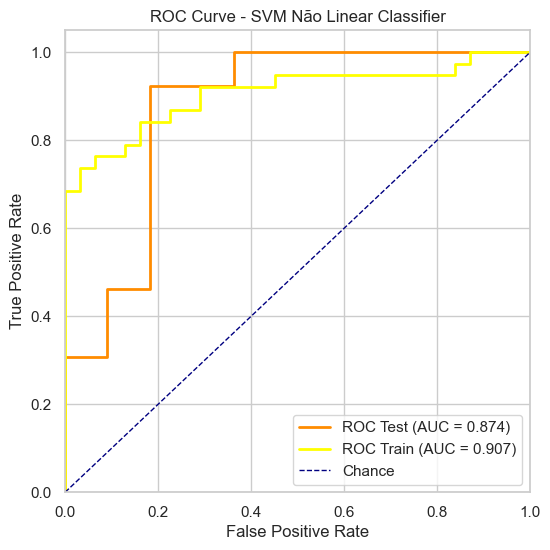

In [42]:
## SVM NÃO LINEAR (RBF) com PCA  — 60/20/20 - ['Glucose', 'HOMA', 'Age', 'BMI']

sel_features = ['Glucose','HOMA', 'Age', 'BMI']

X = data[sel_features].to_numpy()
y = data["Classification"].to_numpy()

# Hiperparâmetros
C_values = [0.1, 1, 5, 10]
gamma_values = ["scale", 0.1, 0.01, 0.001]

N_RUNS = 20

train_accs, train_precs, train_recs, train_f1s = [], [], [], []
test_accs,  test_precs,  test_recs,  test_f1s  = [], [], [], []
test_aucs = []


for seed in range(N_RUNS):

    # SPLIT 60 / 20 / 20
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.40, stratify=y, random_state=seed
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=seed
    )

    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_val_n   = scaler.transform(X_val)
    X_test_n  = scaler.transform(X_test)

    # PCA
    pca = PCA(n_components=3, random_state=seed)
    X_train_pca = pca.fit_transform(X_train_n)
    X_val_pca   = pca.transform(X_val_n)
    X_test_pca  = pca.transform(X_test_n)

    best_f1 = -np.inf
    best_C = None
    best_gamma = None

    for C in C_values:
        for gamma in gamma_values:

            svm = SVC(
                kernel="rbf",
                C=C,
                gamma=gamma,
                probability=True,
                class_weight="balanced",
                random_state=seed
            )
            svm.fit(X_train_pca, y_train)

            y_val_pred = svm.predict(X_val_pca)
            f1_val = f1_score(y_val, y_val_pred, pos_label=2)
            val_acc   = accuracy_score(y_val, y_val_pred)
            val_prec  = precision_score(y_val, y_val_pred, pos_label=2, zero_division=0)
            val_rec   = recall_score(y_val, y_val_pred, pos_label=2)

            if f1_val > best_f1:
                best_f1 = f1_val
                best_C = C
                best_gamma = gamma

                val_metrics_C.append((val_acc, val_prec, val_rec, f1_val))

    val_accs.append( np.mean([m[0] for m in val_metrics_C]) )
    val_precs.append(np.mean([m[1] for m in val_metrics_C]))
    val_recs.append( np.mean([m[2] for m in val_metrics_C]) )
    val_f1s.append(  np.mean([m[3] for m in val_metrics_C]) )


    final_svm = SVC(
        kernel="rbf",
        C=best_C,
        gamma=best_gamma,
        probability=True,
        class_weight="balanced",
        random_state=seed
    )
    final_svm.fit(X_train_pca, y_train)


    y_train_pred = final_svm.predict(X_train_pca)

    train_accs.append(accuracy_score(y_train, y_train_pred))
    train_precs.append(precision_score(y_train, y_train_pred, pos_label=2))
    train_recs.append(recall_score(y_train, y_train_pred, pos_label=2))
    train_f1s.append(f1_score(y_train, y_train_pred, pos_label=2))


    y_test_pred = final_svm.predict(X_test_pca)

    test_accs.append(accuracy_score(y_test, y_test_pred))
    test_precs.append(precision_score(y_test, y_test_pred, pos_label=2))
    test_recs.append(recall_score(y_test, y_test_pred, pos_label=2))
    test_f1s.append(f1_score(y_test, y_test_pred, pos_label=2))



print("RESULTADOS SVM Não Linear")

print("\nMÉTRICAS DE TREINO (média ± std):")
print(f"Accuracy : {np.mean(train_accs):.3f} ± {np.std(train_accs):.3f}")
print(f"Precision: {np.mean(train_precs):.3f} ± {np.std(train_precs):.3f}")
print(f"Recall   : {np.mean(train_recs):.3f} ± {np.std(train_recs):.3f}")
print(f"F1-score : {np.mean(train_f1s):.3f} ± {np.std(train_f1s):.3f}")

print("\nMÉTRICAS DE VALIDAÇÃO (média ± std):")
print(f"Accuracy : {np.mean(val_accs):.3f} ± {np.std(val_accs):.3f}")
print(f"Precision: {np.mean(val_precs):.3f} ± {np.std(val_precs):.3f}")
print(f"Recall   : {np.mean(val_recs):.3f} ± {np.std(val_recs):.3f}")
print(f"F1-score : {np.mean(val_f1s):.3f} ± {np.std(val_f1s):.3f}")

print("\nMÉTRICAS DE TESTE (média ± std):")
print(f"Accuracy : {np.mean(test_accs):.3f} ± {np.std(test_accs):.3f}")
print(f"Precision: {np.mean(test_precs):.3f} ± {np.std(test_precs):.3f}")
print(f"Recall   : {np.mean(test_recs):.3f} ± {np.std(test_recs):.3f}")
print(f"F1-score : {np.mean(test_f1s):.3f} ± {np.std(test_f1s):.3f}")



probs = final_svm.predict_proba(X_test_pca)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=2)
roc_auc = auc(fpr, tpr)

probs2p = final_svm.predict_proba(X_train_pca)[:, 1]
fpr2p, tpr2p, thresholds2p = roc_curve(y_train, probs2p, pos_label=2)
roc_auc2p = auc(fpr2p, tpr2p)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Test (AUC = {roc_auc:.3f})')
plt.plot(fpr2p, tpr2p, color='yellow', lw=2, label=f'ROC Train (AUC = {roc_auc2p:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Não Linear Classifier')
plt.legend(loc="lower right")
plt.show()


RESULTADOS SVM Não Linear

MÉTRICAS DE TREINO (média ± std):
Accuracy : 0.635 ± 0.076
Precision: 0.667 ± 0.108
Recall   : 0.817 ± 0.159
F1-score : 0.711 ± 0.021

MÉTRICAS DE VALIDAÇÃO (média ± std):
Accuracy : 0.706 ± 0.029
Precision: 0.737 ± 0.045
Recall   : 0.846 ± 0.095
F1-score : 0.765 ± 0.053

MÉTRICAS DE TESTE (média ± std):
Accuracy : 0.627 ± 0.091
Precision: 0.656 ± 0.115
Recall   : 0.812 ± 0.164
F1-score : 0.702 ± 0.048


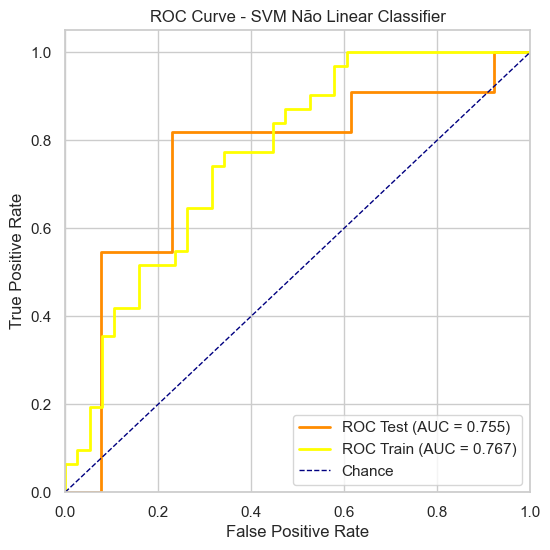

In [43]:
## SVM NÃO LINEAR (RBF)  — 60/20/20 - ['Glucose', 'HOMA']

sel_features = ['Glucose', 'HOMA']

X = data[sel_features].to_numpy()
y = data["Classification"].to_numpy()

# Hiperparâmetros
C_values = [0.1, 1, 5, 10]
gamma_values = ["scale", 0.1, 0.01, 0.001]

N_RUNS = 20

train_accs, train_precs, train_recs, train_f1s = [], [], [], []
test_accs,  test_precs,  test_recs,  test_f1s  = [], [], [], []
test_aucs = []


for seed in range(N_RUNS):

    # SPLIT 60 / 20 / 20
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.40, stratify=y, random_state=seed
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=seed
    )

    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_val_n   = scaler.transform(X_val)
    X_test_n  = scaler.transform(X_test)
    

    best_f1 = -np.inf
    best_C = None
    best_gamma = None

    for C in C_values:
        for gamma in gamma_values:

            svm = SVC(
                kernel="rbf",
                C=C,
                gamma=gamma,
                probability=True,
                class_weight="balanced",
                random_state=seed
            )
            svm.fit(X_train_n, y_train)

            y_val_pred = svm.predict(X_val_n)
            f1_val = f1_score(y_val, y_val_pred, pos_label=2)
            val_acc   = accuracy_score(y_val, y_val_pred)
            val_prec  = precision_score(y_val, y_val_pred, pos_label=2, zero_division=0)
            val_rec   = recall_score(y_val, y_val_pred, pos_label=2)

            if f1_val > best_f1:
                best_f1 = f1_val
                best_C = C
                best_gamma = gamma

                val_metrics_C.append((val_acc, val_prec, val_rec, f1_val))

    val_accs.append( np.mean([m[0] for m in val_metrics_C]) )
    val_precs.append(np.mean([m[1] for m in val_metrics_C]))
    val_recs.append( np.mean([m[2] for m in val_metrics_C]) )
    val_f1s.append(  np.mean([m[3] for m in val_metrics_C]) )
        

    final_svm = SVC(
        kernel="rbf",
        C=best_C,
        gamma=best_gamma,
        probability=True,
        class_weight="balanced",
        random_state=seed
    )
    final_svm.fit(X_train_n, y_train)


    y_train_pred = final_svm.predict(X_train_n)

    train_accs.append(accuracy_score(y_train, y_train_pred))
    train_precs.append(precision_score(y_train, y_train_pred, pos_label=2))
    train_recs.append(recall_score(y_train, y_train_pred, pos_label=2))
    train_f1s.append(f1_score(y_train, y_train_pred, pos_label=2))


    y_test_pred = final_svm.predict(X_test_n)

    test_accs.append(accuracy_score(y_test, y_test_pred))
    test_precs.append(precision_score(y_test, y_test_pred, pos_label=2))
    test_recs.append(recall_score(y_test, y_test_pred, pos_label=2))
    test_f1s.append(f1_score(y_test, y_test_pred, pos_label=2))



print("RESULTADOS SVM Não Linear")

print("\nMÉTRICAS DE TREINO (média ± std):")
print(f"Accuracy : {np.mean(train_accs):.3f} ± {np.std(train_accs):.3f}")
print(f"Precision: {np.mean(train_precs):.3f} ± {np.std(train_precs):.3f}")
print(f"Recall   : {np.mean(train_recs):.3f} ± {np.std(train_recs):.3f}")
print(f"F1-score : {np.mean(train_f1s):.3f} ± {np.std(train_f1s):.3f}")

print("\nMÉTRICAS DE VALIDAÇÃO (média ± std):")
print(f"Accuracy : {np.mean(val_accs):.3f} ± {np.std(val_accs):.3f}")
print(f"Precision: {np.mean(val_precs):.3f} ± {np.std(val_precs):.3f}")
print(f"Recall   : {np.mean(val_recs):.3f} ± {np.std(val_recs):.3f}")
print(f"F1-score : {np.mean(val_f1s):.3f} ± {np.std(val_f1s):.3f}")

print("\nMÉTRICAS DE TESTE (média ± std):")
print(f"Accuracy : {np.mean(test_accs):.3f} ± {np.std(test_accs):.3f}")
print(f"Precision: {np.mean(test_precs):.3f} ± {np.std(test_precs):.3f}")
print(f"Recall   : {np.mean(test_recs):.3f} ± {np.std(test_recs):.3f}")
print(f"F1-score : {np.mean(test_f1s):.3f} ± {np.std(test_f1s):.3f}")



probs = final_svm.predict_proba(X_test_n)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=1)
roc_auc = auc(fpr, tpr)

probs2p = final_svm.predict_proba(X_train_n)[:, 1]
fpr2p, tpr2p, thresholds2p = roc_curve(y_train, probs2p, pos_label=1)
roc_auc2p = auc(fpr2p, tpr2p)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Test (AUC = {roc_auc:.3f})')
plt.plot(fpr2p, tpr2p, color='yellow', lw=2, label=f'ROC Train (AUC = {roc_auc2p:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Não Linear Classifier')
plt.legend(loc="lower right")
plt.show()


RESULTADOS SVM Não Linear

MÉTRICAS DE TREINO (média ± std):
Accuracy : 0.728 ± 0.077
Precision: 0.733 ± 0.080
Recall   : 0.837 ± 0.103
F1-score : 0.773 ± 0.051

MÉTRICAS DE VALIDAÇÃO (média ± std):
Accuracy : 0.707 ± 0.028
Precision: 0.737 ± 0.042
Recall   : 0.849 ± 0.091
F1-score : 0.766 ± 0.051

MÉTRICAS DE TESTE (média ± std):
Accuracy : 0.719 ± 0.082
Precision: 0.741 ± 0.097
Recall   : 0.796 ± 0.120
F1-score : 0.755 ± 0.054


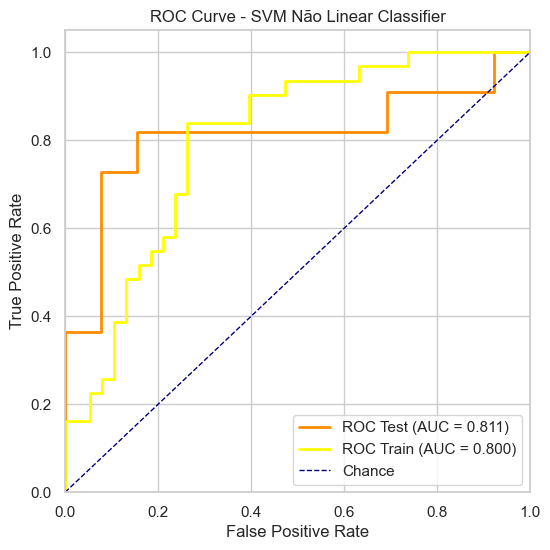

In [44]:
## SVM NÃO LINEAR (RBF)  — 60/20/20 - ['Glucose', 'Age']

sel_features = ['Glucose', 'Age']

X = data[sel_features].to_numpy()
y = data["Classification"].to_numpy()

# Hiperparâmetros
C_values = [0.1, 1, 5, 10]
gamma_values = ["scale", 0.1, 0.01, 0.001]

N_RUNS = 20

train_accs, train_precs, train_recs, train_f1s = [], [], [], []
test_accs,  test_precs,  test_recs,  test_f1s  = [], [], [], []
test_aucs = []


for seed in range(N_RUNS):

    # SPLIT 60 / 20 / 20
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.40, stratify=y, random_state=seed
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=seed
    )

    scaler = StandardScaler()
    X_train_n = scaler.fit_transform(X_train)
    X_val_n   = scaler.transform(X_val)
    X_test_n  = scaler.transform(X_test)
    

    best_f1 = -np.inf
    best_C = None
    best_gamma = None

    for C in C_values:
        for gamma in gamma_values:

            svm = SVC(
                kernel="rbf",
                C=C,
                gamma=gamma,
                probability=True,
                class_weight="balanced",
                random_state=seed
            )
            svm.fit(X_train_n, y_train)

            y_val_pred = svm.predict(X_val_n)
            f1_val = f1_score(y_val, y_val_pred, pos_label=2)
            val_acc   = accuracy_score(y_val, y_val_pred)
            val_prec  = precision_score(y_val, y_val_pred, pos_label=2, zero_division=0)
            val_rec   = recall_score(y_val, y_val_pred, pos_label=2)

            if f1_val > best_f1:
                best_f1 = f1_val
                best_C = C
                best_gamma = gamma

                val_metrics_C.append((val_acc, val_prec, val_rec, f1_val))

    val_accs.append( np.mean([m[0] for m in val_metrics_C]) )
    val_precs.append(np.mean([m[1] for m in val_metrics_C]))
    val_recs.append( np.mean([m[2] for m in val_metrics_C]) )
    val_f1s.append(  np.mean([m[3] for m in val_metrics_C]) )
        

    final_svm = SVC(
        kernel="rbf",
        C=best_C,
        gamma=best_gamma,
        probability=True,
        class_weight="balanced",
        random_state=seed
    )
    final_svm.fit(X_train_n, y_train)


    y_train_pred = final_svm.predict(X_train_n)

    train_accs.append(accuracy_score(y_train, y_train_pred))
    train_precs.append(precision_score(y_train, y_train_pred, pos_label=2))
    train_recs.append(recall_score(y_train, y_train_pred, pos_label=2))
    train_f1s.append(f1_score(y_train, y_train_pred, pos_label=2))


    y_test_pred = final_svm.predict(X_test_n)

    test_accs.append(accuracy_score(y_test, y_test_pred))
    test_precs.append(precision_score(y_test, y_test_pred, pos_label=2))
    test_recs.append(recall_score(y_test, y_test_pred, pos_label=2))
    test_f1s.append(f1_score(y_test, y_test_pred, pos_label=2))



print("RESULTADOS SVM Não Linear")

print("\nMÉTRICAS DE TREINO (média ± std):")
print(f"Accuracy : {np.mean(train_accs):.3f} ± {np.std(train_accs):.3f}")
print(f"Precision: {np.mean(train_precs):.3f} ± {np.std(train_precs):.3f}")
print(f"Recall   : {np.mean(train_recs):.3f} ± {np.std(train_recs):.3f}")
print(f"F1-score : {np.mean(train_f1s):.3f} ± {np.std(train_f1s):.3f}")

print("\nMÉTRICAS DE VALIDAÇÃO (média ± std):")
print(f"Accuracy : {np.mean(val_accs):.3f} ± {np.std(val_accs):.3f}")
print(f"Precision: {np.mean(val_precs):.3f} ± {np.std(val_precs):.3f}")
print(f"Recall   : {np.mean(val_recs):.3f} ± {np.std(val_recs):.3f}")
print(f"F1-score : {np.mean(val_f1s):.3f} ± {np.std(val_f1s):.3f}")

print("\nMÉTRICAS DE TESTE (média ± std):")
print(f"Accuracy : {np.mean(test_accs):.3f} ± {np.std(test_accs):.3f}")
print(f"Precision: {np.mean(test_precs):.3f} ± {np.std(test_precs):.3f}")
print(f"Recall   : {np.mean(test_recs):.3f} ± {np.std(test_recs):.3f}")
print(f"F1-score : {np.mean(test_f1s):.3f} ± {np.std(test_f1s):.3f}")



probs = final_svm.predict_proba(X_test_n)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=1)
roc_auc = auc(fpr, tpr)

probs2p = final_svm.predict_proba(X_train_n)[:, 1]
fpr2p, tpr2p, thresholds2p = roc_curve(y_train, probs2p, pos_label=1)
roc_auc2p = auc(fpr2p, tpr2p)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Test (AUC = {roc_auc:.3f})')
plt.plot(fpr2p, tpr2p, color='yellow', lw=2, label=f'ROC Train (AUC = {roc_auc2p:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Não Linear Classifier')
plt.legend(loc="lower right")
plt.show()

### Decision Trees